# Predizione {#sec-prediction}

**Prerequisiti**

**Concetti e Competenze Chiave**

**Preparazione del Notebook**

In [17]:
here::here("code", "_common.R")  \mid >
    source()

# Load packages
if (!requireNamespace("pacman")) install.packages("pacman")
pacman::p_load(
    petersenlab, magrittr, viridis, pROC, ROCR, rms, ResourceSelection,
    PredictABEL, gridExtra, grid, ggpubr, msir, car, ggrepel, MOTE,
    tinytex
)

> "It is very difficult to predict—especially the future."
>
> --- Neils Bohr

## Introduzione

Le predizioni possono essere di vario tipo. Alcune riguardano dati categoriali, mentre altre si basano su dati continui. Per i dati categoriali, possiamo valutare le predizioni utilizzando una tabella 2x2, nota come matrice di confusione, o con modelli di regressione logistica. Invece, per i dati continui, possiamo utilizzare la regressione multipla o varianti come il modello a equazioni strutturali o i modelli misti.

Consideriamo un esempio pratico di predizione della probabilità di contrarre l'HIV, utilizzando le seguenti informazioni [@petersen2024principles]:

- **Tasso di base dell'HIV (P(HIV))**: 0.3% (0.003). Questa è la probabilità che una persona nella popolazione generale abbia l'HIV.
- **Sensibilità del test (P(Test+ \mid HIV))**: 95% (0.95). Questa è la probabilità che il test risulti positivo se la persona ha effettivamente l'HIV.
- **Specificità del test (P(Test- \mid ¬HIV))**: 99.28% (0.9928). Questa è la probabilità che il test risulti negativo se la persona non ha l'HIV.

## Calcolo della probabilità di HIV dato un test positivo

Per calcolare la probabilità di avere l'HIV dato un test positivo (P(HIV \mid Test+)), utilizziamo il teorema di Bayes:

$$
P(HIV \mid Test+) = \frac{P(Test+ \mid HIV) \times P(HIV)}{P(Test+)}.
$$

Abbiamo bisogno di calcolare il denominatore, ovvero la probabilità complessiva di ottenere un test positivo (P(Test+)). Questo valore include sia i veri positivi che i falsi positivi:

$$
P(Test+) = P(Test+ \mid HIV) \times P(HIV) + P(Test+ \mid \neg HIV) \times P(\neg HIV),
$$

dove:

- $P(Test+ \mid \neg HIV) = 1 - P(Test- \mid \neg HIV) = 1 - 0.9928 = 0.0072$ (tasso di falsi positivi),
- $P(\neg HIV) = 1 - P(HIV) = 1 - 0.003 = 0.997$.

Calcoliamo $P(Test+)$:

$$
P(Test+) = (0.95 \times 0.003) + (0.0072 \times 0.997) \approx 0.010027.
$$

Ora possiamo calcolare $P(HIV \mid Test+)$:

$$
P(HIV \mid Test+) = \frac{0.95 \times 0.003}{0.010027} \approx 0.2844 \text{ o 28.44\%}.
$$

Quindi, se il test risulta positivo, la probabilità di avere l'HIV è circa il 28.44%.

## Calcolo della probabilità di un secondo test positivo

Dopo un primo test positivo, la probabilità di avere l'HIV è aumentata al 28.44%. Ora calcoleremo la probabilità che un secondo test risulti positivo e la conseguente probabilità di avere l'HIV dopo due test positivi consecutivi.

### Probabilità di un secondo test positivo

Per calcolare $P(\text{Secondo Test+})$, consideriamo due scenari:

1. La persona ha effettivamente l'HIV:
   - Probabilità: $P(HIV \mid Test+) = 0.2844$.
   - Probabilità di un test positivo: $P(\text{Test+} \mid HIV) = 0.95$ (sensibilità del test).

2. La persona non ha l'HIV:
   - Probabilità: $P(\neg HIV \mid Test+) = 1 - P(HIV \mid Test+) = 0.7156$.
   - Probabilità di un test positivo: $P(\text{Test+} \mid \neg HIV) = 0.0072$ (tasso di falsi positivi).

Utilizziamo la formula della probabilità totale:

$$
\begin{aligned}
P(\text{Secondo Test+}) &= P(\text{Test+} \mid HIV) \times P(HIV \mid Test+) + \\
&\quad P(\text{Test+} \mid \neg HIV) \times P(\neg HIV \mid Test+).
\end{aligned}
$$

Sostituendo i valori:

$$
P(\text{Secondo Test+}) = (0.95 \times 0.2844) + (0.0072 \times 0.7156) \approx 0.2753.
$$

### Probabilità di HIV dopo due test positivi

Applichiamo nuovamente il teorema di Bayes per calcolare la probabilità di avere l'HIV dopo un secondo test positivo:

$$
P(HIV \mid \text{Secondo Test+}) = \frac{P(\text{Secondo Test+} \mid HIV) \times P(HIV \mid Test+)}{P(\text{Secondo Test+})}.
$$

Sostituendo i valori:

$$
P(HIV \mid \text{Secondo Test+}) = \frac{0.95 \times 0.2844}{0.2753} \approx 0.981.
$$

### Interpretazione dei risultati

Dopo un secondo test positivo, la probabilità di avere l'HIV aumenta significativamente, passando dal 28.44% al 98.1%. Questo aumento drastico dimostra l'importanza di:

1. Considerare il tasso di base (prevalenza) nella popolazione.
2. Aggiornare progressivamente le probabilità con nuove evidenze.
3. Interpretare i risultati di test diagnostici multipli in modo bayesiano.

L'analisi evidenzia come l'accumulo di evidenze attraverso test ripetuti, in linea con i principi del teorema di Bayes, possa portare a una stima molto più accurata della probabilità di avere una condizione medica, riducendo significativamente l'incertezza iniziale.

## Accuratezza delle Predizioni

Per valutare l'accuratezza delle predizioni, @petersen2024principles considera un esempio adattato da Meehl (1955). L'esercito esegue un test sui candidati per escludere quelli che probabilmente non supererebbero l'addestramento di base. Per analizzare l'accuratezza di queste predizioni, possiamo utilizzare una *matrice di confusione*.

 |  Decision (Prediction)  |  Actual Adjustment (Poor)  |  Actual Adjustment (Good)  |  Total Predicted  |  Selection Ratio  | 
 | ----------------------- | -------------------------- | --------------------------- | ----------------- | ----------------- | 
 |  **Reject**              |  TP = 86 (.043)            |  FP = 422 (.211)             |  508              |  SR = 0.254       | 
 |  **Retain**              |  FN = 14 (.007)            |  TN = 1,478 (.739)           |  1,492            |  1 - SR = 0.746   | 
 |  **Total Actual**        |  100                       |  1,900                       |  N = 2,000        |                   | 
 |  **Base Rate**           |  BR = 0.05                 |  1 - BR = 0.95               |                   |                   | 

Una *matrice di confusione* è una tabella che mette a confronto le predizioni fatte da un modello con gli esiti reali. Quando si tratta di una predizione dicotomica (ad esempio, sì/no o positivo/negativo), la matrice di confusione è organizzata in una tabella 2x2 che descrive le seguenti combinazioni:

- **Vero positivo (TP)**: La predizione è che la persona ha la caratteristica (es. fallimento nell'addestramento), e la persona effettivamente la possiede.
- **Vero negativo (TN)**: La predizione è che la persona non ha la caratteristica, e la persona effettivamente non la possiede.
- **Falso positivo (FP)**: La predizione è che la persona ha la caratteristica, ma in realtà non la possiede.
- **Falso negativo (FN)**: La predizione è che la persona non ha la caratteristica, ma in realtà la possiede.

Questi quattro risultati sono alla base dell'analisi dell'accuratezza di un modello predittivo. Il termine "vero" indica una predizione corretta, mentre "falso" rappresenta un errore. "Positivo" e "negativo" si riferiscono rispettivamente al fatto che la predizione indichi la presenza o l'assenza di una determinata caratteristica.

### Calcolo dei Tassi Marginali

Con le informazioni presenti nella matrice di confusione, possiamo calcolare i *tassi marginali*, ovvero le probabilità globali che una persona presenti una certa caratteristica o sia classificata in un determinato modo. 

1. **Tasso di base (BR)**: Questo rappresenta la probabilità marginale che una persona abbia la caratteristica di interesse. Ad esempio, se 100 persone su 2.000 mostrano un cattivo adattamento, il tasso di base è:

   $$
   BR = \frac{FN + TP}{N} = \frac{100}{2000} = 0.05
   $$

   Ciò significa che il 5% dei candidati ha un cattivo adattamento.

2. **Rapporto di selezione (SR)**: Questo indica la probabilità marginale che una persona venga esclusa dal test. Ad esempio, se 508 persone vengono escluse, il rapporto di selezione è:

   $$
   SR = \frac{TP + FP}{N} = \frac{508}{2000} = 0.25
   $$

   Questo implica che il 25,4% dei candidati è stato escluso.

Il *rapporto di selezione* può dipendere dal punteggio di cutoff del test o da fattori esterni, come il numero di candidati che possono essere trattati o inclusi nel programma.

### Percentuale di Accuratezza

La *percentuale di accuratezza* è un indicatore generale di quante predizioni sono corrette. Si calcola dividendo il numero di predizioni corrette (TP + TN) per il numero totale di predizioni (N), e moltiplicando per 100:

$$
\text{Percentuale di accuratezza} = 100 \times \frac{TP + TN}{N}
$$

Nel nostro esempio, il 78% delle predizioni sono corrette, il che significa che il modello ha una buona accuratezza.

### Accuratezza per Caso

Anche se il 78% di accuratezza sembra un buon risultato, dobbiamo confrontare questo valore con quello che si otterrebbe per puro caso. Questo ci permette di capire se il modello fornisce un reale valore aggiunto.

Per esempio, se il tasso di base dell'HIV è dello 0.3% e il rapporto di selezione è del 25.4%, la probabilità di ottenere un vero positivo per caso è:

$$
P(TP) = BR \times SR = 0.05 \times 0.254 = 0.0127.
$$

Allo stesso modo, la probabilità di ottenere un vero negativo per caso è:

$$
P(TN) = (1 - BR) \times (1 - SR) = 0.95 \times 0.746 = 0.7087.
$$

Quindi, la *percentuale di accuratezza per caso* è:

$$
P(\text{Accuratezza per caso}) = P(TP) + P(TN) = 0.0127 + 0.7087 = 0.7214.
$$

In questo caso, il 72.14% di accuratezza potrebbe essere ottenuto semplicemente per caso. Dato che il nostro modello ha un'accuratezza del 78%, l'incremento reale dovuto al modello è solo del 6%. Questo dimostra l'importanza di confrontare l'accuratezza del modello con quella ottenuta per puro caso.

### Conclusione

L'accuratezza di un modello predittivo non può essere valutata in isolamento: è necessario confrontarla con l'accuratezza attesa per puro caso. Nel nostro esempio, il modello migliora solo leggermente rispetto a una scelta casuale. Questo tipo di analisi è cruciale quando si valuta l'efficacia di un test predittivo, specialmente in contesti dove il tasso di base della caratteristica di interesse è basso, come nel caso dell'HIV o altre malattie rare.

## Predire dal Tasso di Base

Consideriamo ora quanto bene potremmo fare se effettuassimo le nostre predizioni basandoci sul *tasso di base*. Predire dal *tasso di base*, noto anche come "scommettere sul tasso di base", significa impostare il *rapporto di selezione* sfruttando il tasso di base, in modo da scegliere sempre l’esito più probabile per ogni predizione.

Poiché il tasso di base è piuttosto basso (0,05), potremmo predire basandoci sul tasso di base semplicemente scegliendo di non escludere nessuno (ovvero impostando il *rapporto di selezione* a zero). La nostra *percentuale di accuratezza per caso* se predicessimo dal tasso di base si calcola moltiplicando le *probabilità marginali*, come abbiamo fatto in precedenza, ma con un nuovo *rapporto di selezione*, come mostrato nell’Equazione seguente:

$$
\begin{aligned}
  P(TP) &= P(\text{Cattivo adattamento}) \times P(\text{Escludere})\\
   &= BR \times SR \\
  &= .05 \times 0 \\
  &= 0 \\ \\
  P(TN) &= P(\text{Buon adattamento}) \times P(\text{Trattenere})\\
   &= (1 - BR) \times (1 - SR) \\
  &= .95 \times 1 \\
  &= .95
\end{aligned}
$$

Sommiamo quindi le aspettative per caso delle predizioni corrette (TP e TN): $0 + .95 = .95$. In altre parole, la nostra *percentuale di accuratezza* predicendo dal *tasso di base* è del 95%.

Questo risultato è piuttosto problematico per la nostra misura, poiché l’accuratezza del 95% è significativamente più alta rispetto a quella ottenuta con il nostro strumento di misura. In altre parole, potremmo essere molto più precisi semplicemente predicendo dal *tasso di base* e scegliendo di non escludere nessuno.

Seguire l’esito più probabile in ogni predizione (ossia predire dal *tasso di base*) può essere molto preciso (in termini di percentuale di accuratezza), come osservato da Meehl (1955), specialmente quando il tasso di base è molto basso o molto alto. Questo dovrebbe ricordarci l’importanza di confrontare l’accuratezza delle nostre misure con l’accuratezza ottenuta sia (1) per puro caso, sia (2) predicendo dal *tasso di base*.

Ci sono diverse implicazioni importanti sull’impatto dei *tassi di base* sull’accuratezza delle predizioni. Una di queste è che l’uso dello stesso test in contesti differenti, con tassi di base diversi, cambierà notevolmente l’accuratezza del test. Spesso, usare un test in contesti con tassi di base che si discostano molto dal 50% può effettivamente *ridurre* l’accuratezza predittiva. Tuttavia, la *percentuale di accuratezza* non è tutto.

La *percentuale di accuratezza* tratta i diversi tipi di errori come se fossero ugualmente importanti. Tuttavia, il valore che attribuiamo ai diversi tipi di errori potrebbe variare, come descritto nel prossimo paragrafo.

#### Diversi Tipi di Errori hanno Costi Diversi

Alcuni errori hanno un costo elevato, mentre altri hanno un costo basso. Tra i quattro possibili esiti decisionali, ci sono due tipi di errori: *falsi positivi* e *falsi negativi*. Il costo di questi errori dipende molto dal contesto in cui viene fatta la predizione.

Anche se in molti casi si può ottenere la massima accuratezza basandosi sul *tasso di base*, potrebbe essere vantaggioso utilizzare uno strumento di screening, nonostante una minore *accuratezza complessiva*, a causa delle grandi differenze nei costi associati a *falsi positivi* rispetto a *falsi negativi* in alcuni casi.

Consideriamo l'esempio di uno strumento di screening per l'HIV. I *falsi positivi* si verificano quando si dice che una persona è ad alto rischio di HIV quando in realtà non lo è, mentre i *falsi negativi* si verificano quando si dice che una persona non è a rischio, ma in realtà lo è. I costi dei *falsi positivi* possono includere scarsità di sangue, ulteriori test di follow-up e potenzialmente un po' di ansia. Tuttavia, i *falsi negativi* possono portare a persone che contraggono l'HIV, un costo decisamente più elevato. In questo caso, i costi dei *falsi negativi* superano di gran lunga quelli dei *falsi positivi*, quindi è preferibile utilizzare uno strumento di screening per cercare di identificare i casi ad alto rischio di HIV, anche se questo comporta una riduzione del livello complessivo di accuratezza.

Un altro esempio riguarda l'uso da parte della CIA di uno strumento di selezione durante la guerra per rilevare potenziali spie tra i dattilografi. Un *falso positivo* si verifica quando la CIA crede che una persona sia una spia, quando in realtà non lo è, e decide di non assumerla. Un *falso negativo*, invece, si verifica quando la CIA ritiene che una persona non sia una spia, ma lo è, e finisce per assumerla. In questo caso, un *falso positivo* non avrebbe gravi conseguenze, ma un *falso negativo* potrebbe essere disastroso.

Il modo in cui si valutano i costi di diversi tipi di errori dipende molto dal contesto. Alcuni possibili costi dei *falsi positivi* per la società includono trattamenti non necessari e costosi con effetti collaterali, o l'invio in prigione di una persona innocente. D'altro canto, alcuni possibili costi dei *falsi negativi* includono il rilascio di un colpevole, la mancata rilevazione di una bomba o di un tumore, o l'impossibilità di fornire cure a una persona che ne ha bisogno.

I costi differenziali degli errori dipendono anche dalla flessibilità che si ha nel determinare il *rapporto di selezione*, ossia la possibilità di impostare un criterio più rigido o più permissivo. Consideriamo il caso in cui il costo di escludere persone nel processo di selezione sia elevato. Se, ad esempio, bisogna assumere 100 persone e solo 100 si candidano per la posizione, non ci si può permettere di escludere nessuno, quindi si potrebbe finire per assumere anche persone ad alto rischio. Tuttavia, se non è necessario assumere molte persone, si può adottare un approccio più conservativo.

Ogni volta che il *rapporto di selezione* differisce dal *tasso di base*, si generano degli errori. Per esempio, se si rifiuta il 25% dei candidati e il tasso di base di cattivo adattamento è del 5%, si faranno errori escludendo troppi candidati (*falsi positivi*). Al contrario, se si rifiuta solo l'1% dei candidati e il tasso di base di cattivo adattamento è del 5%, si faranno errori accettando troppi candidati (*falsi negativi*).

Un tasso di base basso rende più difficile fare predizioni accurate e tende a ridurre l'accuratezza delle predizioni. Per esempio, è molto difficile prevedere comportamenti con un basso tasso di base, come il suicidio. La difficoltà nel prevedere eventi con un basso tasso di base è evidente nella formula del punteggio vero della teoria classica dei test: $X = T + e$. Come descritto nell'equazione della *ratio di affidabilità*, l'affidabilità è il rapporto tra la varianza del punteggio vero e la varianza del punteggio osservato. All'aumentare della varianza del punteggio vero, aumenta anche l'affidabilità. Se il tasso di base è 0,05, la varianza massima dei punteggi veri è 0,05. La bassa varianza del punteggio vero rende la misura meno affidabile e rende più difficili le predizioni accurate.

#### Sensibilità, Specificità, PPV e NPV

Come descritto in precedenza, la *percentuale di accuratezza* non è l'unico aspetto importante dell'accuratezza. La *percentuale di accuratezza* può essere fuorviante perché è fortemente influenzata dai *tassi di base*. È possibile ottenere una percentuale di accuratezza elevata predicendo dal *tasso di base* e affermando che nessuno ha la condizione (se il tasso di base è basso) o che tutti hanno la condizione (se il tasso di base è alto).

Pertanto, è importante considerare anche altri aspetti dell'accuratezza, tra cui *sensibilità* (SN), *specificità* (SP), *valore predittivo positivo* (PPV) e *valore predittivo negativo* (NPV). Desideriamo che le nostre predizioni siano sensibili, in grado cioè di rilevare la caratteristica, ma anche specifiche, in modo da classificare correttamente solo le persone che effettivamente possiedono la caratteristica.

Torniamo ora alla *matrice di confusione*. Se conosciamo la frequenza di ciascuna delle quattro combinazioni previste-effettive della matrice di confusione (veri positivi, veri negativi, falsi positivi, falsi negativi), possiamo calcolare sensibilità, specificità, PPV e NPV.

La *sensibilità* è la proporzione di persone con la caratteristica ($\text{TP} + \text{FN}$) che abbiamo identificato con il nostro strumento ($\text{TP}$):

$$
\frac{\text{TP}}{\text{TP} + \text{FN}} = \frac{86}{86 + 14} = .86
$$

La *specificità* è la proporzione di persone che non hanno la caratteristica ($\text{TN} + \text{FP}$) che abbiamo correttamente classificato come prive della caratteristica ($\text{TN}$):

$$
\frac{\text{TN}}{\text{TN} + \text{FP}} = \frac{1,478}{1,478 + 422} = .78
$$

Il *valore predittivo positivo* (PPV) è la proporzione di persone che abbiamo classificato come aventi la caratteristica ($\text{TP} + \text{FP}$) che effettivamente possiedono la caratteristica ($\text{TP}$):

$$
\frac{\text{TP}}{\text{TP} + \text{FP}} = \frac{86}{86 + 422} = .17
$$

Il *valore predittivo negativo* (NPV) è la proporzione di persone che abbiamo classificato come prive della caratteristica ($\text{TN} + \text{FN}$) che effettivamente non hanno la caratteristica ($\text{TN}$):

$$
\frac{\text{TN}}{\text{TN} + \text{FN}} = \frac{1,478}{1,478 + 14} = .99
$$

Sensibilità, specificità, PPV e NPV sono proporzioni e i loro valori vanno da 0 a 1, con valori più alti che indicano maggiore accuratezza. Con queste misure, otteniamo una buona panoramica di quanto sia accurato il nostro strumento a un determinato cutoff.

Nel nostro caso, lo strumento è efficace nell'identificare chi escludere (alta *sensibilità*), ma esclude troppe persone che non dovrebbero essere escluse (basso *PPV* a causa di molti *falsi positivi*). La maggior parte delle persone che classifichiamo come aventi la caratteristica, in realtà, non la possiede. Tuttavia, il fatto di sovra-escludere potrebbe essere accettabile, a seconda degli obiettivi, per esempio se non ci preoccupiamo troppo di escludere eccessivamente (cioè di avere un *PPV* basso).



## Alcune Stime di Accuratezza Dipendono dal Cutoff

Sensibilità, specificità, PPV e NPV variano in base al cutoff (ovvero, la soglia) per la classificazione. Consideriamo il seguente esempio. Degli alieni visitano la Terra e sviluppano un test per determinare se una bacca è commestibile o non commestibile.

In [13]:
sampleSize <- 1000

edibleScores <- rnorm(sampleSize, 50, 15)
inedibleScores <- rnorm(sampleSize, 100, 15)

edibleData <- data.frame(score = c(edibleScores, inedibleScores), type = c(rep("edible", sampleSize), rep("inedible", sampleSize)))

cutoff <- 75

hist_edible <- density(edibleScores, from = 0, to = 150) %$%
    data.frame(x = x, y = y) %>%
    mutate(area = x >= cutoff)

hist_edible$type[hist_edible$area == TRUE] <- "edible_FP"
hist_edible$type[hist_edible$area == FALSE] <- "edible_TN"

hist_inedible <- density(inedibleScores, from = 0, to = 150) %$%
    data.frame(x = x, y = y) %>%
    mutate(area = x < cutoff)

hist_inedible$type[hist_inedible$area == TRUE] <- "inedible_FN"
hist_inedible$type[hist_inedible$area == FALSE] <- "inedible_TP"

density_data <- bind_rows(hist_edible, hist_inedible)

density_data$type <- factor(density_data$type, levels = c("edible_TN", "inedible_TP", "edible_FP", "inedible_FN"))

La Figura successiva mostra le distribuzioni dei punteggi in base al tipo di bacca. Si può notare come ci siano chiaramente due distribuzioni distinte, ma con una certa sovrapposizione. Pertanto, qualsiasi cutoff selezionato comporterà almeno alcune classificazioni errate. L'entità della sovrapposizione delle distribuzioni riflette la quantità di errore di misurazione dello strumento rispetto alla caratteristica di interesse.

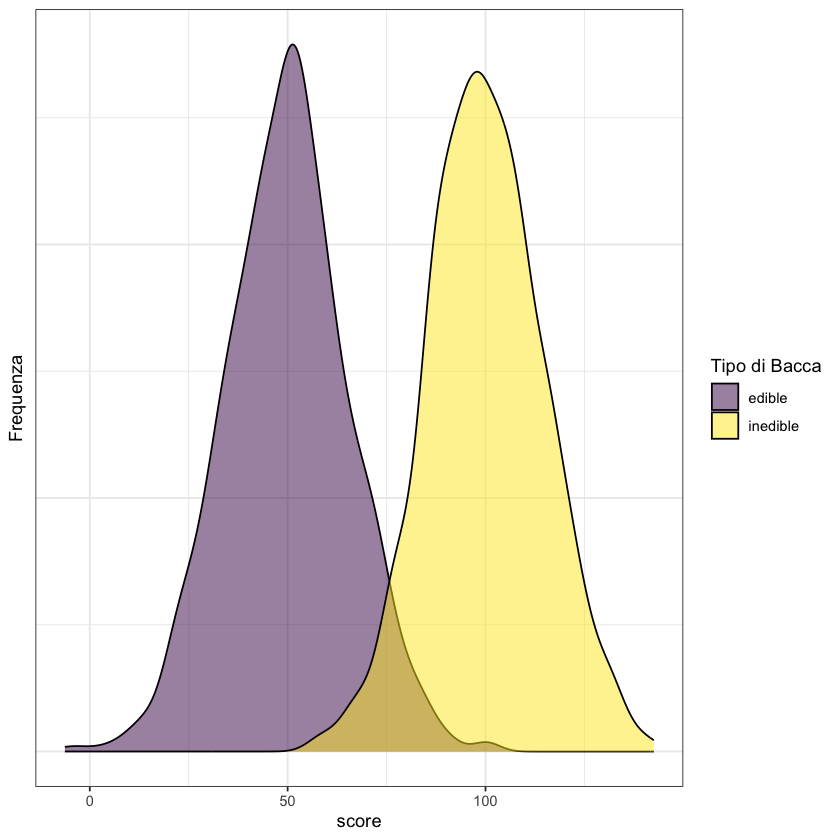

In [14]:
ggplot(data = edibleData, aes(x = score, ymin = 0, fill = type)) +
    geom_density(alpha = .5) +
    scale_fill_manual(name = "Tipo di Bacca", values = c(viridis(2)[1], viridis(2)[2])) +
    scale_y_continuous(name = "Frequenza") 

La Figura mostra le distribuzioni dei punteggi in base al tipo di bacca con un cutoff. La linea rossa indica il cutoff: il livello al di sopra del quale le bacche vengono classificate come non commestibili. Ci sono errori su entrambi i lati del cutoff. Sotto il cutoff, ci sono dei falsi negativi (blu): bacche non commestibili erroneamente classificate come commestibili. Sopra il cutoff, ci sono dei falsi positivi (verde): bacche commestibili erroneamente classificate come non commestibili. I costi dei falsi negativi potrebbero includere malattia o morte derivanti dal consumo di bacche non commestibili, mentre i costi dei falsi positivi potrebbero includere maggiore tempo per trovare cibo, insufficienza di cibo e fame.

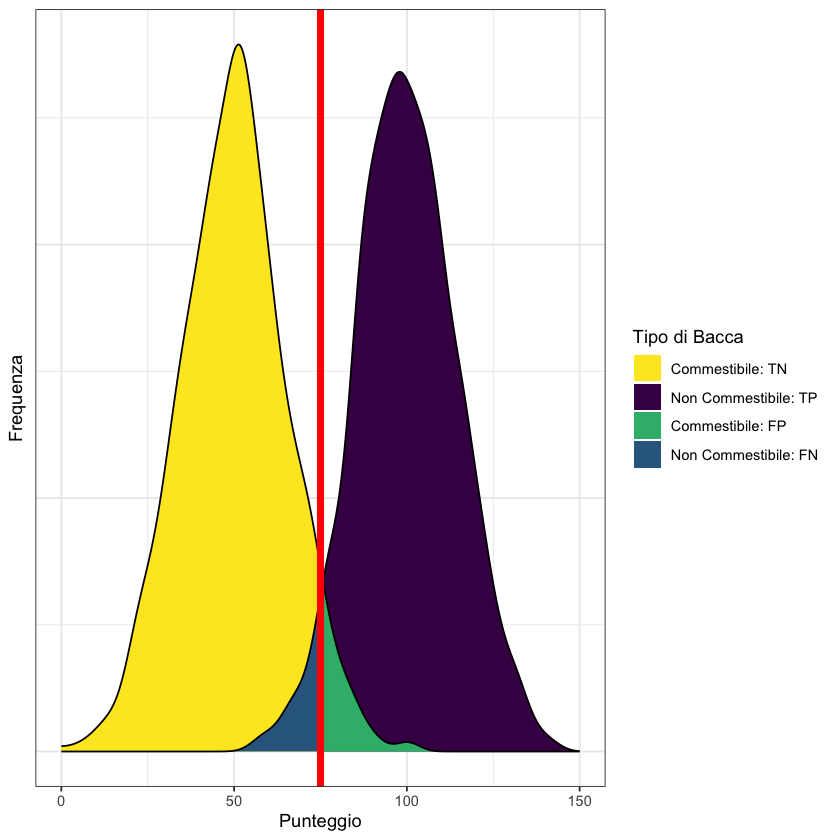

In [15]:
ggplot(data = density_data, aes(x = x, ymin = 0, ymax = y, fill = type)) +
    geom_ribbon(alpha = 1) +
    scale_fill_manual(
        name = "Tipo di Bacca",
        values = c(viridis(4)[4], viridis(4)[1], viridis(4)[3], viridis(4)[2]),
        breaks = c("edible_TN", "inedible_TP", "edible_FP", "inedible_FN"),
        labels = c("Commestibile: TN", "Non Commestibile: TP", "Commestibile: FP", "Non Commestibile: FN")
    ) +
    geom_line(aes(y = y)) +
    geom_vline(xintercept = cutoff, color = "red", linewidth = 2) +
    scale_x_continuous(name = "Punteggio") +
    scale_y_continuous(name = "Frequenza") 

A seconda dei nostri obiettivi di valutazione, potremmo voler usare un diverso rapporto di selezione modificando il cutoff. La Figura  mostra le distribuzioni dei punteggi quando si aumenta il cutoff. Ora ci sono più falsi negativi (blu) e meno falsi positivi (verde). Se alziamo il cutoff per essere più conservativi, il numero di falsi negativi aumenta, mentre il numero di falsi positivi diminuisce. Di conseguenza, aumentando il cutoff, la sensibilità e il valore predittivo negativo (NPV) diminuiscono, mentre la specificità e il valore predittivo positivo (PPV) aumentano. Un cutoff più alto potrebbe essere ottimale se i costi dei falsi positivi sono considerati superiori a quelli dei falsi negativi. Ad esempio, se gli alieni non possono rischiare di mangiare bacche non commestibili perché sono fatali, e ci sono abbastanza bacche commestibili per nutrire la colonia aliena.

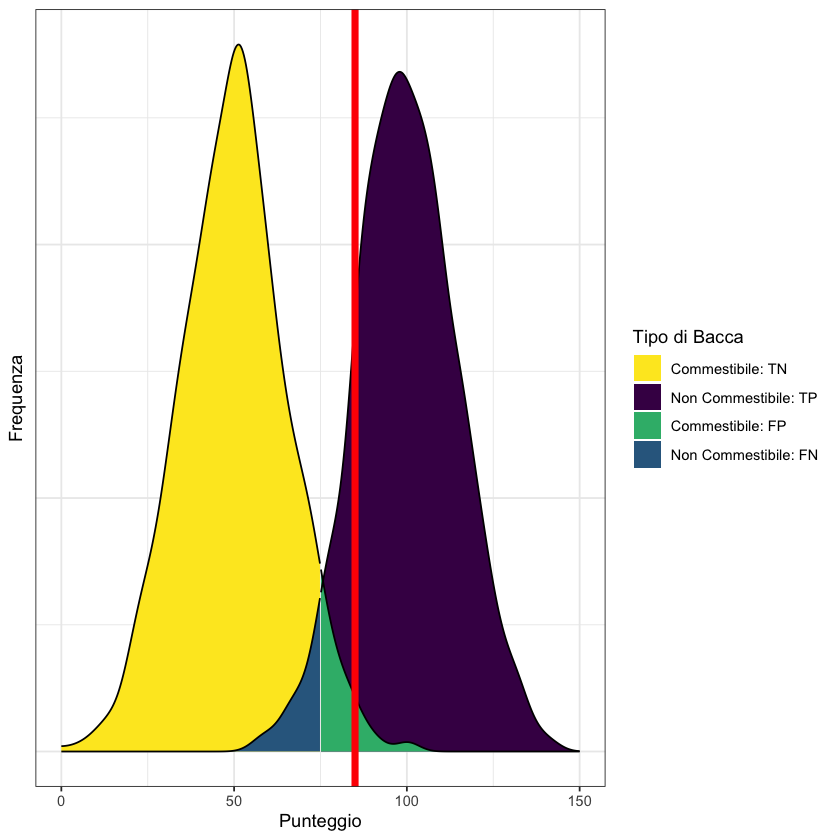

In [16]:
# Raise the cutoff
cutoff <- 85

ggplot(data = density_data, aes(x = x, ymin = 0, ymax = y, fill = type)) +
    geom_ribbon(alpha = 1) +
    scale_fill_manual(
        name = "Tipo di Bacca",
        values = c(viridis(4)[4], viridis(4)[1], viridis(4)[3], viridis(4)[2]),
        breaks = c("edible_TN", "inedible_TP", "edible_FP", "inedible_FN"),
        labels = c("Commestibile: TN", "Non Commestibile: TP", "Commestibile: FP", "Non Commestibile: FN")
    ) +
    geom_line(aes(y = y)) +
    geom_vline(xintercept = cutoff, color = "red", linewidth = 2) +
    scale_x_continuous(name = "Punteggio") +
    scale_y_continuous(name = "Frequenza") +
    theme_bw() +
    theme(
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    )

In alternativa, possiamo abbassare il cutoff per essere più liberali. La Figura  mostra le distribuzioni dei punteggi quando abbassiamo il cutoff. Ora ci sono meno falsi negativi (blu) e più falsi positivi (verde). Abbassando il cutoff, la sensibilità e il NPV aumentano, mentre la specificità e il PPV diminuiscono. Un cutoff più basso potrebbe essere ottimale se i costi dei falsi negativi sono considerati superiori a quelli dei falsi positivi. Ad esempio, se gli alieni non possono rischiare di perdere bacche commestibili perché sono scarse, e mangiare bacche non commestibili comporta solo disagi temporanei.

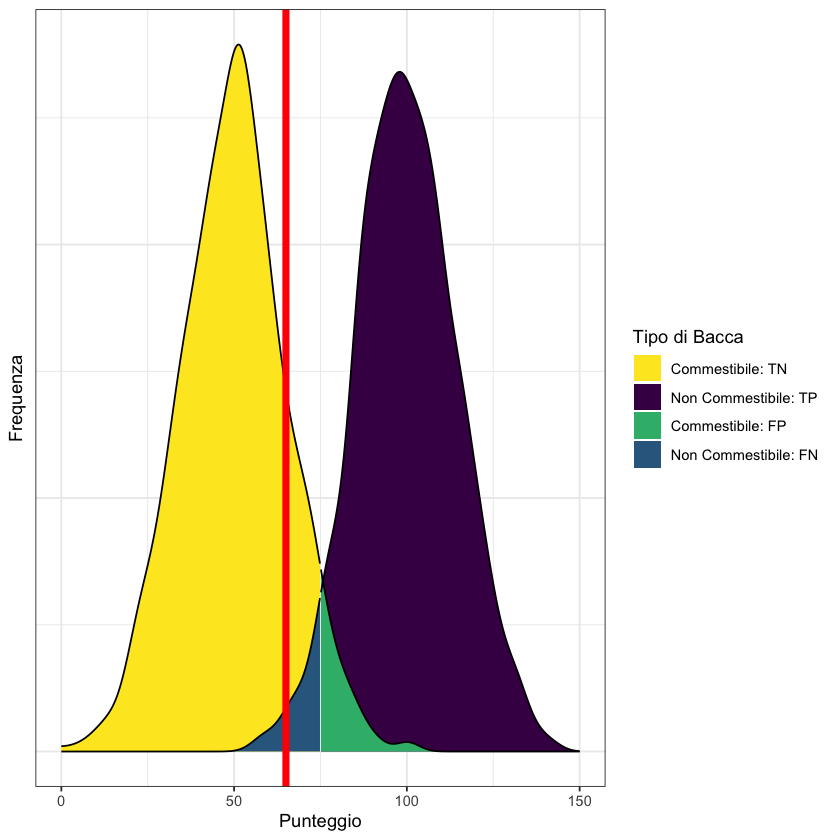

In [17]:
# Lower the cutoff
cutoff <- 65

ggplot(data = density_data, aes(x = x, ymin = 0, ymax = y, fill = type)) +
    geom_ribbon(alpha = 1) +
    scale_fill_manual(
        name = "Tipo di Bacca",
        values = c(viridis(4)[4], viridis(4)[1], viridis(4)[3], viridis(4)[2]),
        breaks = c("edible_TN", "inedible_TP", "edible_FP", "inedible_FN"),
        labels = c("Commestibile: TN", "Non Commestibile: TP", "Commestibile: FP", "Non Commestibile: FN")
    ) +
    geom_line(aes(y = y)) +
    geom_vline(xintercept = cutoff, color = "red", linewidth = 2) +
    scale_x_continuous(name = "Punteggio") +
    scale_y_continuous(name = "Frequenza") +
    theme_bw() +
    theme(
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    )

In sintesi, sensibilità e specificità variano in base al cutoff utilizzato per la classificazione. Se aumentiamo il cutoff, la specificità e il PPV aumentano, mentre la sensibilità e il NPV diminuiscono. Se abbassiamo il cutoff, la sensibilità e il NPV aumentano, mentre la specificità e il PPV diminuiscono. Pertanto, il cutoff ottimale dipende dai costi associati ai falsi negativi e ai falsi positivi. Se i falsi negativi sono più costosi, dovremmo impostare un cutoff basso; se i falsi positivi sono più costosi, dovremmo impostare un cutoff alto.

## Teoria del Rilevamento del Segnale

La *teoria del rilevamento del segnale* (Signal Detection Theory, SDT) è una teoria probabilistica utilizzata per il rilevamento di uno stimolo (segnale) all'interno di un insieme di stimoli che include anche stimoli non target (rumore). La SDT è nata durante lo sviluppo del radar (**RA**dio **D**etection **A**nd **R**anging) e del sonar (**SO**und **N**avigation **A**nd **R**anging) durante la Seconda Guerra Mondiale, basandosi su ricerche in ambito sensoriale-percettivo. Il settore militare desiderava determinare quali oggetti rilevati da radar/sonar fossero effettivamente aerei o sottomarini nemici, e quali fossero solo rumore (ad esempio, oggetti diversi nell'ambiente o persino condizioni meteorologiche).

La SDT ha permesso di valutare il numero di errori commessi dagli operatori (cioè, quanto fossero precisi) e di scomporre tali errori in diverse categorie. La teoria distingue tra *sensibilità* e *bias*. Nella SDT, la *sensibilità* (o discriminabilità) è la capacità di un test di distinguere tra uno stimolo target e stimoli non target, ossia quanto bene il test riesca a rilevare il segnale tra i rumori. Il *bias* rappresenta invece la tendenza del test a sovrastimare o sottostimare la probabilità di un evento target rispetto al tasso reale di occorrenza di tale evento.

Alcuni operatori radar/sonar non erano molto sensibili alla differenza tra segnale e rumore, a causa di fattori come l'età o la capacità di distinguere sottili variazioni di segnale. Gli individui con bassa sensibilità, che quindi non riuscivano a distinguere efficacemente tra segnale e rumore, venivano esclusi, poiché la sensibilità era considerata una competenza difficilmente insegnabile. Altri operatori, pur avendo una buona sensibilità, mostravano bias sistematici o scarsa *calibrazione*, cioè commettevano errori sistematici nel giudicare i segnali, ad esempio sovra-rifiutando o sotto-rifiutando gli stimoli. 

Sovra-rifiutare significa produrre molti *falsi negativi* (cioè, giudicare un segnale sicuro quando in realtà non lo è), mentre sotto-rifiutare genera molti *falsi positivi* (cioè, giudicare un segnale come pericoloso quando in realtà non lo è). Un operatore con buona sensibilità ma bias sistematico veniva considerato più facile da addestrare rispetto a chi aveva una bassa sensibilità. Gli operatori radar e sonar venivano quindi selezionati in base alla loro sensibilità nel distinguere tra segnale e rumore, e poi addestrati per migliorare la calibrazione e ridurre il bias sistematico, evitando così di sovra- o sotto-rifiutare gli stimoli.

Anche se la SDT è stata sviluppata inizialmente durante la Seconda Guerra Mondiale, oggi ha un ruolo importante in molti ambiti della scienza e della medicina. Un esempio in medicina è il rilevamento di tumori nella radiologia. La SDT è fondamentale anche in psicologia, specialmente nella psicologia cognitiva. Ad esempio, ricerche sulla percezione sociale hanno dimostrato che gli uomini tendono a mostrare una scarsa sensibilità nel distinguere le manifestazioni di interesse sessuale nelle donne, confondendo la cordialità con l'interesse sessuale. Inoltre, gli uomini tendono ad avere un bias sistematico, sovrastimando l'interesse sessuale delle donne nei loro confronti, mostrando così una soglia troppo bassa nel giudicare tali segnali.

Le metriche SDT di sensibilità includono [$d'$](#dPrimeSDT) (d-prime), [$A$](#aSDT) (o $A'$), e l'area sotto la curva ROC (Receiver Operating Characteristic). Le metriche di bias includono [$\beta$](#betaSDT), [$c$](#cSDT) e [$b$](#bSDT).


Curva ROC (Receiver Operating Characteristic)
L'asse delle x della curva ROC rappresenta il tasso di falsi allarmi o tasso di falsi positivi ($1 -$ specificità). L'asse delle y rappresenta il tasso di successi o tasso di veri positivi (sensibilità). La curva ROC traccia la combinazione tra sensibilità e specificità per ogni possibile valore di cutoff.

Iniziamo con un cutoff pari a zero (in alto a destra sulla curva ROC). In questo caso, la sensibilità è pari a 1.0 e la specificità è 0, e il punto corrispondente viene tracciato sulla curva. Con un cutoff di zero, il test decide di agire su ogni stimolo (quindi il test è estremamente liberale). Aumentiamo progressivamente il cutoff e tracciamo la sensibilità e la specificità a ogni valore di cutoff. All'aumentare del cutoff, la sensibilità diminuisce e la specificità aumenta.

Terminiamo con il valore di cutoff più alto possibile, dove la sensibilità è pari a 0 e la specificità è 1.0 (in altre parole, il test non agisce mai; quindi è il massimo della conservatività). Ogni punto sulla curva ROC corrisponde a una coppia di tasso di successi (sensibilità) e tasso di falsi allarmi (falsi positivi) risultante da uno specifico valore di cutoff. Dopodiché, possiamo collegare i punti con delle linee o curve per ottenere la curva ROC.

La Figura @ref(fig
) rappresenta un esempio empirico di curva ROC, dove le linee connettono i tassi di successi e di falsi allarmi.

Setting levels: control = Good, case = Poor



Setting direction: controls < cases



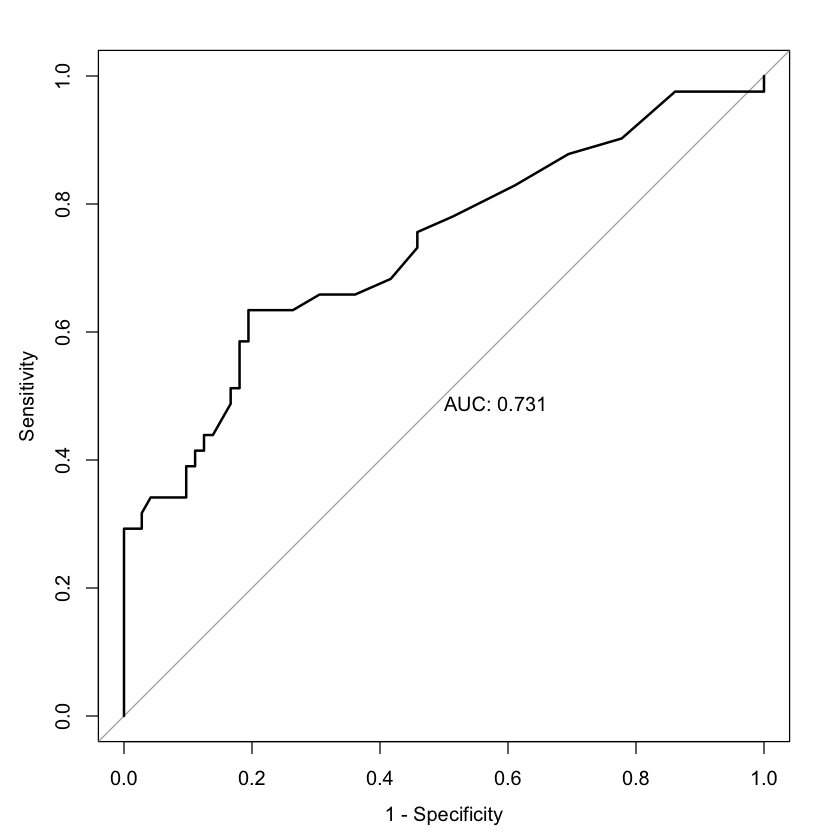

In [19]:
plot(roc(aSAH$outcome, aSAH$s100b), legacy.axes = TRUE, print.auc = TRUE)

La Figura seguente mostra invece una curva ROC lisciata, dove è stata tracciata una curva continua e adattata per connettere i tassi di successi e di falsi allarmi.

Setting levels: control = Good, case = Poor

Setting direction: controls < cases



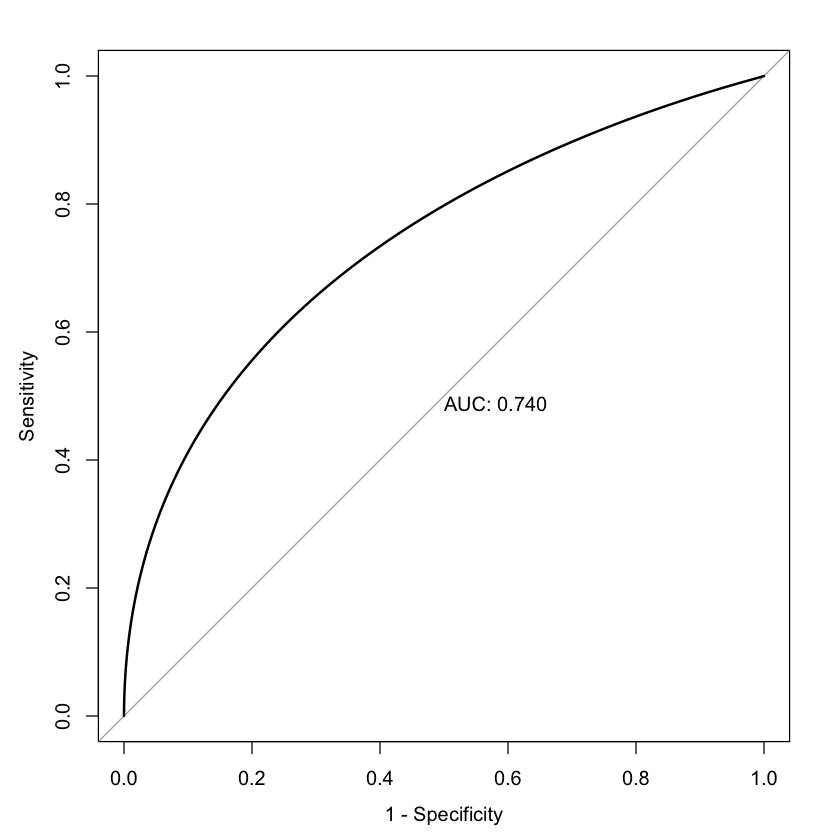

In [21]:
plot(roc(aSAH$outcome, aSAH$s100b, smooth = TRUE), legacy.axes = TRUE, print.auc = TRUE)

## Area Sotto la Curva ROC (AUC)

Le metodologie ROC possono essere utilizzate per confrontare e calcolare il potere discriminativo degli strumenti di misurazione, senza essere influenzati da fattori come il selection ratio, il base rate e i costi e benefici associati. L'analisi ROC fornisce un indice quantitativo di quanto bene uno strumento possa prevedere un segnale di interesse o discriminare tra segnali diversi. Questo approccio ci aiuta a capire con quale frequenza la nostra valutazione è corretta.

Se scegliamo casualmente due osservazioni, e una è corretta mentre l'altra è sbagliata, la precisione sarebbe del 50%, ma questo rifletterebbe una risposta casuale, quindi inutile. L'area geometrica sotto la curva ROC riflette l'accuratezza discriminativa della misura. Questo indice è noto come AUC (Area Under the Curve) della curva ROC. AUC quantifica il potere discriminativo di un test. Più precisamente, AUC rappresenta la probabilità che, selezionando casualmente un target e un non-target, il test classifichi correttamente il target come tale. I valori dell'AUC variano da 0.0 a 1.0, dove 0.5 rappresenta la precisione casuale, come indicato dalla linea diagonale nella curva ROC. Un test è utile nella misura in cui la sua curva ROC si trova sopra la linea diagonale, indicando che la sua accuratezza discriminativa è superiore al caso.

Setting levels: control = Good, case = Poor

Setting direction: controls < cases



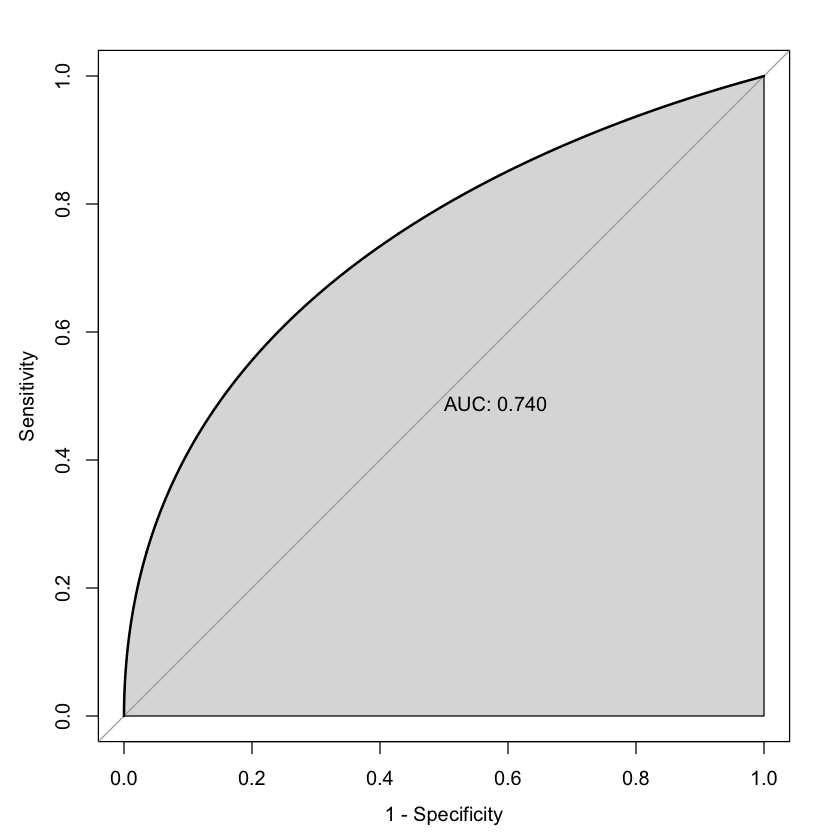

In [23]:
plot(roc(aSAH$outcome, aSAH$s100b, smooth = TRUE), legacy.axes = TRUE, print.auc = TRUE, auc.polygon = TRUE)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



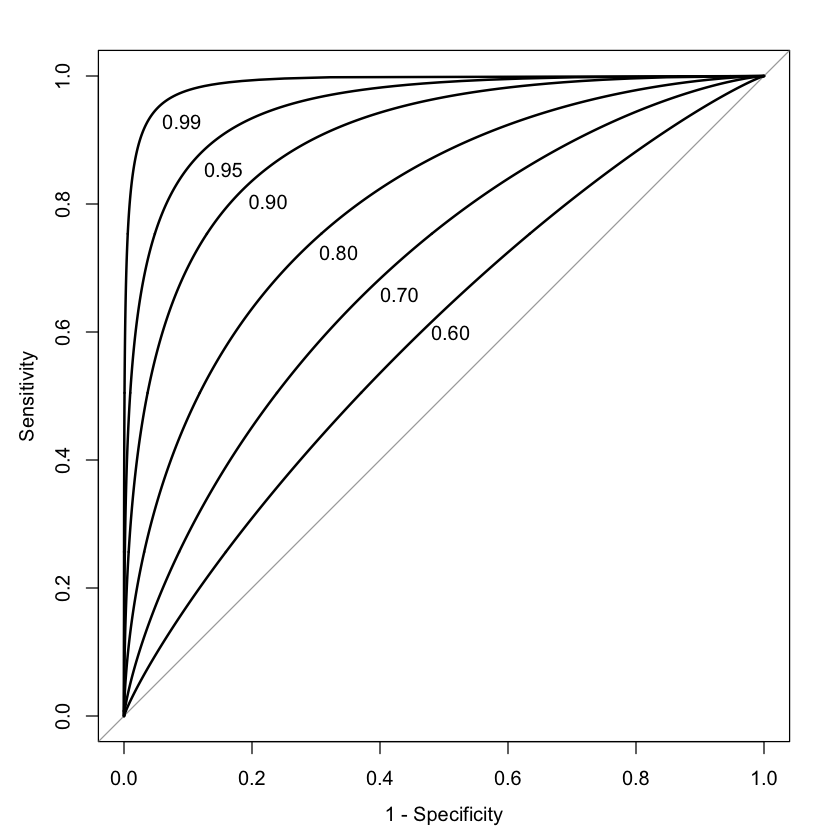

In [25]:
# Simulazione dei dati per AUC
simulateDataFromAUC <- function(auc, n) {
    t <- sqrt(log(1 / (1 - auc)**2))
    z <- t - ((2.515517 + 0.802853 * t + 0.0103328 * t**2) / (1 + 1.432788 * t + 0.189269 * t**2 + 0.001308 * t**3))
    d <- z * sqrt(2)

    x <- c(rnorm(n / 2, mean = 0), rnorm(n / 2, mean = d))
    y <- c(rep(0, n / 2), rep(1, n / 2))

    data <- data.frame(x = x, y = y)

    return(data)
}

set.seed(52242)

auc60 <- simulateDataFromAUC(.60, 50000)
auc70 <- simulateDataFromAUC(.70, 50000)
auc80 <- simulateDataFromAUC(.80, 50000)
auc90 <- simulateDataFromAUC(.90, 50000)
auc95 <- simulateDataFromAUC(.95, 50000)
auc99 <- simulateDataFromAUC(.99, 50000)

plot(roc(y ~ x, auc60, smooth = TRUE), legacy.axes = TRUE, print.auc = TRUE, print.auc.x = .52, print.auc.y = .61, print.auc.pattern = "%.2f")
plot(roc(y ~ x, auc70, smooth = TRUE), legacy.axes = TRUE, print.auc = TRUE, print.auc.x = .6, print.auc.y = .67, print.auc.pattern = "%.2f", add = TRUE)
plot(roc(y ~ x, auc80, smooth = TRUE), legacy.axes = TRUE, print.auc = TRUE, print.auc.x = .695, print.auc.y = .735, print.auc.pattern = "%.2f", add = TRUE)
plot(roc(y ~ x, auc90, smooth = TRUE), legacy.axes = TRUE, print.auc = TRUE, print.auc.x = .805, print.auc.y = .815, print.auc.pattern = "%.2f", add = TRUE)
plot(roc(y ~ x, auc95, smooth = TRUE), legacy.axes = TRUE, print.auc = TRUE, print.auc.x = .875, print.auc.y = .865, print.auc.pattern = "%.2f", add = TRUE)
plot(roc(y ~ x, auc99, smooth = TRUE), legacy.axes = TRUE, print.auc = TRUE, print.auc.x = .94, print.auc.y = .94, print.auc.pattern = "%.2f", add = TRUE)


Ad esempio, se l'AUC è pari a 0.75, ciò significa che il punteggio complessivo di un individuo che possiede la caratteristica in questione sarà più alto nel 75% dei casi rispetto a quello di un individuo che non la possiede. In termini più semplici, l'AUC fornisce la probabilità che lo strumento classifichi correttamente, se scegliamo casualmente un esito positivo e uno negativo.

L'AUC è un indice più robusto rispetto alla percentuale di accuratezza perché la percentuale di accuratezza può essere influenzata da fattori come il base rate. L'AUC misura quanto un test è migliore del caso nel discriminare tra esiti diversi. Inoltre, è utile come indicatore generale di accuratezza discriminativa, poiché mostra quanto un test sia accurato su tutti i possibili cutoff.

Anche se conoscere l'accuratezza del test a ogni cutoff può essere utile per selezionare il cutoff ottimale, nella realtà non siamo interessati a tutti i possibili cutoff, poiché non tutti gli errori hanno lo stesso costo.

Iniziare {#gettingStarted-prediction}

Caricare le Librerie {#loadLibraries-prediction}

Preparare i Dati {#prepareData-prediction}
Caricamento dei Dati {#loadData-prediction}

Il dataset aSAH del pacchetto pROC contiene i punteggi dei test (s100b) e gli esiti clinici (outcome) di pazienti.

In [6]:
data(aSAH)
mydataSDT <- aSAH

Per garantire la riproducibilità, imposto il seed qui sotto. L'utilizzo dello stesso seed garantirà gli stessi risultati ogni volta. Non c'è nulla di speciale in questo seed specifico.

In [7]:
set.seed(52242)

mydataSDT$testScore <- mydataSDT$s100b
mydataSDT <- mydataSDT %>%
    mutate(testScoreSimple = ntile(testScore, 10))

mydataSDT$predictedProbability <-
    (mydataSDT$s100b - min(mydataSDT$s100b, na.rm = TRUE)) /
        (max(mydataSDT$s100b, na.rm = TRUE) - min(mydataSDT$s100b, na.rm = TRUE))
mydataSDT$continuousOutcome <- mydataSDT$testScore +
    rnorm(nrow(mydataSDT), mean = 0.20, sd = 0.20)
mydataSDT$disorder <- NA
mydataSDT$disorder[mydataSDT$outcome == "Good"] <- 0
mydataSDT$disorder[mydataSDT$outcome == "Poor"] <- 1


La curva ROC (Receiver Operating Characteristic) mostra la combinazione tra il tasso di successo (o sensibilità) e il tasso di falsi allarmi ($1 - \text{specificità}$) per ogni possibile soglia di cutoff. La curva dimostra come, all'aumentare della soglia (diventando più conservativa), la sensibilità diminuisce e la specificità aumenta, e viceversa.

Le curve ROC possono essere generate utilizzando il pacchetto pROC, e gli esempi mostrano che la misura ha un'accuratezza moderata—è più accurata del caso, ma c'è margine di miglioramento.

Curva ROC Empirica {#empiricalROC}
Il codice per generare una curva ROC empirica è mostrato qui sotto, e il grafico è visibile in Figura @ref(fig

In [9]:
rocCurve <- roc(data = mydataSDT, response = disorder, predictor = testScore, smooth = FALSE)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



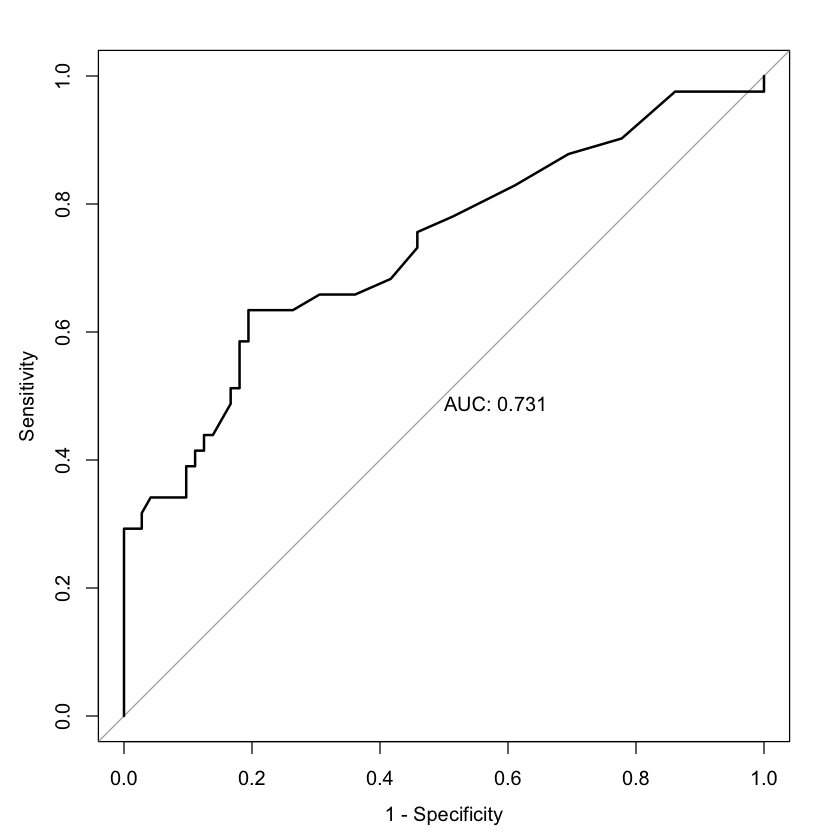

In [10]:
plot(rocCurve, legacy.axes = TRUE, print.auc = TRUE)

Una curva ROC empirica con i cutoff sovrapposti è mostrata 

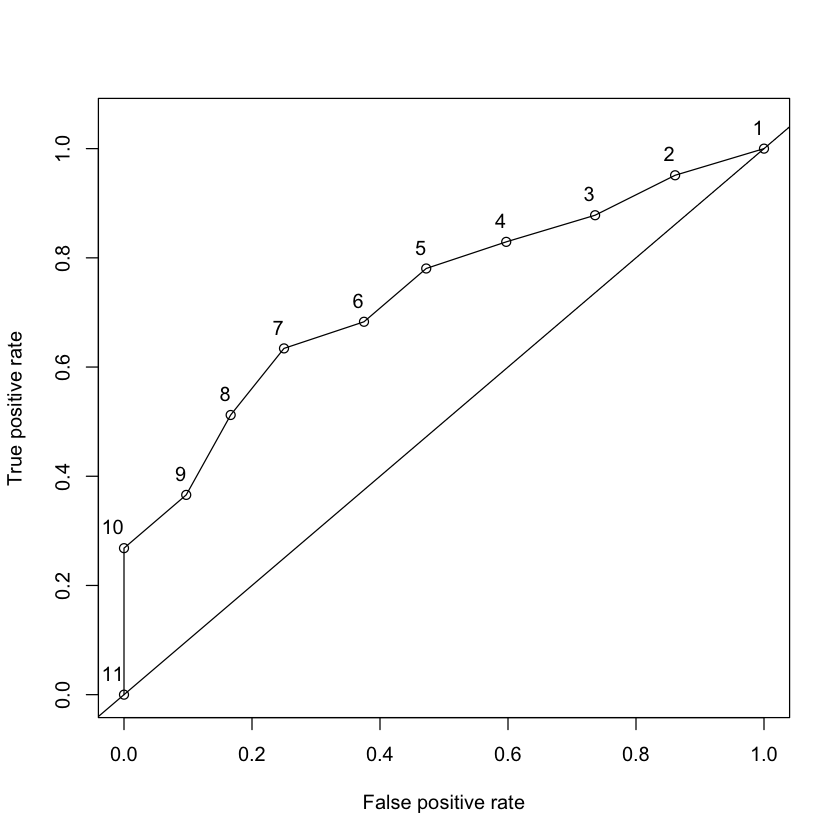

In [11]:
pred <- prediction(
    na.omit(mydataSDT[, c("testScoreSimple", "disorder")])$testScoreSimple,
    na.omit(mydataSDT[, c("testScoreSimple", "disorder")])$disorder
)
perf <- performance(pred, "tpr", "fpr")
plot(perf, print.cutoffs.at = 1:11, text.adj = c(1, -1), ylim = c(0, 1.05))
abline(coef = c(0, 1))

Curva ROC Liscia si ottiene nel modo seguente.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



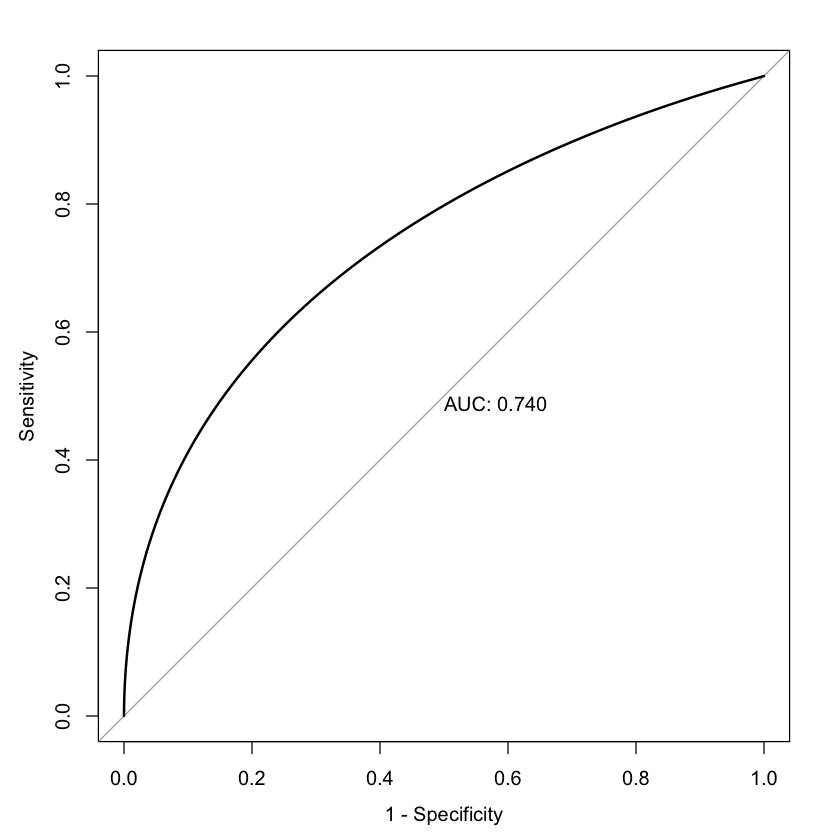

In [13]:
rocCurveSmooth <- roc(data = mydataSDT, response = disorder, predictor = testScore, smooth = TRUE)
plot(rocCurveSmooth, legacy.axes = TRUE, print.auc = TRUE)

Statistica di Youden J {#youdenJ}
La soglia della statistica di Youden J è il punto in cui il test ha la massima combinazione (somma) di sensibilità e specificità: $\text{max}(\text{sensitivity} + \text{specificity} - 1)$.

In [14]:
youdenJ <- coords(rocCurve, x = "best", best.method = "youden")
youdenJthreshold <- youdenJ$threshold
youdenJspecificity <- youdenJ$specificity
youdenJsensitivity <- youdenJ$sensitivity

youdenJ

threshold,specificity,sensitivity
<dbl>,<dbl>,<dbl>
0.205,0.8055556,0.6341463


Per questo test, la soglia ottimale secondo la statistica di Youden J è $r youdenJthreshold$, con una sensibilità di $r youdenJsensitivity$ e una specificità di $r youdenJspecificity$.

Punto più vicino alla parte in alto a sinistra della curva ROC {#topLeftROC}
Il punto più vicino alla parte superiore sinistra della curva ROC, dove sensibilità e specificità sono perfette, è dato da: $\text{min}[(1 - \text{sensitivity})^2 + (1 - \text{specificity})^2]$.

In [15]:
closestTopLeft <- coords(rocCurve, x = "best", best.method = "closest.topleft")
closestTopLeftthreshold <- closestTopLeft$threshold
closestTopLeftspecificity <- closestTopLeft$specificity
closestTopLeftsensitivity <- closestTopLeft$sensitivity

closestTopLeft


threshold,specificity,sensitivity
<dbl>,<dbl>,<dbl>
0.205,0.8055556,0.6341463


Per questo test, la combinazione di sensibilità e specificità è ottimale alla soglia di $r closestTopLeftthreshold$, con una sensibilità di $r closestTopLeftsensitivity$ e una specificità di $r closestTopLeftspecificity$.

## Accuratezza della Predizione attraverso i Cutoff {#predictionAccuracy}

Esistono due dimensioni principali dell'accuratezza: (1) la *discriminazione* (ad esempio, [sensibilità](#sensitivity), [specificità](#specificity), [area sotto la curva ROC](#auc)) e (2) la *calibrazione*. Alcuni indici generali di accuratezza combinano la discriminazione e la calibrazione.

Il pacchetto [`petersenlab`](https://github.com/DevPsyLab/petersenlab) include la funzione `accuracyOverall()`, che stima l'accuratezza della predizione su tutti i cutoff.\index{petersenlab package}\index{cutoff}

Ecco un esempio di codice che utilizza questa funzione:

In [18]:
accuracyOverall(
    predicted = mydataSDT$testScore,
    actual = mydataSDT$disorder
) %>%
    t() %>%
    round(., 2)

accuracyOverall(
    predicted = mydataSDT$testScore,
    actual = mydataSDT$disorder,
    dropUndefined = TRUE
) %>%
    t() %>%
    round(., 2)

ME,-0.12
MAE,0.34
MSE,0.21
RMSE,0.46
MPE,-Inf
MAPE,Inf
sMAPE,82.72
MASE,0.74
RMSLE,0.30
rsquared,0.17
rsquaredAdj,0.17


ME,-0.12
MAE,0.34
MSE,0.21
RMSE,0.46
MPE,60.29
MAPE,65.51
sMAPE,82.72
MASE,0.74
RMSLE,0.30
rsquared,0.17
rsquaredAdj,0.17


In questo esempio, la funzione `accuracyOverall()` calcola l'accuratezza complessiva della predizione su tutta la gamma di cutoff disponibili, fornendo una sintesi del grado di accuratezza globale del modello.

## Calibrazione {#calibration}

Quando si tratta di un risultato categorico, la calibrazione è il grado in cui una stima probabilistica di un evento riflette la reale probabilità sottostante di quell'evento.\index{calibration}  
Quando si tratta di un risultato continuo, la calibrazione indica quanto i valori previsti siano vicini ai valori effettivi osservati.\index{calibration}  
L'importanza di esaminare la calibrazione, oltre alla *discriminazione*, è descritta da Lindhiem (2020).\index{calibration}\index{discrimination}

La calibrazione è diventata centrale nella valutazione dell'accuratezza delle previsioni meteorologiche.\index{calibration}  
Ad esempio, nei giorni in cui un meteorologo prevede il 60% di possibilità di pioggia, dovrebbe effettivamente piovere circa il 60% delle volte.  
Grazie ai progressi nella comprensione scientifica dei sistemi meteorologici, le previsioni della pioggia sono diventate più accurate.  
Le previsioni della National Weather Service, per esempio, sono ben calibrate.  
Tuttavia, le previsioni di pioggia fatte da meteorologi televisivi locali possono essere esagerate per aumentare l'audience (Silver, 2012).  
Curiosamente, alcune previsioni di pioggia di The Weather Channel risultano miscalibrate in certe condizioni (Bickel, 2008).  
Ad esempio, nei giorni in cui viene prevista una probabilità di pioggia del 20%, la probabilità reale è in realtà intorno al 5%.  
Questa miscalibrazione è deliberata, poiché le persone tendono a essere più arrabbiate se viene detto loro che non pioverà e invece piove (falsi negativi) rispetto al contrario (falsi positivi).\index{calibration}\index{false negative}\index{false positive}  
Come osserva Silver (2012), "Se piove quando non dovrebbe, le persone si arrabbiano con il meteorologo, mentre una giornata inaspettatamente soleggiata è vista come un bonus fortuito."

La calibrazione non è importante solo per le previsioni meteorologiche, ma anche per la valutazione psicologica.  
Esistono diversi metodi per esaminare la calibrazione, come i *Brier Scores*, il test di Hosmer-Lemeshow, lo *z* di Spiegelhalter e la differenza media tra i valori previsti e osservati a diversi intervalli di soglie, rappresentata graficamente tramite un *calibration plot*.

### Calibration Plot {#calibrationPlot}

Un *calibration plot* può aiutare a individuare la miscalibrazione.  
Questo grafico rappresenta la probabilità prevista di un evento sull'asse x e la probabilità effettiva osservata sull'asse y.  
Le previsioni sono suddivise in gruppi (spesso 10).  
La linea diagonale rappresenta previsioni perfettamente calibrate.  
Quando le previsioni si discostano da questa linea, indicano miscalibrazione.  
Esistono quattro pattern generali di miscalibrazione: *overextremity*, *underextremity*, *overprediction*, e *underprediction*.

- *Overextremity* si verifica quando le probabilità previste sono troppo vicine agli estremi (zero o uno).  
- *Underextremity* accade quando le probabilità previste sono troppo lontane dagli estremi.  
- *Overprediction* si ha quando le probabilità previste sono costantemente maggiori di quelle osservate.  
- *Underprediction* si ha quando le probabilità previste sono costantemente minori di quelle osservate.

Per generare un *calibration plot*, possiamo utilizzare il pacchetto `PredictABEL`. Di seguito è riportato un esempio di codice in R per creare questo grafico:

In [23]:
data(aSAH)
mydataSDT <- aSAH

set.seed(52242)

mydataSDT$testScore <- mydataSDT$s100b
mydataSDT <- mydataSDT %>%
    mutate(testScoreSimple = ntile(testScore, 10))

mydataSDT$predictedProbability <-
    (mydataSDT$s100b - min(mydataSDT$s100b, na.rm = TRUE)) /
        (max(mydataSDT$s100b, na.rm = TRUE) - min(mydataSDT$s100b, na.rm = TRUE))
mydataSDT$continuousOutcome <- mydataSDT$testScore +
    rnorm(nrow(mydataSDT), mean = 0.20, sd = 0.20)
mydataSDT$disorder <- NA
mydataSDT$disorder[mydataSDT$outcome == "Good"] <- 0
mydataSDT$disorder[mydataSDT$outcome == "Poor"] <- 1

colNumberOutcome <- which(names(mydataSDT) == "disorder")
myDataNoMissing <- na.omit(mydataSDT)

,total,meanpred,meanobs,predicted,observed
"[0.0000,0.0245)",20,0.013,0.200,0.26,4
0.0245,7,0.025,0.143,0.17,1
0.0294,8,0.029,0.250,0.24,2
"[0.0343,0.0441)",14,0.036,0.214,0.50,3
"[0.0441,0.0588)",11,0.051,0.364,0.56,4
"[0.0588,0.0686)",8,0.061,0.125,0.49,1
"[0.0686,0.1324)",12,0.094,0.417,1.12,5
"[0.1324,0.2059)",12,0.165,0.583,1.98,7
"[0.2059,0.2598)",10,0.222,0.300,2.22,3
"[0.2598,1.0000]",11,0.408,1.000,4.49,11


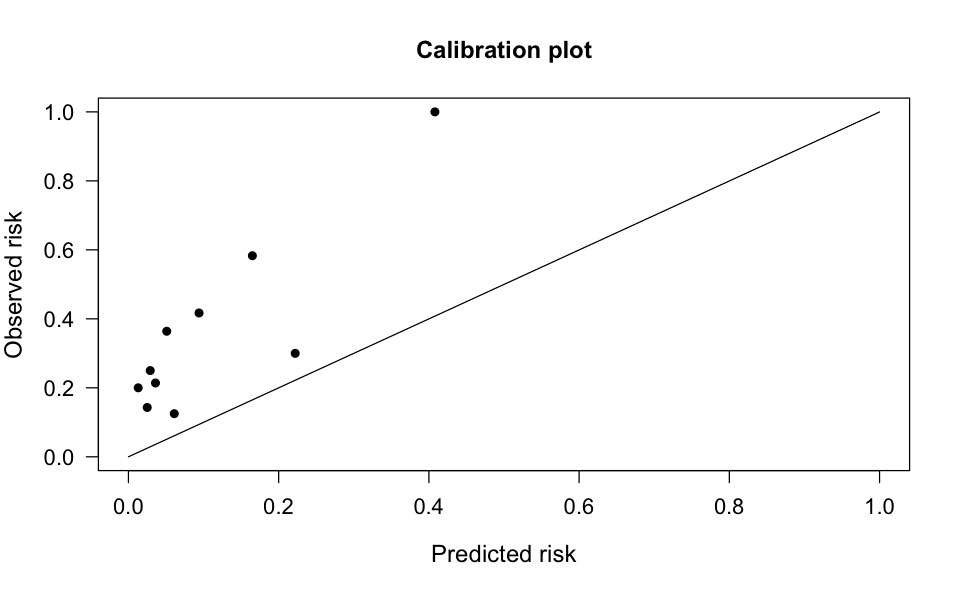

In [25]:
plotCalibration(
    data = na.omit(myDataNoMissing),
    cOutcome = colNumberOutcome,
    predRisk = myDataNoMissing$predictedProbability,
    groups = 10
)

Questo *calibration plot* mostra che le probabilità previste erano consistentemente inferiori a quelle effettive osservate, suggerendo un problema di *underprediction*.  
Per correggere questa miscalibrazione, le probabilità previste dovrebbero essere aumentate affinché risultino coerenti con quelle osservate.

#### Brier Scores {#brierScores}

I punteggi di Brier (*Brier scores*) sono stati calcolati utilizzando il pacchetto `rms` [@R-rms].  
Valori più bassi indicano una maggiore accuratezza della calibrazione.\index{Brier scores}\index{calibration}  
Il punteggio di Brier misura la qualità delle previsioni probabilistiche confrontando la previsione con il risultato effettivo. Viene calcolato come la media dei quadrati delle differenze tra le probabilità previste e i risultati osservati. Questo punteggio tiene conto sia degli errori di sovrastima che di sottostima, fornendo una valutazione complessiva della calibrazione delle previsioni.

Un punteggio di Brier pari a 0 indica una perfetta calibrazione, mentre valori più vicini a 1 indicano una calibrazione molto scarsa.

Ecco un esempio di come calcolare i punteggi di Brier in R:

In [26]:
val.prob(
    mydataSDT$predictedProbability,
    mydataSDT$disorder,
    pl = FALSE
)["Brier"]

Warning message in val.prob(mydataSDT$predictedProbability, mydataSDT$disorder, :
"2 observations deleted from logistic calibration due to probs. of 0 or 1"


Brier 
0.2612129

In questo esempio, il valore del punteggio di Brier riflette la discrepanza tra le probabilità previste e i risultati effettivi. Minore è il valore del punteggio di Brier, maggiore è la precisione della calibrazione delle previsioni.

## Matrice di Confusione 

Una matrice di confusione (detta anche tabella 2x2 di accuratezza, tabella di cross-tabulation o tabella di contingenza) è una matrice utilizzata per i dati categoriali che mostra l'esito predetto su una dimensione e l'esito reale (la verità) sull'altra. Se le predizioni e gli esiti sono dicotomici, la matrice di confusione è una matrice 2x2 con due righe e due colonne che rappresentano le quattro possibili combinazioni previste-reali (i cosiddetti outcome decisionali). In questo caso, la matrice di confusione fornisce un conteggio tabellare dei casi corretti (true positives e true negatives) rispetto agli errori (false positives e false negatives).

Conteggio Assoluto {#confusionMatrix-number}

È possibile visualizzare i dati di una matrice di confusione utilizzando il seguente codice:

In [28]:
cutoff <- 0.205

mydataSDT$diagnosis <- NA
mydataSDT$diagnosis[mydataSDT$testScore < cutoff] <- 0
mydataSDT$diagnosis[mydataSDT$testScore >= cutoff] <- 1

mydataSDT$diagnosisFactor <- factor(
    mydataSDT$diagnosis,
    levels = c(1, 0),
    labels = c("Decision: Diagnosis", "Decision: No Diagnosis")
)

mydataSDT$disorderFactor <- factor(
    mydataSDT$disorder,
    levels = c(1, 0),
    labels = c("Truth: Disorder", "Truth: No Disorder")
)

table(mydataSDT$diagnosisFactor, mydataSDT$disorderFactor)

                        
                         Truth: Disorder Truth: No Disorder
  Decision: Diagnosis                 26                 14
  Decision: No Diagnosis              15                 58

Conteggio con Margini Aggiunti {#confusionMatrix-numberMargins}

Per aggiungere i margini ai conteggi assoluti:

In [29]:
addmargins(table(mydataSDT$diagnosisFactor, mydataSDT$disorderFactor))

,Truth: Disorder,Truth: No Disorder,Sum
Decision: Diagnosis,26,14,40
Decision: No Diagnosis,15,58,73
Sum,41,72,113


Per calcolare le proporzioni:

In [30]:
prop.table(table(mydataSDT$diagnosisFactor, mydataSDT$disorderFactor))

                        
                         Truth: Disorder Truth: No Disorder
  Decision: Diagnosis          0.2300885          0.1238938
  Decision: No Diagnosis       0.1327434          0.5132743

Aggiungi i margini alle proporzioni:

In [31]:
addmargins(prop.table(table(mydataSDT$diagnosisFactor, mydataSDT$disorderFactor)))

,Truth: Disorder,Truth: No Disorder,Sum
Decision: Diagnosis,0.2300885,0.1238938,0.3539823
Decision: No Diagnosis,0.1327434,0.5132743,0.6460177
Sum,0.3628319,0.6371681,1.0000000


### True Positives (TP) {#truePositive}

I *true positives* (TP) sono i casi in cui una classificazione positiva (ad esempio, la presenza di un disturbo) è corretta, ovvero il test indica che la classificazione è presente, e lo è davvero. Più alto è il numero di *true positives* rispetto alla dimensione del campione, maggiore è l'accuratezza. La formula per calcolare i *true positives* è:

$$
TP = BR \times SR \times N
$$

Ecco come calcolare i true positives in R:

In [32]:
TPvalue <- length(which(
    mydataSDT$diagnosis == 1 & mydataSDT$disorder == 1
))

TPvalue

[1] 26

### True Negatives (TN) {#trueNegative}

I *true negatives* (TN) sono i casi in cui una classificazione negativa (assenza di disturbo) è corretta, ovvero il test indica che la classificazione non è presente e questa effettivamente non è presente. La formula per calcolare i *true negatives* è:

$$
TN = (1 - BR) \times (1 - SR) \times N
$$

Per calcolare i true negatives in R:

In [33]:
TNvalue <- length(which(
    mydataSDT$diagnosis == 0 & mydataSDT$disorder == 0
))

TNvalue

[1] 58

### False Positives (FP) {#falsePositive}

I *false positives* (FP) sono i casi in cui una classificazione positiva è errata, ovvero il test indica la presenza di un disturbo che in realtà non è presente. Valori più bassi di *false positives* riflettono una maggiore accuratezza. La formula per calcolare i *false positives* è:

$$
FP = (1 - BR) \times SR \times N
$$

Ecco come calcolare i false positives in R:

In [34]:
FPvalue <- length(which(
    mydataSDT$diagnosis == 1 & mydataSDT$disorder == 0
))

FPvalue

[1] 14

### False Negatives (FN) {#falseNegative}

I *false negatives* (FN) sono i casi in cui una classificazione negativa è errata, ovvero il test indica l'assenza di un disturbo che in realtà è presente. Valori più bassi di *false negatives* riflettono una maggiore accuratezza. La formula per calcolare i *false negatives* è:

$$
FN = BR \times (1 - SR) \times N
$$

Per calcolare i false negatives in R:

In [35]:
FNvalue <- length(which(
    mydataSDT$diagnosis == 0 & mydataSDT$disorder == 1
))

FNvalue

[1] 15

### Dimensione del Campione (*N*) {#sampleSize-prediction}

La dimensione del campione può essere calcolata sommando il numero di TP, TN, FP e FN:

In [36]:
sampleSize <- function(TP, TN, FP, FN) {
    value <- TP + TN + FP + FN

    return(value)
}

sampleSize(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue
)

[1] 113





### Selection Ratio (SR) {#selectionRatio}

The selection ratio (SR) is the marginal probability of selection, independent of other things: $P(R_i)$.\index{selection ratio}\index{probability!marginal}
In clinical psychology, the selection ratio is the proportion of people who test positive for the disorder, as in Equation \@ref(eq:selectionRatio):\index{selection ratio}

$$
\begin{aligned}
  \text{SR} &= P(R_i) \\
  &= \frac{\text{TP} + \text{FP}}{N}
\end{aligned}
(\#eq:selectionRatio)
$$

```{r, class.source = "fold-hide"}
selectionRatio <- function(TP, TN, FP, FN){
  N <- TP + TN + FP + FN
  value <- (TP + FP)/N
  
  return(value)
}
```

```{r}
selectionRatio(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
selectionRatioValue <- selectionRatio(TP = TPvalue, TN = TNvalue, FP = FPvalue, FN = FNvalue)
```

### Base Rate (BR) {#pretestProbability}

The [base rate](#baseRate) (BR) of a classification is its [marginal probability](#baseRate), independent of other things: $P(C_i)$.\index{base rate}\index{probability!marginal}
In clinical psychology, the base rate of a disorder is its prevalence in the population, as in Equation \@ref(eq:baseRate).\index{base rate}\index{probability!marginal}
Without additional information, the [base rate](#baseRate) is used as the initial *pretest probability*.\index{base rate}\index{probability!marginal}\index{probability!pretest}

$$
\begin{aligned}
  \text{BR} &= P(C_i) \\
  &= \frac{\text{TP} + \text{FN}}{N}
\end{aligned}
(\#eq:baseRate)
$$

```{r, class.source = "fold-hide"}
baseRate <- function(TP, TN, FP, FN){
  N <- TP + TN + FP + FN
  value <- (TP + FN)/N
  
  return(value)
}
```

```{r}
baseRate(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
baseRateValue <- baseRate(TP = TPvalue, TN = TNvalue, FP = FPvalue, FN = FNvalue)
```

### Pretest Odds {#pretestOdds}

The pretest odds of a classification can be estimated using the pretest probability (i.e., [base rate](#baseRate)).\index{odds!pretest}\index{probability!pretest}
To convert a probability to odds, divide the probability by one minus that probability, as in Equation \@ref(eq:pretestOdds).\index{probability}\index{odds}

$$
\begin{aligned}
  \text{pretest odds} &= \frac{\text{pretest probability}}{1 - \text{pretest probability}} \\
\end{aligned}
(\#eq:pretestOdds)
$$

```{r, class.source = "fold-hide"}
pretestOdds <- function(TP, TN, FP, FN, pretestProb = NULL){
  if(!is.null(pretestProb)){
    pretestProbability <- pretestProb
  } else {
    N <- TP + TN + FP + FN
    pretestProbability <- (TP + FN)/N
  }
  
  value <- pretestProbability / (1 - pretestProbability)
  
  return(value)
}
```

```{r}
pretestOdds(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)

pretestOdds(pretestProb = baseRate(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue))
```

```{r, include = FALSE}
pretestOddsValue <- pretestOdds(TP = TPvalue,
                                TN = TNvalue,
                                FP = FPvalue,
                                FN = FNvalue)
```

### Percent Accuracy {#percentAccuracy}

Percent Accuracy is also called overall accuracy.\index{percent accuracy}
Higher values reflect greater accuracy.\index{percent accuracy}
The formula for percent accuracy is in Equation \@ref(eq:percentAccuracy).\index{percent accuracy}
Percent accuracy has several problems.\index{percent accuracy}
First, it treats all errors ([FP](#falsePositive) and [FN](#falseNegative)) as equally important.\index{percent accuracy}\index{false positive}\index{false negative}
However, in practice, it is rarely the case that [false positives](#falsePositive) and [false negatives](#falseNegative) are equally important.\index{percent accuracy}\index{false positive}\index{false negative}
Second, percent accuracy can be misleading because it is highly influenced by [base rates](#baseRate).\index{percent accuracy}\index{base rate}
You can have a high percent accuracy by predicting from the [base rate](#baseRate) and saying that no one has the characteristic (if the [base rate](#baseRate) is low) or that everyone has the characteristic (if the [base rate](#baseRate) is high).\index{percent accuracy}\index{base rate}\index{base rate!predicting from}\index{selection ratio}
Thus, it is also important to consider other aspects of accuracy.

\begin{equation}
\text{Percent Accuracy} = 100\% \times \frac{\text{TP} + \text{TN}}{N}
(\#eq:percentAccuracy)
\end{equation}

```{r, class.source = "fold-hide"}
percentAccuracy <- function(TP, TN, FP, FN){
  N <- TP + TN + FP + FN
  value <- 100 * ((TP + TN)/N)
  
  return(value)
}
```

```{r}
percentAccuracy(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
percentAccuracyValue <- percentAccuracy(TP = TPvalue,
                                        TN = TNvalue,
                                        FP = FPvalue,
                                        FN = FNvalue)
```

### Percent Accuracy by Chance {#percentAccuracyByChance}

The formula for calculating percent accuracy by chance is in Equation \@ref(eq:PercentAccuracyByChance).\index{percent accuracy!by chance}

$$
\begin{aligned}
  \text{Percent Accuracy by Chance} &= 100\% \times [P(\text{TP}) + P(\text{TN})] \\
  &= 100\% \times \{(\text{BR} \times {\text{SR}}) + [(1 - \text{BR}) \times (1 - \text{SR})]\}
\end{aligned}
(\#eq:PercentAccuracyByChance)
$$

```{r, class.source = "fold-hide"}
percentAccuracyByChance <- function(TP, TN, FP, FN){
  N <- TP + TN + FP + FN
  BR <- (TP + FN)/N
  SR <- (TP + FP)/N
  value <- 100 * ((BR * SR) + ((1 - BR) * (1 - SR)))
  
  return(value)
}
```

```{r}
percentAccuracyByChance(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
percentAccuracyByChanceValue <- percentAccuracyByChance(TP = TPvalue,
                                                        TN = TNvalue,
                                                        FP = FPvalue,
                                                        FN = FNvalue)
```

### Percent Accuracy Predicting from the Base Rate {#percentAccuracyPredictingFromBaseRate}

[*Predicting from the base rate*](#predictingFromBaseRate) is going with the most likely outcome in every prediction.\index{base rate!predicting from}
It is also called "betting from the base rate".\index{base rate!predicting from}
If the [base rate](#baseRate) is less than .50, it would involve predicting that the condition is absent for every case.\index{base rate!predicting from}\index{selection ratio}
If the [base rate](#baseRate) is .50 or above, it would involve predicting that the condition is present for every case.\index{base rate!predicting from}\index{selection ratio}
[Predicting from the base rate](#predictingFromBaseRate) is a special case of [percent accuracy by chance](#percentAccuracyByChance) when the [selection ratio](#selectionRatio) is set to either one (if the [base rate](#baseRate) $\geq$ .5) or zero (if the [base rate](#baseRate) < .5).\index{base rate!predicting from}\index{selection ratio}\index{percent accuracy!by chance}\index{base rate}

```{r, class.source = "fold-hide"}
percentAccuracyPredictingFromBaseRate <- function(TP, TN, FP, FN){
  N <- TP + TN + FP + FN
  BR <- (TP + FN)/N
  
  ifelse(BR >= .5, SR <- 1, NA)
  ifelse(BR < .5, SR <- 0, NA)

  value <- 100 * ((BR * SR) + ((1 - BR) * (1 - SR)))
  
  return(value)
}
```

```{r}
percentAccuracyPredictingFromBaseRate(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
percentAccuracyPredictingFromBaseRateValue <- percentAccuracyPredictingFromBaseRate(TP = TPvalue,
                                                                                    TN = TNvalue,
                                                                                    FP = FPvalue,
                                                                                    FN = FNvalue)
```

### Relative Improvement Over Chance (RIOC) {#relativeImprovementOverChance}

Relative improvement over chance (RIOC) is a prediction's improvement over chance as a proportion of the maximum possible improvement over chance, as described by @Farrington1989.\index{relative improvement!over chance}
Higher values reflect greater accuracy.\index{relative improvement!over chance}
The formula for calculating RIOC is in Equation \@ref(eq:relativeImprovementOverChance).\index{relative improvement!over chance}

$$
\begin{aligned}
  \text{relative improvement over chance (RIOC)} &= \frac{\text{total correct} - \text{chance correct}}{\text{maximum correct} - \text{chance correct}} \\
\end{aligned}
(\#eq:relativeImprovementOverChance)
$$

```{r, class.source = "fold-hide"}
relativeImprovementOverChance <- function(TP, TN, FP, FN){
  N <- TP + TN + FP + FN
  actualYes <- TP + FN
  predictedYes <- TP + FP
  value <- ((N * (TP + TN)) - (actualYes * predictedYes + (N - predictedYes) * (N - actualYes))) / ((N * (actualYes + N - predictedYes)) - (actualYes * predictedYes + (N - predictedYes) * (N - actualYes)))
  
  return(value)
}
```

```{r}
relativeImprovementOverChance(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
relativeImprovementOverChanceValue <- relativeImprovementOverChance(TP = TPvalue,
                                                                    TN = TNvalue,
                                                                    FP = FPvalue,
                                                                    FN = FNvalue)
```

### Relative Improvement Over Predicting from the Base Rate {#relativeImprovementOverPredictingFromBaseRate}

Relative improvement over [predicting from the base rate](#predictingFromBaseRate) is a prediction's improvement over [predicting from the base rate](#predictingFromBaseRate) as a proportion of the maximum possible improvement over [predicting from the base rate](#predictingFromBaseRate).\index{relative improvement!over-predicting from the base rate}
Higher values reflect greater accuracy.\index{relative improvement!over-predicting from the base rate}
The formula for calculating relative improvement over predicting from the base rate is in Equation \@ref(eq:relativeImprovementOverPredictingFromBaseRate).\index{relative improvement!over-predicting from the base rate}

$$
\scriptsize
\begin{aligned}
  \text{relative improvement over predicting from base rate} &= \frac{\text{total correct} - \text{correct by predicting from base rate}}{\text{maximum correct} - \text{correct by predicting from base rate}} \\
\end{aligned}
(\#eq:relativeImprovementOverPredictingFromBaseRate)
$$

```{r, class.source = "fold-hide"}
relativeImprovementOverPredictingFromBaseRate <- function(TP, TN, FP, FN){
  N <- TP + TN + FP + FN
  BR <- (TP + FN)/N

  ifelse(BR >= .5, SR <- 1, NA)
  ifelse(BR < .5, SR <- 0, NA)
  
  actualYes <- TP + FN
  predictedYes <- SR * N
  value <- ((N * (TP + TN)) - (actualYes * predictedYes + (N - predictedYes) * (N - actualYes))) / ((N * (actualYes + N - predictedYes)) - (actualYes * predictedYes + (N - predictedYes) * (N - actualYes)))
  
  return(value)
}
```

```{r}
relativeImprovementOverPredictingFromBaseRate(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
relativeImprovementOverPredictingFromBaseRateValue <- relativeImprovementOverPredictingFromBaseRate(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

### Sensitivity (SN) {#sensitivity}

Sensitivity (SN) is also called true positive rate (TPR), hit rate (HR), or recall.\index{sensitivity}\index{recall!zzzzz@\igobble \mid seealso{sensitivity}}
Sensitivity is the [conditional probability](#conditionalProbability) of a positive test given that the person has the condition: $P(R \mid C)$.\index{sensitivity}\index{probability!conditional}
Higher values reflect greater accuracy.\index{sensitivity}
The formula for calculating sensitivity is in Equation \@ref(eq:sensitivity).\index{sensitivity}
As described in Section \@ref(accuracyCutoff) and as depicted in Figure \@ref(fig:sensitivitySpecificity), as the cutoff increases (becomes more conservative), sensitivity decreases.\index{sensitivity}\index{cutoff}
As the cutoff decreases, sensitivity increases.\index{sensitivity}\index{cutoff}

$$
\begin{aligned}
  \text{sensitivity (SN)} &= P(R \mid C) \\
  &= \frac{\text{TP}}{\text{TP} + \text{FN}} = \frac{\text{TP}}{N \times \text{BR}} = 1 - \text{FNR}
\end{aligned}
(\#eq:sensitivity)
$$

```{r, class.source = "fold-hide"}
sensitivity <- function(TP, TN, FP, FN){
  value <- TP/(TP + FN)
  
  return(value)
}
```

```{r}
sensitivity(
  TP = TPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
sensitivityValue <- sensitivity(TP = TPvalue, FN = FNvalue)
```

Below I compute sensitivity and [specificity](#specificity) at every possible cutoff.\index{sensitivity}\index{specificity}\index{cutoff}

```{r, class.source = "fold-hide"}
possibleCutoffs <- unique(na.omit(mydataSDT$testScore))
possibleCutoffs <- possibleCutoffs[order(possibleCutoffs)]
possibleCutoffs <- c(
  possibleCutoffs,
  max(possibleCutoffs, na.rm = TRUE) + 0.01)

specificity <- function(TP, TN, FP, FN){
  value <- TN/(TN + FP)
  
  return(value)
}

accuracyVariables <- c("cutoff", "TP", "TN", "FP", "FN")

accuracyStats <- data.frame(matrix(
  nrow = length(possibleCutoffs),
  ncol = length(accuracyVariables)))

names(accuracyStats) <- accuracyVariables

for(i in 1:length(possibleCutoffs)){
  newCutoff <- possibleCutoffs[i]
  
  mydataSDT$diagnosis <- NA
  mydataSDT$diagnosis[mydataSDT$testScore < newCutoff] <- 0
  mydataSDT$diagnosis[mydataSDT$testScore >= newCutoff] <- 1
  
  accuracyStats[i, "cutoff"] <- newCutoff
  accuracyStats[i, "TP"] <- length(which(
    mydataSDT$diagnosis == 1 & mydataSDT$disorder == 1))
  accuracyStats[i, "TN"] <- length(which(
    mydataSDT$diagnosis == 0 & mydataSDT$disorder == 0))
  accuracyStats[i, "FP"] <- length(which(
    mydataSDT$diagnosis == 1 & mydataSDT$disorder == 0))
  accuracyStats[i, "FN"] <- length(which(
    mydataSDT$diagnosis == 0 & mydataSDT$disorder == 1))
}

accuracyStats$sensitivity <- accuracyStats$TPrate <- sensitivity(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)

accuracyStats$specificity <- accuracyStats$TNrate <- specificity(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)

sensitivitySpecificityData <- pivot_longer(
  accuracyStats,
  cols = all_of(c("sensitivity","specificity")))
```

```{r sensitivitySpecificity, echo = FALSE, results = "hide", out.width = "100%", fig.align = "center", fig.cap = "Sensitivity and Specificity as a Function of the Cutoff."}
ggplot(
  sensitivitySpecificityData,
  aes(
    x = cutoff,
    y = value,
    color = name)) +
  geom_line(linewidth = 2) +
  scale_x_continuous(name = "cutoff (liberal to conservative)") +
  scale_color_viridis_d(name = "") +
  theme_bw()
```

### Specificity (SP) {#specificity}

Specificity (SP) is also called true negative rate (TNR) or selectivity.\index{specificity}\index{true negative rate!zzzzz@\igobble \mid seealso{specificity}}\index{selectivity!zzzzz@\igobble \mid seealso{specificity}}
Specificity is the [conditional probability](#conditionalProbability) of a negative test given that the person does not have the condition: $P(\text{not } R \mid \text{not } C)$.\index{specificity}\index{probability!conditional}
Higher values reflect greater accuracy.\index{specificity}
The formula for calculating specificity is in Equation \@ref(eq:specificity).
As described in Section \@ref(accuracyCutoff) and as depicted in Figure \@ref(fig:sensitivitySpecificity), as the cutoff increases (becomes more conservative), specificity increases.\index{specificity}\index{cutoff}
As the cutoff decreases, specificity decreases.\index{specificity}\index{cutoff}

$$
\begin{aligned}
  \text{specificity (SP)} &= P(\text{not } R \mid \text{not } C) \\
  &= \frac{\text{TN}}{\text{TN} + \text{FP}} = \frac{\text{TN}}{N (1 - \text{BR})} = 1 - \text{FPR}
\end{aligned}
(\#eq:specificity)
$$

```{r, class.source = "fold-hide"}
specificity <- function(TP, TN, FP, FN){
  value <- TN/(TN + FP)
  
  return(value)
}
```

```{r}
specificity(TN = TNvalue, FP = FPvalue)
```

```{r, include = FALSE}
specificityValue <- specificity(
  TN = TNvalue,
  FP = FPvalue)
```

### False Negative Rate (FNR) {#falseNegativeRate}

The false negative rate (FNR) is also called the miss rate.\index{false negative!rate}\index{miss rate!zzzzz@\igobble \mid seealso{false negative rate}}
The false negative rate is the [conditional probability](#conditionalProbability) of a negative test given that the person has the condition: $P(\text{not } R \mid C)$.\index{false negative!rate}\index{probability!conditional}
Lower values reflect greater accuracy.\index{false negative!rate}
The formula for calculating false negative rate is in Equation \@ref(eq:falseNegativeRate).\index{false negative!rate}

$$
\begin{aligned}
  \text{false negative rate (FNR)} &= P(\text{not } R \mid C) \\
  &= \frac{\text{FN}}{\text{FN} + \text{TP}} = \frac{\text{FN}}{N \times \text{BR}} = 1 - \text{TPR}
\end{aligned}
(\#eq:falseNegativeRate)
$$

```{r, class.source = "fold-hide"}
falseNegativeRate <- function(TP, TN, FP, FN){
  value <- FN/(FN + TP)
  
  return(value)
}
```

```{r}
falseNegativeRate(
  TP = TPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
falseNegativeRate(TP = TPvalue, FN = FNvalue)
```

### False Positive Rate (FPR) {#falsePositiveRate}

The false positive rate (FPR) is also called the false alarm rate (FAR) or fall-out.\index{false positive!rate}\index{fall-out!zzzzz@\igobble \mid seealso{false positive rate}}
The false positive rate is the [conditional probability](#conditionalProbability) of a positive test given that the person does not have the condition: $P(R \mid \text{not } C)$.\index{false positive!rate}\index{probability!conditional}
Lower values reflect greater accuracy.\index{false positive!rate}
The formula for calculating false positive rate is in Equation \@ref(eq:falsePositiveRate).\index{false positive!rate}

$$
\begin{aligned}
  \text{false positive rate (FPR)} &= P(R \mid \text{not } C) \\
  &= \frac{\text{FP}}{\text{FP} + \text{TN}} = \frac{\text{FP}}{N (1 - \text{BR})} = 1 - \text{TNR}
\end{aligned}
(\#eq:falsePositiveRate)
$$

```{r, class.source = "fold-hide"}
falsePositiveRate <- function(TP, TN, FP, FN){
  value <- FP/(FP + TN)
  
  return(value)
}
```

```{r}
falsePositiveRate(
  TN = TNvalue,
  FP = FPvalue)
```

```{r, include = FALSE}
falsePositiveRateValue <- falsePositiveRate(TN = TNvalue, FP = FPvalue)
```

### Positive Predictive Value (PPV) {#ppv}

The positive predictive value (PPV) is also called the positive predictive power (PPP) or precision.\index{positive predictive value}
Many people confuse [sensitivity](#sensitivity) ($P(R \mid C)$) with its inverse [conditional probability](#conditionalProbability), PPV ($P(C \mid R)$).\index{positive predictive value}\index{sensitivity}\index{probability!conditional}\index{confusion of the inverse}\index{probability!inverse conditional}
PPV is the [conditional probability](#conditionalProbability) of having the condition given a positive test: $P(C \mid R)$.\index{positive predictive value}\index{probability!conditional}
Higher values reflect greater accuracy.\index{positive predictive value}
The formula for calculating positive predictive value is in Equation \@ref(eq:positivePredictiveValue).\index{positive predictive value}

PPV can be low even when [sensitivity](#sensitivity) is high because it depends not only on [sensitivity](#sensitivity), but also on [specificity](#specificity) and the [base rate](#baseRate).\index{positive predictive value}\index{sensitivity}\index{specificity}\index{base rate}
Because PPV depends on the [base rate](#baseRate), PPV is not an intrinsic property of a measure.\index{positive predictive value}\index{base rate}
The same measure will have a different PPV in different contexts with different [base rates](#baseRate) [@Treat2023].\index{positive predictive value}\index{base rate}
As described in Section \@ref(accuracyCutoff) and as depicted in Figure \@ref(fig:ppvNPVbaseRate), as the [base rate](#baseRate) increases, PPV increases.\index{positive predictive value}\index{base rate}
As the [base rate](#baseRate) decreases, PPV decreases.\index{positive predictive value}\index{base rate}
PPV also differs as a function of the cutoff.\index{positive predictive value}\index{cutoff}
As described in Section \@ref(accuracyCutoff) and as depicted in Figure \@ref(fig:ppvNPVcutoff), as the cutoff increases (becomes more conservative), PPV increases.\index{positive predictive value}\index{cutoff}
As the cutoff decreases (becomes more liberal), PPV decreases.\index{positive predictive value}\index{cutoff}

$$
\small
\begin{aligned}
  \text{positive predictive value (PPV)} &= P(C \mid R) \\
  &= \frac{\text{TP}}{\text{TP} + \text{FP}} = \frac{\text{TP}}{N \times \text{SR}}\\
  &= \frac{\text{sensitivity} \times {\text{BR}}}{\text{sensitivity} \times {\text{BR}} + [(1 - \text{specificity}) \times (1 - \text{BR})]}
\end{aligned}
(\#eq:positivePredictiveValue)
$$

```{r, class.source = "fold-hide"}
positivePredictiveValue <- function(TP, TN, FP, FN, BR = NULL, SN, SP){
  if(is.null(BR)){
    value <- TP/(TP + FP)
  } else{
    value <- (SN * BR)/(SN * BR + (1 - SP) * (1 - BR))
  }
  
  return(value)
}
```

```{r}
positivePredictiveValue(
  TP = TPvalue,
  FP = FPvalue)

positivePredictiveValue(
  BR = baseRate(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  SN = sensitivity(
    TP = TPvalue,
    FN = FNvalue),
  SP = specificity(
    TN = TNvalue,
    FP = FPvalue))
```

```{r, include = FALSE}
positivePredictivevalueValue <- positivePredictiveValue(TP = TPvalue, FP = FPvalue)
```

Below I compute PPV and [NPV](#npv) at every possible [base rate](#baseRate) given the [sensitivity](#sensitivity) and [specificity](#specificity) at the current cutoff.\index{positive predictive value}\index{negative predictive value}\index{sensitivity}\index{specificity}\index{cutoff}

```{r, class.source = "fold-hide"}
negativePredictiveValue <- function(TP, TN, FP, FN, BR = NULL, SN, SP){
  if(is.null(BR)){
    value <- TN/(TN + FN)
  } else{
    value <- (SP * (1 - BR))/(SP * (1 - BR) + (1 - SN) * BR)
  }
  
  return(value)
}

ppvNPVbaseRateData <- data.frame(
  BR = seq(from = 0, to = 1, by = .01),
  SN = sensitivity(
    TP = TPvalue,
    FN = FNvalue),
  SP = specificity(
    TN = TNvalue,
    FP = FPvalue))

ppvNPVbaseRateData$positivePredictiveValue <- positivePredictiveValue(
  BR = ppvNPVbaseRateData$BR,
  SN = ppvNPVbaseRateData$SN,
  SP = ppvNPVbaseRateData$SP)

ppvNPVbaseRateData$negativePredictiveValue <- negativePredictiveValue(
  BR = ppvNPVbaseRateData$BR,
  SN = ppvNPVbaseRateData$SN,
  SP = ppvNPVbaseRateData$SP)

ppvNPVbaseRateData_long <- pivot_longer(
  ppvNPVbaseRateData,
  cols = all_of(c(
    "positivePredictiveValue","negativePredictiveValue")))
```

```{r ppvNPVbaseRate, echo = FALSE, results = "hide", out.width = "100%", fig.align = "center", fig.cap = "Positive Predictive Value and Negative Predictive Value as a Function of the Base Rate."}
ggplot(ppvNPVbaseRateData_long, aes(x = BR, y = value, color = name)) +
  geom_line(linewidth = 2) +
  scale_x_continuous(name = "base rate") +
  scale_y_continuous(name = "predictive value") +
  scale_color_viridis_d(name = "",
                        breaks = c("negativePredictiveValue","positivePredictiveValue"),
                        labels = c("Negative Predictive Value","Positive Predictive Value")) +
  theme_bw()
```

Below I compute PPV and [NPV](#npv) at every possible cutoff.\index{positive predictive value}\index{negative predictive value}\index{cutoff}

```{r, class.source = "fold-hide"}
accuracyStats$positivePredictiveValue <- positivePredictiveValue(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)

accuracyStats$negativePredictiveValue <- negativePredictiveValue(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)

ppvNPVcutoffData <- pivot_longer(
  accuracyStats,
  cols = all_of(c(
    "positivePredictiveValue","negativePredictiveValue")))
```

```{r ppvNPVcutoff, echo = FALSE, results = "hide", out.width = "100%", fig.align = "center", fig.cap = "Positive Predictive Value and Negative Predictive Value as a Function of the Cutoff."}
ggplot(ppvNPVcutoffData, aes(x = cutoff, y = value, color = name)) +
  geom_line(linewidth = 2) +
  scale_x_continuous(name = "cutoff (liberal to conservative)", limits = c(0.05,2.09)) +
  scale_y_continuous(name = "predictive value") +
  scale_color_viridis_d(name = "", breaks = c("negativePredictiveValue","positivePredictiveValue"), labels = c("Negative Predictive Value","Positive Predictive Value")) +
  theme_bw()
```

### Negative Predictive Value (NPV) {#npv}

The negative predictive value (NPV) is also called the negative predictive power (NPP).\index{negative predictive value}
Many people confuse [specificity](#specificity) ($P(\text{not } R \mid \text{not } C)$) with its inverse [conditional probability](#conditionalProbability), NPV ($P(\text{not } C \mid  \text{not } R)$).\index{negative predictive value}\index{specificity}\index{probability!conditional}\index{confusion of the inverse}\index{probability!inverse conditional}
NPV is the [conditional probability](#conditionalProbability) of not having the condition given a negative test: $P(\text{not } C \mid  \text{not } R)$.\index{negative predictive value}\index{probability!conditional}
Higher values reflect greater accuracy.\index{negative predictive value}
The formula for calculating negative predictive value is in Equation \@ref(eq:negativePredictiveValue).\index{negative predictive value}

NPV can be low even when [specificity](#specificity) is high because it depends not only on [specificity](#specificity), but also on [sensitivity](#sensitivity) and the [base rate](#baseRate).\index{negative predictive value}\index{specificity}\index{sensitivity}\index{base rate}
Because NPV depends on the [base rate](#baseRate), NPV is not an intrinsic property of a measure.\index{negative predictive value}\index{base rate}
The same measure will have a different NPV in different contexts with different [base rates](#baseRate) [@Treat2023].\index{negative predictive value}\index{base rate}
As described in Section \@ref(accuracyCutoff) and as depicted in Figure \@ref(fig:ppvNPVbaseRate), as the [base rate](#baseRate) increases, NPV decreases.\index{negative predictive value}\index{base rate}
As the [base rate](#baseRate) decreases, NPV increases.\index{negative predictive value}\index{base rate}
NPV also differs as a function of the cutoff.\index{negative predictive value}\index{cutoff}
As described in Section \@ref(accuracyCutoff) and as depicted in Figure \@ref(fig:ppvNPVcutoff), as the cutoff increases (becomes more conservative), NPV decreases.\index{negative predictive value}\index{cutoff}
As the cutoff decreases (becomes more liberal), NPV decreases.\index{negative predictive value}\index{cutoff}

$$
\small
\begin{aligned}
  \text{negative predictive value (NPV)} &= P(\text{not } C \mid \text{not } R) \\
  &= \frac{\text{TN}}{\text{TN} + \text{FN}} = \frac{\text{TN}}{N(\text{1 - SR})}\\
  &= \frac{\text{specificity} \times (1-{\text{BR}})}{\text{specificity} \times (1-{\text{BR}}) + [(1 - \text{sensitivity}) \times \text{BR})]}
\end{aligned}
(\#eq:negativePredictiveValue)
$$

```{r, class.source = "fold-hide"}
negativePredictiveValue <- function(TP, TN, FP, FN, BR = NULL, SN, SP){
  if(is.null(BR)){
    value <- TN/(TN + FN)
  } else{
    value <- (SP * (1 - BR))/(SP * (1 - BR) + (1 - SN) * BR)
  }
  
  return(value)
}
```

```{r}
negativePredictiveValue(
  TN = TNvalue,
  FN = FNvalue)

negativePredictiveValue(
  BR = baseRate(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  SN = sensitivity(
    TP = TPvalue,
    FN = FNvalue),
  SP = specificity(
    TN = TNvalue,
    FP = FPvalue))
```

```{r, include = FALSE}
negativePredictiveValueValue <- negativePredictiveValue(TN = TNvalue,
                                                        FN = FNvalue)
```

### False Discovery Rate (FDR) {#falseDiscoveryRate}

Many people confuse the false positive rate ($P(R \mid \text{not } C)$) with its inverse [conditional probability](#conditionalProbability), the false discovery rate ($P(\text{not } C \mid  R)$).\index{false discovery rate}\index{false positive!rate}\index{probability!conditional}\index{confusion of the inverse}\index{probability!inverse conditional}
The false discovery rate (FDR) is the [conditional probability](#conditionalProbability) of not having the condition given a positive test: $P(\text{not } C \mid  R)$.\index{false discovery rate}\index{probability!conditional}
Lower values reflect greater accuracy.\index{false discovery rate}
The formula for calculating false discovery rate is in Equation \@ref(eq:falseDiscoveryRate).\index{false discovery rate}

$$
\begin{aligned}
  \text{false discovery rate (FDR)} &= P(\text{not } C \mid R) \\
  &= \frac{\text{FP}}{\text{FP} + \text{TP}} = 1 - \text{PPV}
\end{aligned}
(\#eq:falseDiscoveryRate)
$$

```{r, class.source = "fold-hide"}
falseDiscoveryRate <- function(TP, TN, FP, FN){
  value <- FP/(FP + TP)
  
  return(value)
}
```

```{r}
falseDiscoveryRate(
  TP = TPvalue,
  FP = FPvalue)
```

```{r, include = FALSE}
falseDiscoveryRateValue <- falseDiscoveryRate(TP = TPvalue, FP = FPvalue)
```

### False Omission Rate (FOR) {#falseOmissionRate}

Many people confuse the false negative rate ($P(\text{not } R \mid C)$) with its inverse [conditional probability](#conditionalProbability), the false omission rate ($P(C \mid \text{not } R)$).\index{false omission rate}\index{false negative!rate}\index{probability!conditional}\index{confusion of the inverse}\index{probability!inverse conditional}
The false omission rate (FOR) is the conditional probability of having the condition given a negative test: $P(C \mid \text{not } R)$.\index{false omission rate}\index{probability!conditional}
Lower values reflect greater accuracy.\index{false omission rate}
The formula for calculating false omission rate is in Equation \@ref(eq:falseOmissionRate).\index{false omission rate}

$$
\begin{aligned}
  \text{false omission rate (FOR)} &= P(C \mid \text{not } R) \\
  &= \frac{\text{FN}}{\text{FN} + \text{TN}} = 1 - \text{NPV}
\end{aligned}
(\#eq:falseOmissionRate)
$$

```{r, class.source = "fold-hide"}
falseOmissionRate <- function(TP, TN, FP, FN){
  value <- FN/(FN + TN)
  
  return(value)
}
```

```{r}
falseOmissionRate(
  TN = TNvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
falseOmissionRateValue <- falseOmissionRate(TN = TNvalue, FN = FNvalue)
```

### Youden's J Statistic {#youdenJ-example}

Youden's J statistic is also called Youden's Index or informedness.
Youden's J statistic is the sum of [sensitivity](#sensitivity) and [specificity](#specificity) (and subtracting one).\index{Youden's J statistic}\index{sensitivity}\index{specificity}
Higher values reflect greater accuracy.\index{Youden's J statistic}
The formula for calculating Youden's J statistic is in Equation \@ref(eq:youdenIndex).\index{Youden's J statistic}

$$
\begin{aligned}
  \text{Youden's J statistic} &= \text{sensitivity} + \text{specificity} - 1
\end{aligned}
(\#eq:youdenIndex)
$$

```{r, class.source = "fold-hide"}
youdenJ <- function(TP, TN, FP, FN){
  SN <- TP/(TP + FN)
  SP <- TN/(TN + FP)
  value <- SN + SP - 1
  
  return(value)
}
```

```{r}
youdenJ(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
youdenJValue <- youdenJ(TP = TPvalue, TN = TNvalue, FP = FPvalue, FN = FNvalue)
```

### Balanced Accuracy {#balancedAccuracy}

Balanced accuracy is the average of [sensitivity](#sensitivity) and [specificity](#specificity).\index{balanced accuracy}
Higher values reflect greater accuracy.\index{balanced accuracy}
The formula for calculating balanced accuracy is in Equation \@ref(eq:balancedAccuracy).\index{balanced accuracy}

$$
\begin{aligned}
  \text{balanced accuracy} &= \frac{\text{sensitivity} + \text{specificity}}{2}
\end{aligned}
(\#eq:balancedAccuracy)
$$

```{r, class.source = "fold-hide"}
balancedAccuracy <- function(TP, TN, FP, FN){
  SN <- TP/(TP + FN)
  SP <- TN/(TN + FP)
  value <- (SN + SP) / 2
  
  return(value)
}
```

```{r}
balancedAccuracy(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
balancedAccuracyValue <- balancedAccuracy(TP = TPvalue,
                                          TN = TNvalue,
                                          FP = FPvalue,
                                          FN = FNvalue)
```

### F-Score {#fScore}

The F-score combines [precision](#ppv) ([positive predictive value](#ppv)) and [recall](#sensitivity) ([sensitivity](#sensitivity)), where $\beta$ indicates how many times more important [sensitivity](#sensitivity) is than the [positive predictive value](#ppv).\index{F-score}\index{positive predictive value}\index{sensitivity}
If [sensitivity](#sensitivity) and the [positive predictive value](#ppv) are equally important, $\beta = 1$, and the F-score is called the $F_1$ score.\index{F-score}\index{positive predictive value}\index{sensitivity}
Higher values reflect greater accuracy.\index{F-score}
The formula for calculating the F-score is in Equation \@ref(eq:FScore).\index{F-score}

$$
\begin{aligned}
  F_\beta &= (1 + \beta^2) \cdot \frac{\text{positive predictive value} \cdot \text{sensitivity}}{(\beta^2 \cdot \text{positive predictive value}) + \text{sensitivity}} \\
  &= \frac{(1 + \beta^2) \cdot \text{TP}}{(1 + \beta^2) \cdot \text{TP} + \beta^2 \cdot \text{FN} + \text{FP}}
\end{aligned}
(\#eq:FScore)
$$

The $F_1$ score is the harmonic mean of [sensitivity](#sensitivity) and [positive predictive value](#ppv).\index{F-score}
The formula for calculating the $F_1$ score is in Equation \@ref(eq:F1Score).\index{F-score}

$$
\begin{aligned}
  F_1 &= \frac{2 \cdot \text{positive predictive value} \cdot \text{sensitivity}}{(\text{positive predictive value}) + \text{sensitivity}} \\
  &= \frac{2 \cdot \text{TP}}{2 \cdot \text{TP} + \text{FN} + \text{FP}}
\end{aligned}
(\#eq:F1Score)
$$

```{r, class.source = "fold-hide"}
fScore <- function(TP, TN, FP, FN, beta = 1){
  value <- ((1 + beta^2) * TP) / ((1 + beta^2) * TP + beta^2 * FN + FP)
  
  return(value)
}
```

```{r}
fScore(
  TP = TPvalue,
  FP = FPvalue,
  FN = FNvalue)

fScore(
  TP = TPvalue,
  FP = FPvalue,
  FN = FNvalue,
  beta = 2)

fScore(
  TP = TPvalue,
  FP = FPvalue,
  FN = FNvalue,
  beta = 0.5)
```

```{r, include = FALSE}
f1ScoreValue <- fScore(TP = TPvalue, FP = FPvalue, FN = FNvalue)
```

### Matthews Correlation Coefficient (MCC) {#matthewsCorrelationCoefficient}

The Matthews correlation coefficient (MCC) is also called the phi coefficient.\index{Matthews correlation coefficient}
It is a correlation coefficient between predicted and observed values from a binary classification.\index{Matthews correlation coefficient}
Higher values reflect greater accuracy.\index{Matthews correlation coefficient}
The formula for calculating the MCC is in Equation \@ref(eq:matthewsCorrelationCoefficient).\index{Matthews correlation coefficient}

$$
\begin{aligned}
  \text{MCC} &= \frac{\text{TP} \times \text{TN} - \text{FP} \times \text{FN}}{\sqrt{(\text{TP} + \text{FP})(\text{TP} + \text{FN})(\text{TN} + \text{FP})(\text{TN} + \text{FN})}}
\end{aligned}
(\#eq:matthewsCorrelationCoefficient)
$$

```{r, class.source = "fold-hide"}
mcc <- function(TP, TN, FP, FN){
  TP <- as.double(TP)
  TN <- as.double(TN)
  FP <- as.double(FP)
  FN <- as.double(FN)
  value <- ((TP * TN) - (FP * FN)) / sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
  
  return(value)
}
```

```{r}
mcc(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
mccValue <- mcc(TP = TPvalue,
                TN = TNvalue,
                FP = FPvalue,
                FN = FNvalue)
```

### Diagnostic Odds Ratio {#diagnosticOddsRatio}

The diagnostic odds ratio is the odds of a positive test among people with the condition relative to the odds of a positive test among people without the condition.\index{diagnostic odds ratio}
Higher values reflect greater accuracy.\index{diagnostic odds ratio}
The formula for calculating the diagnostic odds ratio is in Equation \@ref(eq:diagnosticOddsRatio).\index{diagnostic odds ratio}
If the predictor is bad, the diagnostic odds ratio could be less than one, and values can go up from there.\index{diagnostic odds ratio}
If the diagnostic odds ratio is greater than 2, we take the odds ratio seriously because we are twice as likely to predict accurately than inaccurately.\index{diagnostic odds ratio}
However, the diagnostic odds ratio ignores/hides [base rates](#baseRate).\index{diagnostic odds ratio}\index{base rate}
When interpreting the diagnostic odds ratio, it is important to keep in mind the clinical significance, because otherwise it is not very meaningful.\index{diagnostic odds ratio}
Consider a risk factor that has a diagnostic odds ratio of 3 for tuberculosis, i.e., it puts you at 3 times as likely to develop tuberculosis.\index{diagnostic odds ratio}
The prevalence of tuberculosis is relatively low.\index{diagnostic odds ratio}
Assuming the prevalence of tuberculosis is less than 1/10th of 1%, your risk of developing tuberculosis is still very low even if the risk factor (with a diagnostic odds ratio of 3) is present.\index{diagnostic odds ratio}

$$
\begin{aligned}
  \text{diagnostic odds ratio} &= \frac{\text{TP} \times \text{TN}}{\text{FP} \times \text{FN}} \\
  &= \frac{\text{sensitivity} \times \text{specificity}}{(1 - \text{sensitivity}) \times (1 - \text{specificity})} \\
  &= \frac{\text{PPV} \times \text{NPV}}{(1 - \text{PPV}) \times (1 - \text{NPV})} \\
  &= \frac{\text{LR+}}{\text{LR}-}
\end{aligned}
(\#eq:diagnosticOddsRatio)
$$

```{r, class.source = "fold-hide"}
diagnosticOddsRatio <- function(TP, TN, FP, FN){
  value <- (TP * TN) / (FP * FN)
  
  return(value)
}
```

```{r}
diagnosticOddsRatio(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
diagnosticOddsRatioValue <- diagnosticOddsRatio(TP = TPvalue,
                                                TN = TNvalue,
                                                FP = FPvalue,
                                                FN = FNvalue)
```

### Diagnostic Likelihood Ratio {#diagnosticLikelihoodRatio}

A likelihood ratio is the ratio of two probabilities.\index{diagnostic likelihood ratio}
It can be used to compare the likelihood of two possibilities.\index{diagnostic likelihood ratio}
The diagnostic likelihood ratio is an index of the predictive validity of an instrument: it is the ratio of the probability that a test result is correct to the probability that the test result is incorrect.\index{diagnostic likelihood ratio}
The diagnostic likelihood ratio is also called the risk ratio.\index{diagnostic likelihood ratio}
There are two types of diagnostic likelihood ratios: the [positive likelihood ratio](#positiveLikelihoodRatio) and the [negative likelihood ratio](#negativeLikelihoodRatio).\index{diagnostic likelihood ratio}\index{positive likelihood ratio}\index{negative likelihood ratio}

#### Positive Likelihood Ratio (LR+) {#positiveLikelihoodRatio}

The positive likelihood ratio (LR+) compares the [true positive rate](#sensitivity) to the [false positive rate](#falsePositiveRate).\index{positive likelihood ratio}\index{sensitivity}\index{false positive!rate}
Positive likelihood ratio values range from 1 to infinity.\index{positive likelihood ratio}
Higher values reflect greater accuracy, because it indicates the degree to which a [true positive](#truePositive) is more likely than a [false positive](#falsePositive).\index{positive likelihood ratio}\index{true positive}\index{false positive}
The formula for calculating the positive likelihood ratio is in Equation \@ref(eq:positiveLikelihoodRatio).\index{positive likelihood ratio}

$$
\begin{aligned}
  \text{positive likelihood ratio (LR+)} &= \frac{\text{TPR}}{\text{FPR}} \\
  &= \frac{P(R \mid C)}{P(R \mid \text{not } C)} \\
  &= \frac{P(R \mid C)}{1 - P(\text{not } R \mid \text{not } C)} \\
  &= \frac{\text{sensitivity}}{1 - \text{specificity}}
\end{aligned}
(\#eq:positiveLikelihoodRatio)
$$

```{r, class.source = "fold-hide"}
positiveLikelihoodRatio <- function(TP, TN, FP, FN){
  SN <- TP/(TP + FN)
  SP <- TN/(TN + FP)
  
  value <- SN/(1 - SP)
  
  return(value)
}
```

```{r}
positiveLikelihoodRatio(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
positiveLikelihoodRatioValue <- positiveLikelihoodRatio(TP = TPvalue,
                                                        TN = TNvalue,
                                                        FP = FPvalue,
                                                        FN = FNvalue)
```

#### Negative Likelihood Ratio (LR−) {#negativeLikelihoodRatio}

The negative likelihood ratio (LR−) compares the [false negative rate](#falseNegativeRate) to the [true negative rate](#specificity).\index{negative likelihood ratio}\index{false negative!rate}\index{specificity}
Negative likelihood ratio values range from 0 to 1.\index{negative likelihood ratio}
Smaller values reflect greater accuracy, because it indicates that a [false negative](#falseNegative) is less likely than a [true negative](#trueNegative).\index{negative likelihood ratio}\index{false negative}\index{true negative}
The formula for calculating the negative likelihood ratio is in Equation \@ref(eq:negativeLikelihoodRatio).\index{negative likelihood ratio}

$$
\begin{aligned}
  \text{negative likelihood ratio } (\text{LR}-) &= \frac{\text{FNR}}{\text{TNR}} \\
  &= \frac{P(\text{not } R \mid C)}{P(\text{not } R \mid \text{not } C)} \\
  &= \frac{1 - P(R \mid C)}{P(\text{not } R \mid \text{not } C)} \\
  &= \frac{1 - \text{sensitivity}}{\text{specificity}}
\end{aligned}
(\#eq:negativeLikelihoodRatio)
$$

```{r, class.source = "fold-hide"}
negativeLikelihoodRatio <- function(TP, TN, FP, FN){
  SN <- TP/(TP + FN)
  SP <- TN/(TN + FP)
  
  value <- (1 - SN)/SP
  
  return(value)
}
```

```{r}
negativeLikelihoodRatio(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
negativeLikelihoodRatioValue <- negativeLikelihoodRatio(TP = TPvalue,
                                                        TN = TNvalue,
                                                        FP = FPvalue,
                                                        FN = FNvalue)
```

### Posttest Odds {#posttestOdds}

As presented in Equation \@ref(eq:bayes5), the posttest (or posterior) odds are equal to the [pretest odds](#pretestOdds) multiplied by the [likelihood ratio](#diagnosticLikelihoodRatio).\index{odds!posttest}\index{diagnostic likelihood ratio}
The posttest odds and [posttest probability](#posttestProbability) can be useful to calculate when the [pretest probability](#baseRate) is different from the [pretest probability](#baseRate) (or prevalence) of the classification.\index{odds!posttest}\index{probability!posttest}\index{probability!pretest}\index{base rate}
For instance, you might use a different [pretest probability](#baseRate) if a test result is already known and you want to know the updated [posttest probability](#posttestProbability) after conducting a second test.\index{odds!posttest}\index{probability!posttest}\index{probability!pretest}
The formula for calculating posttest odds is in Equation \@ref(eq:posttestOdds).\index{odds!posttest}

$$
\begin{aligned}
  \text{posttest odds} &= \text{pretest odds} \times \text{likelihood ratio} \\
\end{aligned}
(\#eq:posttestOdds)
$$

For calculating the posttest odds of a [true positive](#truePositive) compared to a [false positive](#falsePositive), we use the [positive likelihood ratio](#positiveLikelihoodRatio), described later.\index{odds!posttest}\index{positive likelihood ratio}\index{true positive}\index{false positive}
We would use the [negative likelihood ratio](#negativeLikelihoodRatio) if we wanted to calculate the posttest odds of a [false negative](#falseNegative) compared to a [true negative](#trueNegative).\index{odds!posttest}\index{positive likelihood ratio}\index{false negative}\index{true negative}

```{r, class.source = "fold-hide"}
posttestOdds <- function(TP, TN, FP, FN, pretestProb = NULL, SN = NULL, SP = NULL, likelihoodRatio = NULL){
  if(!is.null(pretestProb) & !is.null(SN) & !is.null(SP)){
    pretestProbability <- pretestProb
    pretestOdds <- pretestProbability / (1 - pretestProbability)
    
    likelihoodRatio <- SN/(1 - SP)
  } else if(!is.null(pretestProb) & !is.null(likelihoodRatio)){
    pretestProbability <- pretestProb
    pretestOdds <- pretestProbability / (1 - pretestProbability)
    
    likelihoodRatio <- likelihoodRatio
  } else {
    N <- TP + TN + FP + FN
    pretestProbability <- (TP + FN)/N
    pretestOdds <- pretestProbability / (1 - pretestProbability)
    
    SN <- TP/(TP + FN)
    SP <- TN/(TN + FP)
    likelihoodRatio <- SN/(1 - SP)
  }
  
  value <- pretestOdds * likelihoodRatio
  
  return(value)
}
```

```{r}
posttestOdds(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)

posttestOdds(
  pretestProb = baseRate(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  SN = sensitivity(
    TP = TPvalue,
    FN = FNvalue),
  SP = specificity(
    TN = TNvalue,
    FP = FPvalue))

posttestOdds(
  pretestProb = baseRate(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  likelihoodRatio = positiveLikelihoodRatio(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue))
```

```{r, include = FALSE}
posttestOddsValue <- posttestOdds(TP = TPvalue,
                                  TN = TNvalue,
                                  FP = FPvalue,
                                  FN = FNvalue)
```

### Posttest Probability {#posttestProbability}

The posttest probability is the probability of having the disorder given a test result.\index{probability!posttest}
When the [base rate](#baseRate) is used as the [pretest probability](#baseRate), the posttest probability given a positive test is equal to [positive predictive value](#ppv).\index{probability!posttest}\index{base rate}\index{probability!pretest}\index{positive predictive value}
To convert odds to a probability, divide the odds by one plus the odds, as is in Equation \@ref(eq:posttestProbability).\index{probability!posttest}

$$
\begin{aligned}
  \text{posttest probability} &= \frac{\text{posttest odds}}{1 + \text{posttest odds}}
\end{aligned}
(\#eq:posttestProbability)
$$

```{r, class.source = "fold-hide"}
posttestProbability <- function(TP, TN, FP, FN, pretestProb = NULL, SN = NULL, SP = NULL, likelihoodRatio = NULL){
  if(!is.null(pretestProb) & !is.null(SN) & !is.null(SP)){
    pretestProbability <- pretestProb
    pretestOdds <- pretestProbability / (1 - pretestProbability)
    
    likelihoodRatio <- SN/(1 - SP)
  } else if(!is.null(pretestProb) & !is.null(likelihoodRatio)){
    pretestProbability <- pretestProb
    pretestOdds <- pretestProbability / (1 - pretestProbability)
    
    likelihoodRatio <- likelihoodRatio
  } else {
    N <- TP + TN + FP + FN
    pretestProbability <- (TP + FN)/N
    pretestOdds <- pretestProbability / (1 - pretestProbability)
    
    SN <- TP/(TP + FN)
    SP <- TN/(TN + FP)
    likelihoodRatio <- SN/(1 - SP)
  }
  
  posttestOdds <- pretestOdds * likelihoodRatio
  value <- posttestOdds / (1 + posttestOdds)
  
  return(value)
}
```

```{r}
posttestProbability(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)

posttestProbability(
  pretestProb = baseRate(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  SN = sensitivity(
    TP = TPvalue,
    FN = FNvalue),
  SP = specificity(
    TN = TNvalue,
    FP = FPvalue))

posttestProbability(
  pretestProb = baseRate(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  likelihoodRatio = positiveLikelihoodRatio(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue))
```

```{r, include}
posttestProbabilityValue <- posttestProbability(TP = TPvalue,
                                                TN = TNvalue,
                                                FP = FPvalue,
                                                FN = FNvalue)
```

Consider the following example: Assume the [base rate](#baseRate) of the condition is .03%.\index{probability!posttest}\index{base rate}
We have two tests.\index{probability!posttest}
Test A has a [sensitivity](#sensitivity) of .95 and a [specificity](#specificity) of .80.\index{probability!posttest}\index{sensitivity}\index{specificity}
Test B has a [sensitivity](#sensitivity) of .70 and a [specificity](#specificity) of .90.\index{probability!posttest}\index{sensitivity}\index{specificity}
What is the probability of having the condition if a person has a positive test on Test A?\index{probability!posttest}
Assuming the errors of the two tests are independent, what is the probability of having the condition if the person has a positive test on Test B after having a positive test on Test A?\index{probability!posttest}

```{r}
probGivenTestA <- posttestProbability(
  pretestProb = .003,
  SN = .95,
  SP = .80)

probGivenTestAthenB <- posttestProbability(
  pretestProb = probGivenTestA,
  SN = .70,
  SP = .90)

probGivenTestA
probGivenTestAthenB
```

The probability of having the condition if a person has a positive test on Test A is $`r apa(probGivenTestA * 100, decimals = 1)`$%.\index{probability!posttest}
The probability of having the condition if the person has a positive test on Test B after having a positive test on Test A is $`r apa(probGivenTestAthenB * 100, decimals = 1)`$%.\index{probability!posttest}

### Probability Nomogram {#nomogram}

The [`petersenlab`](https://github.com/DevPsyLab/petersenlab) package [@R-petersenlab] contains the `nomogrammer()` function that creates a probability nomogram plot, adapted from\index{petersenlab package}\index{probability!nomogram} https://github.com/achekroud/nomogrammer.
In Figure \@ref(fig:nomogramPlot), the probability nomogram is generated using the number of [true positives](#truePositive), [true negatives](#trueNegative), [false positives](#falsePositive), and [false negatives](#falseNegative) at a given cutoff.\index{petersenlab package}\index{probability!nomogram}\index{true positive}\index{true negative}\index{false positive}\index{false negative}\index{cutoff}

```{r nomogramPlot, fig.align = "center", fig.cap = "Probability Nomogram."}
nomogrammer(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue
)
```

The blue line indicates the [posterior probability](#posttestProbability) of the condition given a positive test.\index{petersenlab package}\index{probability!nomogram}\index{probability!posttest}
The pink line indicates the [posterior probability](#posttestProbability) of the condition given a negative test.\index{petersenlab package}\index{probability!nomogram}\index{probability!posttest}
One can also generate the probability nomogram from the [base rate](#pretestProbability) and the [sensitivity](#sensitivity) and [specificity](#specificity) of the test at a given cutoff:\index{petersenlab package}\index{probability!nomogram}\index{base rate}\index{sensitivity}\index{specificity}\index{cutoff}

```{r, eval = FALSE}
nomogrammer(
  pretestProb = baseRate(TP = TPvalue, TN = TNvalue, FP = FPvalue, FN = FNvalue),
  SN = sensitivity(TP = TPvalue, FN = FNvalue),
  SP = specificity(TN = TNvalue, FP = FPvalue)
)
```

One can also generate the probability nomogram from the [base rate](#pretestProbability), [positive likelihood ratio](#positiveLikelihoodRatio), and [negative likelihood ratio](#negativeLikelihoodRatio) at a given cutoff:\index{petersenlab package}\index{probability!nomogram}\index{positive likelihood ratio}\index{negative likelihood ratio}\index{cutoff}

```{r, eval = FALSE}
nomogrammer(
  pretestProb = baseRate(TP = TPvalue, TN = TNvalue, FP = FPvalue, FN = FNvalue),
  PLR = positiveLikelihoodRatio(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  NLR = negativeLikelihoodRatio(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue)
)
```

### $d'$ Sensitivity from Signal Detection Theory {#dPrimeSDT}

$d'$ ($d$ prime) is an index of sensitivity from [signal detection theory](#sdt), as described by @Stanislaw1999.\index{signal detection theory!$d'$}\index{signal detection theory!sensitivity}
Higher values reflect greater accuracy.\index{signal detection theory!$d'$}
The formula for calculating $d'$ is in Equation \@ref(eq:dPrimeSDT).\index{signal detection theory!$d'$}

\begin{equation}
d' = z(\text{hit rate}) - z(\text{false alarm rate})
(\#eq:dPrimeSDT)
\end{equation}

```{r, class.source = "fold-hide"}
dPrimeSDT <- function(TP, TN, FP, FN){
  HR <- TP/(TP + FN)
  FAR <- FP/(FP + TN)
  value <- qnorm(HR) - qnorm(FAR)
  
  return(value)
}
```

```{r}
dPrimeSDT(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
dPrimeValue <- dPrimeSDT(TP = TPvalue,
                         TN = TNvalue,
                         FP = FPvalue,
                         FN = FNvalue)
```

### $A$ (Non-Parametric) Sensitivity from Signal Detection Theory {#aSDT}

$A$ is a non-parametric index of sensitivity from [signal detection theory](#sdt), as described by @Zhang2005.\index{signal detection theory!$A$}\index{signal detection theory!sensitivity}
Higher values reflect greater accuracy.\index{signal detection theory!$A$}
The formula for calculating $A$ is in Equation \@ref(eq:aSDT).\index{signal detection theory!$A$}

https://sites.google.com/a/mtu.edu/whynotaprime/ (archived at https://perma.cc/W2M2-39TJ)

\begin{equation}
A = 
\begin{cases}
 \frac{3}{4} + \frac{H - F}{4} - F(1 - H) & \text{if } F \leq 0.5 \leq H ; \\
 \frac{3}{4} + \frac{H - F}{4} - \frac{F}{4H} & \text{if } F \leq H \leq 0.5 ;\\
 \frac{3}{4} + \frac{H - F}{4} - \frac{1 - H}{4(1 - F)} & \text{if } 0.5 \leq F \leq H .
\end{cases}
(\#eq:aSDT)
\end{equation}

where $H$ is the hit rate and $F$ is the false alarm rate.\index{signal detection theory!$A$}\index{sensitivity}\index{false positive!rate}

```{r, class.source = "fold-hide"}
aSDT <- function(TP, TN, FP, FN){
  HR <- TP/(TP + FN)
  FAR <- FP/(FP + TN)
  
  ifelse(FAR <= .5 & HR >= .5, value <- (3/4) + ((HR - FAR)/4) - (FAR * (1 - HR)), NA)
  ifelse(FAR <= HR & HR <= .5, value <- (3/4) + ((HR - FAR)/4) - (FAR/(4 * HR)), NA)
  ifelse(FAR >= .5 & FAR <= HR, value <- (3/4) + ((HR - FAR)/4) - ((1 - HR)/(4 * (1 - FAR))), NA)
  
  return(value)
}
```

```{r, class.source = "fold-hide"}
aSDT(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
Avalue <- aSDT(TP = TPvalue,
               TN = TNvalue,
               FP = FPvalue,
               FN = FNvalue)
```

### $\beta$ Bias from Signal Detection Theory {#betaSDT}

$\beta$ is an index of bias from [signal detection theory](#sdt), as described by @Stanislaw1999.\index{signal detection theory!$\beta$}\index{signal detection theory!bias}
Smaller values reflect greater accuracy.\index{signal detection theory!$\beta$}
The formula for calculating $\beta$ is in Equation \@ref(eq:betaSDT).\index{signal detection theory!$\beta$}

\begin{equation}
\beta = e^{\bigg\{\frac{\big[\phi^{-1}(F)\big]^2 - \big[\phi^{-1}(H)\big]}{2}\bigg\}^2} 
(\#eq:betaSDT)
\end{equation}

where $H$ is the hit rate, $F$ is the false alarm rate, and $\phi$ (phi) is a mathematical function that converts a *z* score to a probability by determining the portion of the normal distribution that lies to the left of the *z* score.\index{signal detection theory!$\beta$}\index{sensitivity}\index{false positive!rate}

```{r, class.source = "fold-hide"}
betaSDT <- function(TP, TN, FP, FN){
  HR <- TP/(TP + FN)
  FAR <- FP/(FP + TN)
  value <- exp(qnorm(FAR)^2/2 - qnorm(HR)^2/2)
  
  return(value)
}
```

```{r}
betaSDT(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
betaValue <- betaSDT(TP = TPvalue,
                     TN = TNvalue,
                     FP = FPvalue,
                     FN = FNvalue)
```

### $c$ Bias from Signal Detection Theory {#cSDT}

$c$ is an index of bias from [signal detection theory](#sdt), as described by @Stanislaw1999.\index{signal detection theory!$c$}\index{signal detection theory!bias}
Smaller values reflect greater accuracy.\index{signal detection theory!$c$}
The formula for calculating $c$ is in Equation \@ref(eq:cSDT).\index{signal detection theory!$c$}

\begin{equation}
c = - \frac{\phi^{-1}(H) + \phi^{-1}(F)}{2}
(\#eq:cSDT)
\end{equation}

where $H$ is the hit rate, $F$ is the false alarm rate, and $\phi$ (phi) is a mathematical function that converts a *z* score to a probability by determining the portion of the normal distribution that lies to the left of the *z* score.\index{signal detection theory!$c$}\index{sensitivity}\index{false positive!rate}

```{r, class.source = "fold-hide"}
cSDT <- function(TP, TN, FP, FN){
  HR <- TP/(TP + FN)
  FAR <- FP/(FP + TN)
  value <- -(qnorm(HR) + qnorm(FAR))/2
  
  return(value)
}
```

```{r}
cSDT(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
cValue <- cSDT(TP = TPvalue,
               TN = TNvalue,
               FP = FPvalue,
               FN = FNvalue)
```

### $b$ (Non-Parametric) Bias from Signal Detection Theory {#bSDT}

$b$ is a non-parametric index of bias from [signal detection theory](#sdt), as described by @Zhang2005.\index{signal detection theory!$b$}\index{signal detection theory!bias}
Smaller values reflect greater accuracy.\index{signal detection theory!$b$}
The formula for calculating $b$ is in Equation \@ref(eq:bSDT).\index{signal detection theory!$b$}

\begin{equation}
b = 
\begin{cases}
 \frac{5 - 4H}{1 + 4F} & \text{if } F \leq 0.5 \leq H ; \\
 \frac{H^2 + H}{H^2 + F} & \text{if } F \leq H \leq 0.5 ;\\
 \frac{(1 - F)^2 + (1 - H)}{(1 - F)^2 + (1 - F)} & \text{if } 0.5 \leq F \leq H .
\end{cases}
(\#eq:bSDT)
\end{equation}

```{r, class.source = "fold-hide"}
bSDT <- function(TP, TN, FP, FN){
  HR <- TP/(TP + FN)
  FAR <- FP/(FP + TN)
  
  ifelse(FAR <= .5 & HR >= .5, value <-(5 - (4 * HR))/(1 + (4 * FAR)), NA)
  ifelse(FAR <= HR & HR <= .5, value <- (HR^2 + HR)/(HR^2 + FAR), NA)
  ifelse(FAR >= .5 & FAR <= HR, value <- ((1 - FAR)^2 + (1 - HR))/((1 - FAR)^2 + (1 - FAR)), NA)
  
  return(value)
}
```

```{r}
bSDT(
  TP = TPvalue,
  TN = TNvalue,
  FP = FPvalue,
  FN = FNvalue)
```

```{r, include = FALSE}
bValue <- bSDT(TP = TPvalue,
               TN = TNvalue,
               FP = FPvalue,
               FN = FNvalue)
```

### Mean Difference between Predicted Versus Observed Values (Miscalibration) {#miscalibration}

The mean difference between predicted values versus observed values at a given cutoff is an index of [miscalibration](#calibration) of predictions at that cutoff.\index{calibration}
It is called "calibration-in-the-small" (as opposed to calibration-in-the-large, which spans all cutoffs).\index{calibration}\index{calibration!in the small}\index{calibration!in the large}
Values closer to zero reflect greater accuracy.\index{calibration}
Values above zero indicate that the predicted values are, on average, greater than the observed values.\index{calibration}
Values below zero indicate that the observed values are, on average, greater than the predicted values.\index{calibration}

```{r, fig.show = "hide", class.source = "fold-hide"}
miscalibration <- function(predicted, actual, cutoff, bins = 10){
  data <- data.frame(na.omit(cbind(predicted, actual)))
  
  calibrationTable <- mutate(
    data,
    bin = cut_number(
      predicted,
      n = 10)) %>%
    group_by(bin) %>%
    summarise(
      n = length(predicted),
      meanPredicted = mean(predicted, na.rm = TRUE),
      meanObserved = mean(actual, na.rm = TRUE),
      .groups = "drop")
  
  calibrationTable$cutoffMin <- as.numeric(str_replace_all(str_split(
    calibrationTable$bin,
    pattern = ",",
    simplify = TRUE)[,1],
    "[^[:alnum:]\\-\\.]", ""))
  calibrationTable$cutoffMax <- as.numeric(str_replace_all(str_split(
    calibrationTable$bin,
    pattern = ",",
    simplify = TRUE)[,2],
    "[^[:alnum:]\\-\\.]", ""))

  calibrationTable$inRange <- with(
    calibrationTable,
    cutoff >= cutoffMin & cutoff <= cutoffMax)
  
  if(length(which(calibrationTable$inRange == TRUE)) > 0){
    nearestCutoff <- calibrationTable$bin[min(which(
      calibrationTable$inRange == TRUE))]
    calibrationAtNearestCutoff <- calibrationTable[which(
      calibrationTable$bin == nearestCutoff),]
    calibrationAtNearestCutoff <- as.data.frame(calibrationTable[max(which(
      calibrationTable$inRange == TRUE)),])
    
    meanPredicted <- calibrationAtNearestCutoff[, "meanPredicted"]
    meanObserved <- calibrationAtNearestCutoff[, "meanObserved"]
    differenceBetweenPredictedAndObserved <- meanPredicted - meanObserved
  } else{
    differenceBetweenPredictedAndObserved <- NA
  }
  
  return(differenceBetweenPredictedAndObserved)
}
```

```{r, fig.show = "hide"}
miscalibration(
  predicted = mydataSDT$predictedProbability,
  actual = mydataSDT$disorder,
  cutoff = cutoff)
```

## Optimal Cutoff Specification {#optimalCutoff}

There are two ways to improve diagnostic performance [@Swets2000].\index{cutoff!optimal}
One way is to increase the diagnostic accuracy of the assessment.\index{cutoff!optimal}\index{discrimination}
The second way is to increase the utility of the diagnostic decisions that are made, based on where we set the cutoff.\index{cutoff!optimal}
The optimal cutoff depends on the differential costs of [false positives](#falsePositive) versus [false negatives](#falseNegative), as applied in [decision theory](#decisionTheory).\index{cutoff!optimal}\index{decision theory}\index{false positive}\index{false negative}\index{prediction!prediction error!costs of}
When differential costs of [false positives](#falsePositive) versus [false negatives](#falseNegative) cannot be specified, an alternative approach to specifying the optimal cutoff is to use [information theory](#informationTheory).\index{cutoff!optimal}\index{information!theory}

### Decision Theory {#decisionTheory}

According to the decision theory approach to picking the optimal cutoff, the optimal cutoff depends on the value/importance placed on each of the four decision outcomes [([true positives](#truePositive), [true negatives](#trueNegative), [false positives](#falsePositive), [false negatives](#falseNegative)); @Treat2023].\index{cutoff!optimal}\index{decision theory}
Utility is the relative value placed on a specific decision-making outcome (i.e., user-perceived benefit or cost): utilities typically range between zero and one, where a value of zero represents the least desired outcome, and a value of one indicates the most desired outcome.\index{cutoff!optimal}\index{decision theory}\index{true positive}\index{true negative}\index{false positive}\index{false negative}
According to the decision theory approach, the optimal cutoff is the cutoff with the highest overall utility.\index{cutoff!optimal}\index{decision theory}\index{overall utility}

#### Overall utility of a specific cutoff value {#overallUtilityCutoff}

The overall utility of a specific cutoff value is a utilities-weighted sum of the probabilities of the four decision-making outcomes ([hits](#truePositive), [misses](#falseNegative), [correct rejections](#trueNegative), [false alarms](#falsePositive)).\index{cutoff!optimal}\index{decision theory}\index{true positive}\index{true negative}\index{false positive}\index{false negative}\index{overall utility}
That is, overall utility is the sum of the product of the probability of a particular outcome (TP, TN, FP, FN; e.g., $\text{BR} \times \text{TP rate}$) and the utility of that outcome (e.g., how much we value [TPs](#truePositive) relative to other outcomes).\index{cutoff!optimal}\index{decision theory}\index{true positive}\index{true negative}\index{false positive}\index{false negative}\index{overall utility}
Higher values reflect greater utility, so you would pick the cutoff with the highest overall utility.\index{cutoff!optimal}\index{decision theory}\index{overall utility}
The formula for calculating overall utility is in Equation \@ref(eq:overallUtility):\index{cutoff!optimal}\index{decision theory}\index{overall utility}

$$
\begin{aligned}
  U_\text{overall} = \ & (\text{BR})(\text{HR})(U_\text{H}) \\
  &+ (\text{BR})(1 - \text{HR})(U_\text{M}) \\
  &+ (1 - \text{BR})(\text{FAR})(U_\text{FA}) \\
  &+ (1 - \text{BR})(1 - \text{FAR})(U_\text{CR})
\end{aligned}
(\#eq:overallUtility)
$$

where $\text{BR} = \text{base rate}$, $\text{HR} = \text{hit rate (true positive rate)}$, $\text{FAR} = \text{false alarm rate (false positive rate)}$, $U_\text{H} = \text{utility of hits (true positives)}$, $U_\text{M} = \text{utility of misses (false negatives)}$, $U_\text{FA} = \text{utility of false alarms (false positives)}$, $U_\text{CR} = \text{utility of correct rejections (true negatives)}$.\index{cutoff!optimal}\index{decision theory}\index{true positive}\index{true negative}\index{false positive}\index{false negative}\index{base rate}\index{sensitivity}\index{false positive!rate}\index{overall utility}

```{r, class.source = "fold-hide"}
Uoverall <- function(BR, HR, FAR, UH, UM, UCR, UFA){
  (BR*HR*UH) + (BR*(1 - HR)*UM) + ((1 - BR)*FAR*UFA) + ((1 - BR)*(1 - FAR)*(UCR))
}
```

```{r}
Uoverall(
  BR = baseRate(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  HR = sensitivity(
    TP = TPvalue,
    FN = FNvalue),
  FAR = falsePositiveRate(
    TN = TNvalue,
    FP = FPvalue),
  UH = 1,
  UM = 0,
  UCR = 0.75,
  UFA = 0.25)

Uoverall(
  BR = baseRate(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  HR = sensitivity(
    TP = TPvalue,
    FN = FNvalue),
  FAR = falsePositiveRate(
    TN = TNvalue,
    FP = FPvalue),
  UH = 1,
  UM = 0,
  UCR = 1,
  UFA = 0)

Uoverall(
  BR = baseRate(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  HR = sensitivity(
    TP = TPvalue,
    FN = FNvalue),
  FAR = falsePositiveRate(
    TN = TNvalue,
    FP = FPvalue),
  UH = 0.75,
  UM = 0.25,
  UCR = 1,
  UFA = 0)
```

#### Utility ratio {#utilityRatio}

The utility ratio is the user-perceived relative importance of decisions about negative versus positive cases.\index{cutoff!optimal}\index{decision theory}\index{true positive}\index{true negative}\index{false positive}\index{false negative}
If the utility ratio value is one, it indicates that identifying negative cases and positive cases is equally important.\index{cutoff!optimal}\index{decision theory}\index{true positive}\index{true negative}\index{false positive}\index{false negative}
Values above one indicate greater relative importance of identifying negative cases than positive cases.\index{cutoff!optimal}\index{decision theory}\index{true positive}\index{true negative}\index{false positive}\index{false negative}
Values below one indicate greater relative importance of identifying positive cases than negative cases.\index{cutoff!optimal}\index{decision theory}\index{true positive}\index{true negative}\index{false positive}\index{false negative}
Values of one indicate that you are maximizing percent accuracy.\index{cutoff!optimal}\index{decision theory}\index{percent accuracy}
The formula for calculating the utility ratio is in Equation \@ref(eq:utilityRatio):\index{cutoff!optimal}\index{decision theory}\index{true positive}\index{true negative}\index{false positive}\index{false negative}

\begin{equation}
\text{Utility Ratio} = \frac{U_\text{CR} - U_\text{FA}}{U_\text{H} - U_\text{M}}
(\#eq:utilityRatio)
\end{equation}

where $U_\text{H} = \text{utility of hits (true positives)}$, $U_\text{M} = \text{utility of misses (false negatives)}$, $U_\text{FA} = \text{utility of false alarms (false positives)}$, $U_\text{CR} = \text{utility of correct rejections (true negatives)}$.\index{cutoff!optimal}\index{decision theory}\index{true positive}\index{true negative}\index{false positive}\index{false negative}

```{r, class.source = "fold-hide"}
utilityRatio <- function(UH, UM, UCR, UFA){
  (UCR - UFA) / (UH - UM)
}
```

```{r}
utilityRatio(UH = 1, UM = 0, UCR = 0.75, UFA = 0.25)
utilityRatio(UH = 1, UM = 0, UCR = 1, UFA = 0)
utilityRatio(UH = 0.75, UM = 0.25, UCR = 1, UFA = 0)
```

[Decision theory](#decisionTheory) has key advantages, because it identifies the cutoff that would help you best achieve the goals/purpose of the assessment.\index{cutoff!optimal}\index{decision theory}
However, it can be challenging to specify the relative costs of errors.\index{cutoff!optimal}\index{decision theory}\index{false positive}\index{false negative}\index{prediction!prediction error!costs of}
If you cannot decide values for outcomes (relative importance between [FP](#falsePositive) and [FN](#falseNegative)), you can use [information theory](#informationTheory) to identify the optimal cutoff.\index{cutoff!optimal}\index{decision theory}\index{false positive}\index{false negative}\index{prediction!prediction error!costs of}\index{information!theory}

### Information Theory {#informationTheory}

When the user does not differentially weigh the value/importance of the four decision-making outcomes ([hits](#truePositive), [misses](#falseNegative), [correct rejections](#trueNegative), [false alarms](#falsePositive)), the information theory approach can be useful for specifying the optimal cutoff.\index{cutoff!optimal}\index{information!theory}\index{false positive}\index{false negative}\index{true positive}\index{true negative}\index{prediction!prediction error!costs of}
According to the information theory approach, the optimal cutoff is the cutoff that provides the greatest information gain [@Treat2023].\index{cutoff!optimal}\index{information!theory}\index{information!gain}

#### Information Gain {#informationGain}

Information gain ($I_\text{gain}$) is the reduction of uncertainty about the true classification of a case that results from administering an assessment or prediction measure [@Treat2023].\index{cutoff!optimal}\index{information!theory}\index{information!gain}
Greater values reflect greater reduction of uncertainty, so the optimal cutoff can be specified as the cutoff with the highest information gain.\index{cutoff!optimal}\index{information!theory}\index{information!gain}

##### Formula from @Treat2023 {#IgainTreat2023}

The formula from @Treat2023 for calculating information gain is in Equation \@ref(eq:informationGain1):\index{cutoff!optimal}\index{information!theory}\index{information!gain}

$$
\begin{aligned}
  I_\text{gain} = \ & (\text{BR})(\text{HR})\bigg[\log_2\bigg(\frac{\text{HR}}{G}\bigg)\bigg] \\
  &+ (\text{BR})(1 - \text{HR})\bigg[\log_2\bigg(\frac{1 - \text{HR}}{1 - G}\bigg)\bigg] \\
  &+ (1 - \text{BR})(\text{FAR})\bigg[\log_2\bigg(\frac{\text{FAR}}{G}\bigg)\bigg] \\
  &+ (1 - \text{BR})(1 - \text{FAR})\bigg[\log_2\bigg(\frac{1 - \text{FAR}}{1 - G}\bigg)\bigg]
\end{aligned}
(\#eq:informationGain1)
$$

where $\text{BR} =$ [base rate](#baseRate), $\text{HR} =$ [hit rate](#sensitivity) ([true positive rate](#sensitivity)), $\text{FAR} =$ [false alarm rate](#falsePositiveRate) ([false positive rate](#falsePositiveRate)), $G =$ [selection ratio](#selectionRatio) $= \text{BR} (\text{HR}) + (1 - \text{BR}) (\text{FAR})$, as reported in @Somoza1989 (see below).\index{cutoff!optimal}\index{information!theory}\index{base rate}\index{sensitivity}\index{false positive!rate}\index{selection ratio}\index{information!gain}

```{r, class.source = "fold-hide"}
Igain <- function(BR, HR, FAR){
  G <- BR*(HR) + (1 - BR)*(FAR)
  
  (BR*HR*log2(HR/G)) + 
    (BR*(1 - HR)*(log2((1 - HR)/(1 - G)))) + 
    ((1 - BR)*FAR*(log2(FAR/G))) + 
    ((1 - BR)*(1 - FAR)*(log2((1 - FAR)/(1 - G))))
}
```

```{r}
Igain(
  BR = baseRate(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  HR = sensitivity(
    TP = TPvalue,
    FN = FNvalue),
  FAR = falsePositiveRate(
    TN = TNvalue,
    FP = FPvalue))
```

##### Alternative formula from @Metz1973 {#IgainMetz1973}

The alternative formula from @Metz1973 for calculating information gain is in Equation \@ref(eq:informationGain2):\index{cutoff!optimal}\index{information!theory}\index{information!gain}

$$
\begin{aligned}
  I_\text{gain} = \ & p(S \mid s) \cdot p(s) \cdot log_2\Bigg\{\frac{p(S \mid s)}{p(S \mid s) \cdot p(s) + p(S \mid n)[1 - p(s)]}\Bigg\} \\
  &+ p(S \mid n)[1 - p(s)] \times log_2\Bigg\{\frac{p(S \mid n)}{p(S \mid s) \cdot p(s) + p(S \mid n)[1 - p(s)]}\Bigg\} \\
  &+ [1 - p(S \mid s)] \cdot p(s) \times log_2\Bigg\{\frac{1 - p(S \mid s)}{1 - p(S \mid s) \cdot p(s) - p(S \mid n)[1 - p(s)]}\Bigg\} \\
  &+ [1 - p(S \mid n)][1 - p(s)] \times log_2\Bigg\{\frac{1 - p(S \mid n)}{1 - p(S \mid s) \cdot p(s) - p(S \mid n)[1 - p(s)]}\Bigg\}
\end{aligned}
(\#eq:informationGain2)
$$

where $p(S \mid s) =$ [sensitivity](#sensitivity) ([hit rate](#sensitivity) or [true positive rate](#sensitivity)); i.e., the [conditional probability](#conditionalProbability) of deciding a signal is present ($S$) when the signal is in fact present($s$), $p(S \mid n) =$ [false positive rate](#falsePositiveRate) ([false alarm rate](#falsePositiveRate)); i.e., the [conditional probability](#conditionalProbability) of deciding a signal is present ($S$) when the signal is in fact absent ($n$), $p(s) =$ [base rate](#baseRate), i.e., the probability that the signal is in fact present ($s$).\index{cutoff!optimal}\index{information!theory}\index{base rate}\index{sensitivity}\index{false positive!rate}\index{information!gain}

```{r, class.source = "fold-hide"}
Igain2 <- function(BR, HR, FAR){
  HR * BR * log2(HR / ((HR * BR) + (FAR * (1 - BR)))) +
    FAR * (1 - BR) * log2(FAR / ((HR * BR) + (FAR * (1 - BR)))) +
    (1 - HR) * BR * log2((1 - HR) / (1 - (HR * BR) - (FAR * (1 - BR)))) +
    (1 - FAR) * (1 - BR) * log2((1 - FAR) / (1 - (HR * BR) - (FAR * (1 - BR))))
}
```

```{r}
Igain2(
  BR = baseRate(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  HR = sensitivity(
    TP = TPvalue,
    FN = FNvalue),
  FAR = falsePositiveRate(
    TN = TNvalue,
    FP = FPvalue))
```

##### Alternative formula from @Somoza1989 {#IgainSomoza1989}

The alternative formula from @Somoza1989 for calculating information gain is in Equation \@ref(eq:informationGain3):\index{cutoff!optimal}\index{information!theory}\index{information!gain}

$$
\begin{aligned}
  I_\text{gain} = \ & [(\text{TPR})(\text{Pr})] \times \log_2(\text{TPR}/G) \\
  &+ [(\text{FPR})(1 - \text{Pr})] \times \log_2(\text{FPR}/G) \\
  &+ [(1 - \text{TPR})(\text{Pr})] \times \log_2\bigg(\frac{1 - \text{TPR}}{1 - G}\bigg) \\
  &+ [(1 - \text{FPR})(1 - \text{Pr})] \times \log_2\bigg(\frac{1 - \text{FPR}}{1 - G}\bigg)
\end{aligned}
(\#eq:informationGain3)
$$

where $\text{TP} =$ [true positive rate](#sensitivity) ([hit rate](#sensitivity)), $\text{Pr} =$ [prevalence](#baseRate) ([base rate](#baseRate)), $\text{FP} =$ [false positive rate](#falsePositiveRate) ([false alarm rate](#falsePositiveRate)), $G = \text{Pr} (\text{TP}) + (1 - \text{Pr}) (\text{FP}) =$ [selection ratio](#selectionRatio)\index{cutoff!optimal}\index{information!theory}\index{base rate}\index{sensitivity}\index{false positive!rate}\index{selection ratio}\index{information!gain}

```{r, class.source = "fold-hide"}
Igain3 <- function(BR, HR, FAR){
  G <- BR*(HR) + (1 - BR)*(FAR)
  
  ((HR)*(BR))*log2((HR/G)) + 
    ((FAR)*(1-BR))*log2((FAR/G)) + 
    ((1-HR)*(BR))*log2((1-HR)/(1-G)) + 
    ((1-FAR)*(1-BR))*log2((1-FAR)/(1-G))
}
```

```{r}
Igain3(
  BR = baseRate(
    TP = TPvalue,
    TN = TNvalue,
    FP = FPvalue,
    FN = FNvalue),
  HR = sensitivity(
    TP = TPvalue,
    FN = FNvalue),
  FAR = falsePositiveRate(
    TN = TNvalue,
    FP = FPvalue))
```

##### Examples {#IgainExamples}

Case A from Exhibit 38.2 [@Treat2023]:\index{cutoff!optimal}\index{information!theory}\index{information!gain}

```{r}
Igain(HR = (911/1899), FAR = (509/4757), BR = (1899/6656))
```

Case B from Exhibit 38.2 [@Treat2023]:\index{cutoff!optimal}\index{information!theory}\index{information!gain}

```{r}
Igain(HR = (1597/3328), FAR = (356/3328), BR = (3328/6656))
```

Case C from Exhibit 38.2 [@Treat2023]:\index{cutoff!optimal}\index{information!theory}\index{information!gain}

```{r}
Igain(HR = (2040/3328), FAR = (654/3328), BR = (3328/6656))
```

Case B from Exhibit 38.3 [@Treat2023]:\index{cutoff!optimal}\index{information!theory}\index{information!gain}

```{r}
Igain(HR = (1164/1899), FAR = (935/4757), BR = (1899/6656))
```

##### Effect of Base Rate {#baseRateEffectsIgain}

Information gain depends on the [base rate](#baseRate) [@Treat2023], as depicted in Figure \@ref(fig:informationGainBaseRate).\index{cutoff!optimal}\index{information!theory}\index{base rate}\index{information!gain}
The maximum reduction of uncertainty (i.e., greatest information) occurs when the [base rate](#baseRate) is 0.5.\index{cutoff!optimal}\index{information!theory}\index{base rate}\index{information!gain}
A [base rate](#baseRate) tells us little a priori about the condition if the probability of the condition is 50/50, so the measure can provide more benefit.\index{cutoff!optimal}\index{information!theory}\index{base rate}\index{information!gain}
If the [base rate](#baseRate) is 0.3 or 0.7, we can do better than [going with the base rate](#predictingFromBaseRate).\index{cutoff!optimal}\index{information!theory}\index{base rate}\index{base rate!predicting from}\index{information!gain}
If the [base rate](#baseRate) is 0.9 or 0.1, it is difficult for our measure to do better than [going with the base rate](#predictingFromBaseRate).\index{cutoff!optimal}\index{information!theory}\index{base rate}\index{base rate!predicting from}\index{information!gain}
If the [base rate](#baseRate) is 0.05 of 0.95 (or more extreme), it is likely that our measure will do almost nothing in terms of information gain.\index{cutoff!optimal}\index{information!theory}\index{base rate}\index{information!gain}

```{r informationGainBaseRate, echo = FALSE, results = "hide", fig.height = 4, out.width = "100%", fig.align = "center", fig.cap = "Information Gain as a Function of the Base Rate (BR)."}
possibleCutoffs <- unique(na.omit(mydataSDT$testScore))
possibleCutoffs <- possibleCutoffs[order(possibleCutoffs)]
possibleCutoffs <- c(possibleCutoffs, max(possibleCutoffs, na.rm = TRUE) + 0.01)

baseRates <- c(.05, .1, .3, .5, .7, .9, .95)

possibleCutoffsBaseRates <- expand_grid(baseRate = baseRates, cutoff = possibleCutoffs)

informationGainVars <- c("cutoff","TP","TN","FP","FN")

informationGainStats <- data.frame(matrix(nrow = length(possibleCutoffs), ncol = length(informationGainVars)))
names(informationGainStats) <- informationGainVars

for(i in 1:length(possibleCutoffs)){
  cutoff <- possibleCutoffs[i]
  
  mydataSDT$diagnosis <- NA
  mydataSDT$diagnosis[mydataSDT$testScore < cutoff] <- 0
  mydataSDT$diagnosis[mydataSDT$testScore >= cutoff] <- 1
  
  informationGainStats[i, "cutoff"] <- cutoff
  informationGainStats[i, "TP"] <- length(which(mydataSDT$diagnosis == 1 & mydataSDT$disorder == 1))
  informationGainStats[i, "TN"] <- length(which(mydataSDT$diagnosis == 0 & mydataSDT$disorder == 0))
  informationGainStats[i, "FP"] <- length(which(mydataSDT$diagnosis == 1 & mydataSDT$disorder == 0))
  informationGainStats[i, "FN"] <- length(which(mydataSDT$diagnosis == 0 & mydataSDT$disorder == 1))
}

informationGainStats <- full_join(possibleCutoffsBaseRates, informationGainStats, by = "cutoff")

informationGainStats$TPrate <- sensitivity(TP = informationGainStats$TP, TN = informationGainStats$TN, FP = informationGainStats$FP, FN = informationGainStats$FN)
informationGainStats$FPrate <- falsePositiveRate(TP = informationGainStats$TP, TN = informationGainStats$TN, FP = informationGainStats$FP, FN = informationGainStats$FN)

informationGainStats$informationGain <- Igain(BR = informationGainStats$baseRate, HR = informationGainStats$TPrate, FAR = informationGainStats$FPrate)
informationGainStats <- na.omit(informationGainStats)

ggplot(
  data = informationGainStats,
  aes(
    x = cutoff,
    y = informationGain,
    group = as.factor(baseRate),
    color = as.factor(baseRate))) +
  geom_line(linewidth = 2) +
  scale_x_continuous(name = "Cutoff") +
  scale_y_continuous(name = "Information Gain") +
  scale_color_viridis(
    name = "Base Rate",
    discrete = TRUE,
    option = "H") +
  geom_label_repel(
    data = informationGainStats %>% 
      filter(cutoff == 0.5), 
    aes(label = paste("BR = ", baseRate, sep = "")),
    nudge_x = 0.10,
    na.rm = TRUE) +
  theme_bw() +
  theme(legend.position = "none")
```

## Accuracy at Every Possible Cutoff {#accuracyAtEveryPossibleCutoff}

### Specify utility of each outcome {#specifyUtility}

```{r}
utilityHits <- 1
utilityMisses <- 0
utilityCorrectRejections <- 0.75
utilityFalseAlarms <- 0.25
```

### Calculate Accuracy {#calculateAccuracyAtEveryPossibleCutoff}

```{r, class.source = "fold-hide"}
possibleCutoffs <- unique(na.omit(mydataSDT$testScore))
possibleCutoffs <- possibleCutoffs[order(possibleCutoffs)]
possibleCutoffs <- c(
  possibleCutoffs, max(possibleCutoffs, na.rm = TRUE) + 0.01)

accuracyVariables <- c(
  "cutoff", "TP", "TN", "FP", "FN", "differenceBetweenPredictedAndObserved")

accuracyStats <- data.frame(
  matrix(
    nrow = length(possibleCutoffs),
    ncol = length(accuracyVariables)))
names(accuracyStats) <- accuracyVariables

for(i in 1:length(possibleCutoffs)){
  cutoff <- possibleCutoffs[i]
  
  mydataSDT$diagnosis <- NA
  mydataSDT$diagnosis[mydataSDT$testScore < cutoff] <- 0
  mydataSDT$diagnosis[mydataSDT$testScore >= cutoff] <- 1
  
  accuracyStats[i, "cutoff"] <- cutoff
  accuracyStats[i, "TP"] <- length(which(
    mydataSDT$diagnosis == 1 & mydataSDT$disorder == 1))
  accuracyStats[i, "TN"] <- length(which(
    mydataSDT$diagnosis == 0 & mydataSDT$disorder == 0))
  accuracyStats[i, "FP"] <- length(which(
    mydataSDT$diagnosis == 1 & mydataSDT$disorder == 0))
  accuracyStats[i, "FN"] <- length(which(
    mydataSDT$diagnosis == 0 & mydataSDT$disorder == 1))
  
  accuracyStats[i, "differenceBetweenPredictedAndObserved"] <- 
    miscalibration(
      predicted = mydataSDT$testScore,
      actual = mydataSDT$disorder,
      cutoff = cutoff)
}

accuracyStats$N <- sampleSize(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)

accuracyStats$selectionRatio <- selectionRatio(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$baseRate <- baseRate(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)

accuracyStats$percentAccuracy <- percentAccuracy(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$percentAccuracyByChance <- percentAccuracyByChance(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$relativeImprovementOverChance <- relativeImprovementOverChance(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$relativeImprovementOverPredictingFromBaseRate <- 
  relativeImprovementOverPredictingFromBaseRate(
    TP = accuracyStats$TP,
    TN = accuracyStats$TN,
    FP = accuracyStats$FP,
    FN = accuracyStats$FN)

accuracyStats$sensitivity <- accuracyStats$TPrate <- sensitivity(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$specificity <- accuracyStats$TNrate <- specificity(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$FNrate <- falseNegativeRate(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$FPrate <- falsePositiveRate(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)

accuracyStats$youdenJ <- youdenJ(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)

accuracyStats$positivePredictiveValue <- positivePredictiveValue(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$negativePredictiveValue <- negativePredictiveValue(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$falseDiscoveryRate <- falseDiscoveryRate(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$falseOmissionRate <- falseOmissionRate(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)

accuracyStats$balancedAccuracy <- balancedAccuracy(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$f1Score <- fScore(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$mcc <- mcc(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)

accuracyStats$diagnosticOddsRatio <- diagnosticOddsRatio(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$positiveLikelihoodRatio <- positiveLikelihoodRatio(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$negativeLikelihoodRatio <- negativeLikelihoodRatio(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)

accuracyStats$dPrimeSDT <- dPrimeSDT(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$betaSDT <- betaSDT(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$cSDT <- cSDT(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$ASDT <- aSDT(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)
accuracyStats$bSDT <- bSDT(
  TP = accuracyStats$TP,
  TN = accuracyStats$TN,
  FP = accuracyStats$FP,
  FN = accuracyStats$FN)

accuracyStats$overallUtility <- Uoverall(
  BR = accuracyStats$baseRate,
  HR = accuracyStats$TPrate,
  FAR = accuracyStats$FPrate,
  UH = utilityHits,
  UM = utilityMisses,
  UCR = utilityCorrectRejections,
  UFA = utilityFalseAlarms)
accuracyStats$utilityRatio <- utilityRatio(
  UH = utilityHits,
  UM = utilityMisses,
  UCR = utilityCorrectRejections,
  UFA = utilityFalseAlarms)
accuracyStats$informationGain <- Igain(
  BR = accuracyStats$baseRate,
  HR = accuracyStats$TPrate,
  FAR = accuracyStats$FPrate)

#Replace NaN and INF values with NA
is.nan.data.frame <- function(x)
  do.call(cbind, lapply(x, is.nan))

accuracyStats[is.nan.data.frame(accuracyStats)] <- NA
accuracyStats <- do.call(
  data.frame,
  lapply(
    accuracyStats,
    function(x) replace(x, is.infinite(x), NA)))
```

### All Accuracy Statistics {#allAccuracyStatistics}

The [`petersenlab`](https://github.com/DevPsyLab/petersenlab) package [@R-petersenlab] contains an R function that estimates the prediction accuracy at every possible cutoff.\index{petersenlab package}\index{cutoff}

```{r}
accuracyAtEachCutoff(
  predicted = mydataSDT$testScore,
  actual = mydataSDT$disorder,
  UH = utilityHits,
  UM = utilityMisses,
  UCR = utilityCorrectRejections,
  UFA = utilityFalseAlarms)
```

```{r, eval = knitr::is_html_output(excludes = "epub"), echo = knitr::is_html_output(excludes = "epub")}
paged_table(accuracyStats)
```

```{r, eval = knitr::is_latex_output(), echo = knitr::is_latex_output()}
accuracyStats %>% 
  head %>% 
  t %>% 
  round(., 2) %>% 
  kable(.,
      format = "latex",
      booktabs = TRUE) %>%
  kable_styling(latex_options = "scale_down")
```

```{r, eval = knitr::is_html_output(excludes = c("markdown","html","html4","html5","revealjs","s5","slideous","slidy","gfm")), echo = knitr::is_html_output(excludes = c("markdown","html","html4","html5","revealjs","s5","slideous","slidy","gfm"))}
accuracyStats %>% 
  head %>% 
  t %>% 
  round(., 2) %>% 
  kable(., booktabs = TRUE)
```

### Youden's J Statistic {#allAccuracyStatistics-youdenJ}

#### Threshold {#allAccuracyStatistics-youdenJthreshold}

Threshold at maximum combination of [sensitivity](#sensitivity) and [specificity](#specificity):\index{Youden's J statistic}\index{cutoff}

$\text{max}(\text{sensitivity} + \text{specificity})$

```{r}
youdenIndex <- coords(roc(data = mydataSDT,
                          response = disorder,
                          predictor = testScore,
                          smooth = FALSE),
                      x = "best",
                      best.method = "youden")[[1]]

youdenIndex
```

#### Accuracy statistics at cutoff of Youden's J Statistic {#allAccuracyStatistics-youdenJaccuracy}

```{r}
accuracyStats[head(which(
  accuracyStats$cutoff >= youdenIndex), 1),]
accuracyStats[which(
  accuracyStats$youdenJ == max(accuracyStats$youdenJ, na.rm = TRUE)),]
```

### Closest to the Top Left of the ROC Curve {#allAccuracyStatistics-topLeftROC}

#### Threshold {#allAccuracyStatistics-topLeftROCthreshold}

Threshold where the ROC plot is closest to the Top Left:

```{r}
closestToTheTopLeft <- coords(roc(
  data = mydataSDT,
  response = disorder,
  predictor = testScore,
  smooth = FALSE),
  x = "best",
  best.method = "closest.topleft")[[1]]
```

#### Accuracy stats at cutoff where the ROC plot is closest to the Top Left {#allAccuracyStatistics-topLeftROCaccuracy}

```{r}
accuracyStats[head(which(
  accuracyStats$cutoff >= closestToTheTopLeft), 1),]
```

### Cutoff that optimizes each of the following criteria: {#allAccuracyStatistics-cutoff}

The [`petersenlab`](https://github.com/DevPsyLab/petersenlab) package [@R-petersenlab] contains an R function that identifies the cutoff that optimizes each of various accuracy estimates.\index{petersenlab package}

```{r}
optimalCutoff(
  predicted = mydataSDT$testScore,
  actual = mydataSDT$disorder,
  UH = utilityHits,
  UM = utilityMisses,
  UCR = utilityCorrectRejections,
  UFA = utilityFalseAlarms)
```

#### Percent Accuracy {#allAccuracyStatistics-cutoffPercentAccuracy}

\index{percent accuracy}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$percentAccuracy == max(
    accuracyStats$percentAccuracy,
    na.rm = TRUE))]
```

#### Percent Accuracy by Chance {#allAccuracyStatistics-cutoffPercentAccuracyByChance}

\index{percent accuracy!by chance}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$percentAccuracyByChance == max(
    accuracyStats$percentAccuracyByChance,
    na.rm = TRUE))]
```

#### Relative Improvement Over Chance (ROIC) {#allAccuracyStatistics-cutoffROIC}

\index{relative improvement!over chance}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$relativeImprovementOverChance == max(
    accuracyStats$relativeImprovementOverChance,
    na.rm = TRUE))]
```

#### Relative Improvement Over Predicting from the Base Rate {#allAccuracyStatistics-cutoffRelativeImprovementOverPredictingFromBaseRate}

\index{relative improvement!over-predicting from the base rate}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$relativeImprovementOverPredictingFromBaseRate == max(
    accuracyStats$relativeImprovementOverPredictingFromBaseRate,
    na.rm = TRUE))]
```

#### Sensitivity {#allAccuracyStatistics-cutoffSensitivity}

\index{sensitivity}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$sensitivity == max(
    accuracyStats$sensitivity,
    na.rm = TRUE))]
```

#### Specificity {#allAccuracyStatistics-cutoffSpecificity}

\index{specificity}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$specificity == max(
    accuracyStats$specificity,
    na.rm = TRUE))]
```

#### Positive Predictive Value {#allAccuracyStatistics-cutoffPPV}

\index{positive predictive value}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$positivePredictiveValue == max(
    accuracyStats$positivePredictiveValue,
    na.rm = TRUE))]
```

#### Negative Predictive Value {#allAccuracyStatistics-cutoffNPV}

\index{negative predictive value}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$negativePredictiveValue == max(
    accuracyStats$negativePredictiveValue,
    na.rm = TRUE))]
```

#### Youden's J Statistic {#allAccuracyStatistics-cutoffYoudenJ}

\index{Youden's J statistic}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$youdenJ == max(
    accuracyStats$youdenJ,
    na.rm = TRUE))]
```

#### Balanced Accuracy {#allAccuracyStatistics-cutoffBalancedAccuracy}

\index{balanced accuracy}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$balancedAccuracy == max(
    accuracyStats$balancedAccuracy,
    na.rm = TRUE))]
```

#### F1 Score {#allAccuracyStatistics-cutoffF1}

\index{F-score}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$f1Score == max(
    accuracyStats$f1Score,
    na.rm = TRUE))]
```

#### Matthews Correlation Coefficient {#allAccuracyStatistics-cutoffMCC}

\index{Matthews correlation coefficient}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$mcc == max(
    accuracyStats$mcc,
    na.rm = TRUE))]
```

#### Diagnostic Odds Ratio {#allAccuracyStatistics-cutoffDOR}

\index{diagnostic odds ratio}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$diagnosticOddsRatio == max(
    accuracyStats$diagnosticOddsRatio,
    na.rm = TRUE))]
```

#### Positive Likelihood Ratio {#allAccuracyStatistics-cutoffPLR}

\index{positive likelihood ratio}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$positiveLikelihoodRatio == max(
    accuracyStats$positiveLikelihoodRatio,
    na.rm = TRUE))]
```

#### Negative Likelihood Ratio {#allAccuracyStatistics-cutoffNLR}

\index{negative likelihood ratio}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$negativeLikelihoodRatio == min(
    accuracyStats$negativeLikelihoodRatio,
    na.rm = TRUE))]
```

#### $d'$ Sensitivity {#allAccuracyStatistics-cutoffDprime}

\index{signal detection theory!$d'$}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$dPrimeSDT == max(
    accuracyStats$dPrimeSDT,
    na.rm = TRUE))]
```

#### $A$ (Non-Parametric) Sensitivity {#allAccuracyStatistics-cutoffAsensitivity}

\index{signal detection theory!$A$}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$ASDT == max(
    accuracyStats$ASDT,
    na.rm = TRUE))]
```

#### $\beta$ Bias {#allAccuracyStatistics-cutoffBetaBias}

\index{signal detection theory!$\beta$}\index{cutoff}

```{r}
accuracyStats$cutoff[which(abs(
  accuracyStats$betaSDT) == min(abs(
    accuracyStats$betaSDT),
    na.rm = TRUE))]
```

#### $c$ Bias {#allAccuracyStatistics-cutoffCbias}

\index{signal detection theory!$c$}\index{cutoff}

```{r}
accuracyStats$cutoff[which(abs(
  accuracyStats$cSDT) == min(abs(
    accuracyStats$cSDT),
    na.rm = TRUE))]
```

#### $b$ (Non-Parametric) Bias {#allAccuracyStatistics-cutoffBbias}

\index{signal detection theory!$b$}\index{cutoff}

```{r}
accuracyStats$cutoff[which(abs(
  accuracyStats$bSDT) == min(abs(
    accuracyStats$bSDT),
    na.rm = TRUE))]
```

#### Mean difference between predicted and observed values (Miscalibration) {#allAccuracyStatistics-cutoffMiscalibration}

\index{calibration}\index{cutoff}

```{r}
accuracyStats$cutoff[which(abs(
  accuracyStats$differenceBetweenPredictedAndObserved) == min(abs(
    accuracyStats$differenceBetweenPredictedAndObserved),
    na.rm = TRUE))]
```

#### Overall Utility {#allAccuracyStatistics-cutoffOverallUtility}

\index{overall utility}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$overallUtility == max(
    accuracyStats$overallUtility,
    na.rm = TRUE))]
```

#### Information Gain {#allAccuracyStatistics-cutoffIgain}

\index{information!gain}\index{cutoff}

```{r}
accuracyStats$cutoff[which(
  accuracyStats$informationGain == max(
    accuracyStats$informationGain,
    na.rm = TRUE))]
```

## Regression for Prediction of Continuous Outcomes {#regression-prediction}

When predicting a continuous outcome, regression is particularly relevant (or multiple regression, when dealing with multiple predictors).\index{multiple regression}
Regression takes the general form in Equation \@ref(eq:regression):\index{multiple regression}

\begin{equation}
y = b_0 + b_1 \cdot x_1 + e
(\#eq:regression)
\end{equation}

where $y$ is the outcome, $b_0$ is the intercept, $b_1$ is the slope of the association between the predictor ($x_1$) and outcome, and $e$ is the error term.\index{multiple regression}

```{r, echo = FALSE}
regression1 <- data.frame(
  "y" = c(7, 13, 29, 10),
  "x1" = c(1, 2, 7, 2))

regression2 <- data.frame(
  "y" = c(7, 13, 29, 10),
  "x1" = c(1, 2, 7, 2),
  "x2" = c(3, 5, 1, 2))

regression1_model <- lm(
  y ~ x1,
  data = regression1)

regression1_intercept <- regression1_model$coefficients[[1]]
regression1_slope <- regression1_model$coefficients[[2]]
regression1_rsquare <- summary(regression1_model)$r.squared

regression2_model <- lm(y ~ x1 + x2, data = regression2)
regression2_intercept <- regression2_model$coefficients[[1]]
regression2_slope1 <- regression2_model$coefficients[[2]]
regression2_slope2 <- regression2_model$coefficients[[3]]
regression2_rsquare <- summary(regression2_model)$r.squared
```

## Pseudo-Prediction {#pseudoPrediction}

Consider the following example where you have one predictor and one outcome, as shown in Table \@ref(tab:regression1).\index{multiple regression}

```{r regression1, echo = FALSE}
kable(regression1,
      col.names = c("y","x1"),
      caption = "Example Data of Predictor (x1) and Outcome (y) Used for Regression Model.",
      booktabs = TRUE)
```

Using the data, the best fitting regression model is: $y = `r apa(regression1_intercept, decimals = 2)` + `r apa(regression1_slope, decimals = 2)` \cdot x_1$.\index{multiple regression}
In this example, the $R^2$ is $`r apa(regression1_rsquare, decimals = 2)`$.\index{multiple regression}\index{coefficient of determination}\index{R^2@$R^2$!zzzzz@\igobble \mid seealso{coefficient of determination}}
The equation is not a perfect prediction, but with a single predictor, it captures the majority of the variance in the outcome.\index{multiple regression}\index{coefficient of determination}

Now consider the following example where you add a second predictor to the data above, as shown in Table \@ref(tab:regression2).\index{multiple regression}

```{r regression2, echo = FALSE}
kable(regression2,
      col.names = c("y","x1","x2"),
      caption = "Example Data of Predictors (x1 and x2) and Outcome (y) Used for Regression Model.",
      booktabs = TRUE)
```

With the second predictor, the best fitting regression model is: $y = `r apa(regression2_intercept, decimals = 2)` + `r apa(regression2_slope1, decimals = 2)` \cdot x_1 + `r apa(regression2_slope2, decimals = 2)` \cdot x_2$.\index{multiple regression}
In this example, the $R^2$ is $`r apa(regression2_rsquare, decimals = 2)`$.
The equation with the second predictor provides a perfect prediction of the outcome.\index{multiple regression}\index{coefficient of determination}

Providing perfect prediction with the right set of predictors is the dream of multiple regression.\index{multiple regression}
So, in psychology, we often add predictors to incrementally improve prediction.\index{multiple regression}
Knowing how much variance would be accounted for by random chance follows Equation \@ref(eq:predictionByChance):\index{multiple regression}

\begin{equation}
E(R^2) = \frac{K}{n-1}
(\#eq:predictionByChance)
\end{equation}

where $E(R^2)$ is the expected value of $R^2$ (the proportion of variance explained), $K$ is the number of predictors, and $n$ is the sample size.\index{multiple regression}\index{coefficient of determination}
The formula demonstrates that the more predictors in the regression model, the more variance will be accounted for by chance.\index{multiple regression}\index{coefficient of determination}
With many predictors and a small sample, you can account for a large share of the variance merely by chance—this would be an example of pseudo-prediction.\index{multiple regression}\index{coefficient of determination}\index{prediction!pseudo-}

As an example, consider that we have 13 predictors to predict behavior problems for 43 children.\index{multiple regression}\index{coefficient of determination}\index{prediction!pseudo-}
Assume that, with 13 predictors, we explain 38% of the variance ($R^2 = .38; r = .62$).\index{multiple regression}\index{coefficient of determination}\index{prediction!pseudo-}
Explaining more than 20–30% of the variance can be a big deal in psychology.\index{multiple regression}\index{coefficient of determination}\index{prediction!pseudo-}
We explained a lot of the variance in the outcome, but it is important to consider how much variance could have been explained by random chance: $E(R^2) = \frac{K}{n-1} = \frac{13}{43 - 1} = .31$.\index{multiple regression}\index{coefficient of determination}\index{spurious}\index{prediction!pseudo-}
We expect to explain 31% of the variance, by chance, in the outcome.\index{multiple regression}\index{coefficient of determination}\index{prediction!pseudo-}
So, 82% of the variance explained was likely spurious.\index{multiple regression}\index{coefficient of determination}\index{spurious}\index{prediction!pseudo-}
As the sample size increases, the spuriousness decreases.\index{multiple regression}\index{coefficient of determination}\index{spurious}
Adjusted $R^2$ accounts for the number of predictors in the model, based on how much would be expected to be accounted for by chance.\index{multiple regression}\index{adjusted $R^2$}
But adjusted $R^2$ also has its problems.\index{multiple regression}\index{adjusted $R^2$}

### Multicollinearity {#multiCollinearity}

*Multicollinearity* occurs when two or more predictors in a regression model are highly correlated.\index{multicollinearity}\index{multiple regression}
The problem is that it makes it challenging to estimate the regression coefficients accurately.\index{multicollinearity}\index{multiple regression}

Multicollinearity in multiple regression is depicted conceptually in Figure \@ref(fig:multipleRegressionMulticollinearity).\index{multicollinearity}\index{multiple regression}

```{r multipleRegressionMulticollinearity, out.width = "50%", fig.align = "center", fig.cap = "Conceptual Depiction of Multicollinearity in Multiple Regression.", echo = FALSE}
knitr::include_graphics("./Images/multipleRegressionMulticollinearity.png")
```

Consider the following example where you have two predictors and one outcome, as shown in Table \@ref(tab:regression3).\index{multicollinearity}\index{multiple regression}

```{r, echo = FALSE}
regression3 <- data.frame(
  "y" = c(9, 11, 17, 3, 21, 13),
  "x1" = c(2, 3, 4, 1, 5, 3.5),
  "x2" = c(4, 6, 8, 2, 10, 7))
```

```{r regression3, echo = FALSE}
kable(regression3,
      col.names = c("y","x1","x2"),
      caption = "Example Data of Predictors (x1 and x2) and Outcome (y) Used for Regression Model.",
      booktabs = TRUE)
```

The second measure is not very good—it is exactly twice the value of the first measure.\index{multicollinearity}\index{multiple regression}
This means that there are different prediction equation possibilities that are equally good—see Equations in \@ref(eq:multicollinearity):\index{multicollinearity}\index{multiple regression}

$$
\begin{aligned}
  2x_2 &= y \\
  0x_1 + 2x_2 &= y \\
  4x_1 &= y \\
  4x_1 + 0x_2 &= y \\
  2x_1 + 1x_2 &= y \\
  5x_1 - 0.5x_2 &= y \\
  ...
&= y
\end{aligned}
(\#eq:multicollinearity)
$$

Then, what are the regression coefficients?\index{multicollinearity}\index{multiple regression}
We do not know, and we could come up with arbitrary estimates with an enormous standard error around each estimate.\index{multicollinearity}\index{multiple regression}
Any predictors that have a correlation above ~ $r = .30$ with each other could have an impact on the confidence interval of the regression coefficient.\index{multicollinearity}\index{multiple regression}
As the correlations among the predictors increase, the chance of getting an arbitrary answer increases, sometimes called "bouncing betas."\index{multicollinearity}\index{multiple regression}
So, it is important to examine a correlation matrix of the predictors before putting them in the same regression model.\index{multicollinearity}\index{multiple regression}
You can also examine indices such as variance inflation factor (VIF).\index{multicollinearity}\index{multiple regression}

Generalized VIF (GVIF) values are estimated below using the `car` package [@R-car].\index{multicollinearity}

```{r}
set.seed(52242)
mydataSDT$collinearPredictor <- mydataSDT$ndka + 
rnorm(nrow(mydataSDT), sd = 20)

collinearRegression_model <- lm(
  s100b ~ ndka + gender + age + wfns + collinearPredictor,
  data = mydataSDT)

vif(collinearRegression_model)
```

To address multicollinearity, you can drop a redundant predictor or you can also use [principal component analysis](#pca) or [factor analysis](#factorAnalysis) of the predictors to reduce the predictors down to a smaller number of meaningful predictors.\index{multicollinearity}\index{factor analysis}\index{principal component analysis}
For a meaningful answer in a regression framework that is precise and confident, you need a low level of intercorrelation among predictors, unless you have a very large sample size.\index{multicollinearity}\index{multiple regression}

However, multicollinearity does not bias parameter estimates (i.e., multicollinearity does not lead to [mean error](#meanError)).\index{multicollinearity}\index{multiple regression}\index{bias}\index{mean error}
Instead, [multicollinearity increases the uncertainty (i.e., standard errors) around the parameter estimates](https://janhove.github.io/analysis/2019/09/11/collinearity) (archived at https://perma.cc/DJ7L-TCUK), which makes it more challenging to detect an effect as statistically significant.\index{multicollinearity}\index{multiple regression}\index{uncertainty}
[Some forms of multicollinearity are ignorable](https://statisticalhorizons.com/multicollinearity/) (archived at https://perma.cc/2JV5-2QEZ), including when the multicollinearity is among (a) the control variables rather than the variables of interest, (b) the powers (e.g., quadratic term) or products (e.g., interaction term) of other variables, or (c) dummy-coded categories.\index{multicollinearity}\index{multiple regression}
Ultimately, [it is important to examine the question of interest, even if that means inclusion of predictors that are inter-correlated in a regression model](https://janhove.github.io/analysis/2019/09/11/collinearity) (archived at https://perma.cc/DJ7L-TCUK).\index{multicollinearity}\index{multiple regression}
However, it would not make sense to include two predictors that are perfectly correlated, because they are redundant.\index{multicollinearity}\index{multiple regression}

## Ways to Improve Prediction Accuracy {#waysToImprovePredictionAccuracy}

On the whole, experts' predictions are inaccurate.
Experts' predictions from many different domains tend to be inaccurate, including political scientists [@Tetlock2017], physicians [@Koehler2002], clinical psychologists [@Oskamp1965], stock market traders and corporate financial officers [@Skala2008], seismologists' predictions of earthquakes [@Hough2016], economists' predictions about the economy [@Makridakis2009], lawyers [@Koehler2002], and business managers [@Russo1992].\index{prediction!improving accuracy of}
The most common pattern of experts' predictions is that they show overextremity, that is, their predictions have probability judgments that tend to be too extreme, as described in Section \@ref(calibration).\index{calibration}
Overextremity of experts' predictions likely reflects over-confidence.\index{calibration}\index{over-confidence}
The degree of confidence of a person's predictions is often not a good indicator of the accuracy of their predictions [and confidence and prediction accuracy are sometimes inversely associated; @Silver2012].\index{over-confidence}
Cognitive biases including the anchoring bias [@Tversky1974], the confirmation bias [@Hoch1985; @Koriat1980], and [base rate](#baseRate) neglect [@Eddy1982; @Koehler2002] could contribute to over-confidence of predictions.\index{bias!cognitive}\index{base rate!neglect}\index{bias!confirmatory}
[Poorly calibrated](#calibration) predictions are especially likely when the [base rate](#baseRate) is very low (e.g., suicide), as is often the case in clinical psychology, or when the [base rate](#baseRate) is very high [@Koehler2002].\index{calibration}\index{base rate}

Nevertheless, there are some domains that have shown greater predictive accuracy, from which we may learn what practices may lead to greater accuracy.\index{prediction!improving accuracy of}
For instance, experts have shown stronger predictive accuracy in weather forecasting [@Murphy1984], horse race betting [@Johnson2001], and playing the card game of bridge [@Keren1987], but see @Koehler2002 for exceptions.\index{prediction!improving accuracy of}

Here are some potential ways to improve the accuracy (and honesty) of predictions and judgments:\index{prediction!improving accuracy of}

- Provide appropriate anchoring of your predictions to the [base rate](#baseRate) of the phenomenon you are predicting.\index{prediction!improving accuracy of}\index{base rate}
To the extent that the [base rate](#baseRate) of the event you are predicting is low, more extreme evidence should be necessary to consistently and accurately predict that the event will occur.\index{prediction!improving accuracy of}\index{base rate}
Applying [Bayes' theorem](#bayesTheorem) and Bayesian approaches can help you appropriately weigh [base rate](#baseRate) and evidence.\index{prediction!improving accuracy of}\index{base rate}\index{Bayesian!Bayes' theorem}
- Include multiple predictors, ideally from different measures and measurement methods.\index{prediction!improving accuracy of}\index{methods!multiple}
Include the predictors with the strongest validity based on theory of the causal process and based on [criterion-related validity](#criterionValidity).\index{prediction!improving accuracy of}\index{validity!criterion}
- When possible, aggregate multiple perspectives of predictions, especially predictions made independently (from different people/methods/etc.).\index{prediction!improving accuracy of}\index{aggregation}\index{methods!multiple}
The "wisdom of the crowd" is often more accurate than individuals' predictions, including predictions by so-called "experts" [@Silver2012].\index{prediction!improving accuracy of}
- A goal of prediction is to capture as much signal as possible and as little noise (error) as possible [@Silver2012].\index{prediction!improving accuracy of}
Parsimony (i.e., not having too many predictors) can help reduce the amount of error variance captured by the prediction model.\index{prediction!improving accuracy of}\index{parsimony}
However, to accurately model complex systems like human behavior, the brain, etc., complex models may be necessary.\index{prediction!improving accuracy of}
Nevertheless, strong theory of the causal processes and dynamics may be necessary to develop accurate complex models.\index{prediction!improving accuracy of}
- Although incorporating theory can be helpful, provide more weight to empiricism than to theory, until our theories and measures are stronger.\index{prediction!improving accuracy of}\index{theory}\index{empiricism}
Ideally, we would use theory to design a model that mirrors the causal system, with accurate measures of each process in the system, so we could make accurate predictions.\index{prediction!improving accuracy of}\index{theory}
However, as described in Section \@ref(theoryEmpiricism), our psychological theories of the causal processes that influence outcomes are not yet very strong.\index{prediction!improving accuracy of}\index{theory}
Until we have stronger theories that specify the causal process for a given outcome, and until we have accurate measures of those causal processes, [actuarial](#actuarialPrediction) approaches are likely to be most accurate, as discussed in Chapter \@ref(actuarial).\index{prediction!improving accuracy of}\index{theory}\index{empiricism}\index{actuarial}
At the same time, keep in mind that measures in psychology, and their resulting data, are often noisy.\index{prediction!improving accuracy of}
As a result, theoretically (conceptually) informed empirical approaches may lead to more accuracy than empiricism alone.\index{prediction!improving accuracy of}\index{theory}\index{empiricism}
- Use an empirically validated and cross-validated [statistical algorithm](#actuarial) to combine information from the predictors in a formalized way.
Give each predictor appropriate weight in the statistical algorithm, according to its strength of association with the outcome.\index{prediction!improving accuracy of}\index{theory}\index{empiricism}\index{actuarial}\index{validity!criterion}
Use measures with strong [reliability](#reliability) and [validity](#validity) for assessing these processes to be used in the algorithm.\index{prediction!improving accuracy of}\index{reliability}\index{validity}
Cross-validation will help reduce the likelihood that your model is fitting to noise and will maximize the likelihood that the model predicts accurately when applied to new data (i.e., the model's predictions accurately generalize), as described in Section \@ref(modelAccuracy-actuarial).\index{prediction!improving accuracy of}\index{cross-validation}
- When presenting your predictions, acknowledge what you do not know.\index{prediction!improving accuracy of}\index{uncertainty}
- Express your predictions in terms of probabilistic estimates and present the uncertainty in your predictions with confidence intervals [even though bolder, more extreme predictions tend to receive stronger television ratings; @Silver2012].\index{prediction!improving accuracy of}\index{uncertainty}\index{confidence interval}
- Qualify your predictions by identifying and noting counter-examples that would not be well fit by your prediction model, such as extreme cases, edge cases, and "broken leg" [@Meehl1957] cases.\index{prediction!improving accuracy of}\index{broken leg}
- Provide clear, consistent, and timely feedback on the outcomes of the predictions to the people making the predictions [@Bolger2004].\index{prediction!improving accuracy of}
- Be self-critical about your predictions.\index{prediction!improving accuracy of}
Update your judgments based on their accuracy, rather than trying to confirm your beliefs [@Atanasov2020].\index{prediction!improving accuracy of}
- In addition to considering the accuracy of the prediction, consider the quality of the prediction *process*, especially when random chance is involved to a degree (such as in poker) [@Silver2012].\index{prediction!improving accuracy of}
- Work to identify and mitigate potential blindspots; be aware of cognitive biases, such as confirmation bias and [base rate](#baseRate) neglect.\index{prediction!improving accuracy of}\index{bias!cognitive}\index{base rate!neglect}\index{bias!confirmatory}
- Evaluate for the possibility of [bias](#bias) in the predictions or in the tests from which the predictions are derived.\index{bias}
Correct for any [test bias](#bias).\index{bias}

## Conclusion {#conclusion-prediction}

Human behavior is challenging to predict.
People commonly make cognitive pseudo-prediction errors, such as the [confusion of inverse probabilities](#inverseFallacy).\index{prediction!pseudo-}\index{confusion of the inverse}\index{probability!inverse conditional}
People also tend to ignore [base rates](#baseRate) when making predictions.\index{base rate!neglect}
When the [base rate](#baseRate) of a behavior is very low or very high, you can be highly accurate in predicting the behavior by [predicting from the base rate](#predictingFromBaseRate).\index{base rate}\index{base rate!predicting from}
Thus, you cannot judge how accurate your prediction is until you know how accurate your predictions would be by [random chance](#accuracyByChance).\index{percent accuracy!by chance}
Moreover, maximizing [percent accuracy](#percentAccuracy) may not be the ultimate goal because [different errors have different costs](#differentErrorsDifferentCosts).\index{percent accuracy}\index{prediction!prediction error!costs of}
Though there are many types of accuracy, there are two broad types: [discrimination](#discrimination) and [calibration](#calibration)—and they are orthogonal.\index{discrimination}\index{calibration}
[Discrimination](#discrimination) accuracy is frequently evaluated with the [area under the receiver operating characteristic curve](#auc), or with [sensitivity](#sensitivity) and [specificity](#specificity), or [standardized regression coefficients](#standardizedRegressionCoefficient).\index{discrimination}\index{receiver operating characteristic curve!area under the curve}\index{sensitivity}\index{specificity}\index{standardized regression coefficient}
[Calibration](#calibration) accuracy is frequently evaluated graphically and with various indices.\index{calibration}
[Sensitivity](#sensitivity) and [specificity](#specificity) [depend on the cutoff](#accuracyCutoff).\index{sensitivity}\index{specificity}\index{cutoff}
Therefore, the [optimal cutoff](#optimalCutoff) depends on the purposes of the assessment and how much one weights the various costs of the different types of errors: [false negatives](#falseNegative) and [false positives](#falsePositive).\index{cutoff!optimal}\index{prediction!prediction error!costs of}\index{false negative}\index{false positive}
It is important to evaluate both [discrimination](#discrimination) and [calibration](#calibration) when evaluating prediction accuracy.\index{discrimination}\index{calibration}

## Suggested Readings {#readings-prediction}

@Steyerberg2010; @Meehl1955; @Treat2023; @Wiggins1973

## Exercises {#exercises-prediction}

```{r, include = FALSE}
library("MOTE")
```

```{r, include = FALSE}
# Load Data ---------------------------------------------------------------

titanic <- read_csv(here("Data", "titanic.csv"))
```

```{r, include = FALSE}
# ROC Curve ---------------------------------------------------------------

rocCurve_ex <- roc(data = titanic, response = survived, predictor = prediction, smooth = FALSE)
plot(rocCurve_ex, legacy.axes = TRUE)
coords(rocCurve_ex, x = "best", best.method = "youden") #Youden's index (max combination of sensitivity and specificity) is at threshold of 0.205, where sensitivity is 0.65 and specificity is 0.80
coords(rocCurve_ex, x = "best", best.method = "closest.topleft") #The point closest to the top-left part of the ROC plot with perfect sensitivity or specificity: min((1 - sensitivity)^2 + (1 - specificity)^2)

rocCurveSmooth_ex <- roc(data = titanic, response = survived, predictor = prediction, smooth = TRUE)
plot(rocCurveSmooth_ex, legacy.axes = TRUE)
```

```{r, include = FALSE}
# Overall Prediction Accuracy ---------------------------------------------

meanError_ex <- meanError(predicted = titanic$prediction, actual = titanic$survived)
meanAbsoluteError_ex <- meanAbsoluteError(predicted = titanic$prediction, actual = titanic$survived)
meanSquaredError_ex <- meanSquaredError(predicted = titanic$prediction, actual = titanic$survived)
rootMeanSquaredError_ex <- rootMeanSquaredError(predicted = titanic$prediction, actual = titanic$survived)
meanPercentageError_ex <- meanPercentageError(predicted = titanic$prediction, actual = titanic$survived, dropUndefined = TRUE)
meanAbsolutePercentageError_ex <- meanAbsolutePercentageError(predicted = titanic$prediction, actual = titanic$survived, dropUndefined = TRUE)
symmetricMeanAbsolutePercentageError_ex <- symmetricMeanAbsolutePercentageError(predicted = titanic$prediction, actual = titanic$survived)
meanAbsoluteScaledError_ex <- meanAbsoluteScaledError(predicted = titanic$prediction, actual = titanic$survived)
rootMeanSquaredLogError_ex <- rootMeanSquaredLogError(predicted = titanic$prediction, actual = titanic$survived, dropUndefined = TRUE)

summary(lm(survived ~ prediction, data = titanic))
rsquared_ex <- summary(lm(survived ~ prediction, data = titanic))$r.squared
rsquaredAdj_ex <- summary(lm(survived ~ prediction, data = titanic))$adj.r.squared
predictiveRsquaredValue_ex <- predictiveRSquared(predicted = titanic$prediction, actual = titanic$survived)
```

```{r, include = FALSE}
#Discrimination: Area under the ROC curve (AUC)
rocCurve_ex$auc

auc_ex <- rocCurve_ex$auc
```

```{r, include = FALSE}
#Calibration Plot (see here: https://perma.cc/6J3J-69G7)
val.prob(titanic$prediction, titanic$survived)
```

```{r, include = FALSE}
g1_ex <- mutate(titanic, bin = cut_number(prediction, 10)) %>%
  # Bin prediction into 10ths
  group_by(bin) %>%
  mutate(n = length(na.omit(prediction)), # Get ests and CIs
         bin_pred = mean(prediction, na.rm = TRUE),
         bin_prob = mean(survived, na.rm = TRUE),
         se = sd(survived, na.rm = TRUE) / sqrt(n),
         ul = bin_prob + qnorm(.975) * se,
         ll = bin_prob - qnorm(.975) * se) %>%
  ungroup() %>%
  ggplot(aes(x = bin_pred, y = bin_prob, ymin = ll, ymax = ul)) +
  geom_pointrange(size = 0.5, color = "black") +
  scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.1)) +
  scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.1)) +
  geom_abline() + # 45 degree line indicating perfect calibration
  geom_smooth(method = "lm", se = FALSE, linetype = "dashed",
              color = "black", formula = y~-1 + x) +
  # straight line fit through estimates
  geom_smooth(aes(x = prediction, y = survived),
              color = "red", se = FALSE, method = "loess") +
  # loess fit through estimates
  xlab("") +
  ylab("Observed Probability") +
  theme_minimal()+
  xlab("Predicted Probability")

g2_ex <- ggplot(titanic, aes(x = prediction)) +
  geom_histogram(fill = "black", bins = 200) +
  scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.1)) +
  xlab("Histogram of Predicted Probability") +
  ylab("") +
  theme_minimal() +
  theme(panel.grid.minor = element_blank())

g_ex <- arrangeGrob(g1_ex, g2_ex, respect = TRUE, heights = c(1, 0.25), ncol = 1)
grid.arrange(g_ex)
```

```{r, include = FALSE}
#Calibration: Brier Scores
val.prob(titanic$prediction, titanic$survived, pl = FALSE)["Brier"]

#Calibration: Hosler-Lemeshow Test
hoslem.test(titanic$survived, titanic$prediction, g = 2)
hoslem.test(titanic$survived, titanic$prediction, g = 4)
hoslem.test(titanic$survived, titanic$prediction, g = 6)
hoslem.test(titanic$survived, titanic$prediction, g = 8)
hoslem.test(titanic$survived, titanic$prediction, g = 10)

#Calibration: Spiegelhalter's z
val.prob(titanic$prediction, titanic$survived, pl = FALSE)["S:z"]; val.prob(titanic$prediction, titanic$survived, pl = FALSE)["S:p"]

calibrationZ_ex <- val.prob(titanic$prediction, titanic$survived, pl = FALSE)["S:z"]
calibrationP_ex <- val.prob(titanic$prediction, titanic$survived, pl = FALSE)["S:p"]
```

```{r, include = FALSE}
# Set a Cutoff ------------------------------------------------------------

cutoff_ex <- 0.5

titanic$diagnosis <- NA
titanic$diagnosis[titanic$prediction < cutoff_ex] <- 0
titanic$diagnosis[titanic$prediction >= cutoff_ex] <- 1
```

```{r, include = FALSE}
# Prediction Accuracy at the Cutoff ---------------------------------------

table(titanic$diagnosis, titanic$survived)

TPvalue_ex <- length(which(titanic$diagnosis == 1 & titanic$survived == 1))
TNvalue_ex <- length(which(titanic$diagnosis == 0 & titanic$survived == 0))
FPvalue_ex <- length(which(titanic$diagnosis == 1 & titanic$survived == 0))
FNvalue_ex <- length(which(titanic$diagnosis == 0 & titanic$survived == 1))

Nvalue_ex <- sampleSize(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)

selectionRatioValue_ex <- selectionRatio(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
baseRateValue_ex <- baseRate(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)

percentAccuracyValue_ex <- percentAccuracy(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
percentAccuracyByChanceValue_ex <- percentAccuracyByChance(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
percentAccuracyPredictingFromBaseRateValue_ex <- percentAccuracyPredictingFromBaseRate(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
relativeImprovementOverChanceValue_ex <- relativeImprovementOverChance(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
relativeImprovementOverPredictingFromBaseRateValue_ex <- relativeImprovementOverPredictingFromBaseRate(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)

sensitivityValue_ex <- TPrate_ex <- sensitivity(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
specificityValue_ex <- TNrate_ex <- specificity(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)

FNrateValue_ex <- falseNegativeRate(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
FPrateValue_ex <- falsePositiveRate(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)

positivePredictiveValueValue_ex <- positivePredictiveValue(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
negativePredictiveValueValue_ex <- negativePredictiveValue(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)

falseDiscoveryRateValue_ex <- falseDiscoveryRate(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
falseOmissionRateValue_ex <- falseOmissionRate(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)

diagnosticOddsRatioValue_ex <- diagnosticOddsRatio(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
positiveLikelihoodRatioValue_ex <- positiveLikelihoodRatio(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
negativeLikelihoodRatioValue_ex <- negativeLikelihoodRatio(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)

youdenJValue_ex <- youdenJ(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
balancedAccuracyValue_ex <- balancedAccuracy(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
f1ScoreValue_ex <- fScore(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
mccValue_ex <- mcc(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)

dPrimeValue_ex <- dPrimeSDT(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
betaValue_ex <- betaSDT(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
cValue_ex <- cSDT(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
AValue_ex <- aSDT(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)
bValue_ex <- bSDT(TP = TPvalue_ex, TN = TNvalue_ex, FP = FPvalue_ex, FN = FNvalue_ex)

predictingFromTheBaseRateValue_ex <- max(baseRateValue_ex, 1 - baseRateValue_ex) * 100
increasedAccuracyValue_ex <- percentAccuracyValue_ex - predictingFromTheBaseRateValue_ex

differenceBetweenPredictedAndObserved_ex <- miscalibration(predicted = titanic$prediction, actual = titanic$survived, cutoff = cutoff_ex)
```

```{r, include = FALSE}
# Decision Theory Approach to Cutoff Specification ------------------------

#Overall utility of a specific cutoff value: utilities-weighted sum of the probabilities of the four decision-making outcomes

Uoverall(BR = baseRateValue_ex, HR = TPrate_ex, FAR = FPrateValue_ex, UH = 1, UM = 0, UCR = 0.75, UFA = 0.25)
Uoverall(BR = baseRateValue_ex, HR = TPrate_ex, FAR = FPrateValue_ex, UH = 1, UM = 0, UCR = 1, UFA = 0)
Uoverall(BR = baseRateValue_ex, HR = TPrate_ex, FAR = FPrateValue_ex, UH = 0.75, UM = 0.25, UCR = 1, UFA = 0)

Uoverall(BR = baseRateValue_ex, HR = TPrate_ex, FAR = FPrateValue_ex, UH = 1, UM = 0, UCR = 0.25, UFA = 0)

Uoverall_ex <- Uoverall(BR = baseRateValue_ex, HR = TPrate_ex, FAR = FPrateValue_ex, UH = 1, UM = 0, UCR = 0.25, UFA = 0)
```

```{r, include = FALSE}
#Utility ratio: user-perceived relative importance of decisions about negative versus positive cases

utilityRatio(UH = 1, UM = 0, UCR = (1/2), UFA = (1/2))
utilityRatio(UH = 1, UM = 0, UCR = (2/3), UFA = (1/3))
utilityRatio(UH = 1, UM = 0, UCR = 0.75, UFA = 0.25)

utilityRatio(UH = 1, UM = 0, UCR = 1, UFA = 0)

utilityRatio(UH = 0.75, UM = 0.25, UCR = 1, UFA = 0)
utilityRatio(UH = (2/3), UM = (1/3), UCR = 1, UFA = 0)
utilityRatio(UH = (1/2), UM = (1/2), UCR = 1, UFA = 0)

utilityRatio(UH = 1, UM = 0, UCR = (1/3), UFA = 0)
utilityRatio(UH = 1, UM = 0, UCR = 0.25, UFA = 0)

utilityRatio_ex <- utilityRatio(UH = 1, UM = 0, UCR = 0.25, UFA = 0)
```

```{r, include = FALSE}
# Information Theory Approach to Cutoff Specification ---------------------

Igain(BR = baseRateValue_ex, HR = TPrate_ex, FAR = FPrateValue_ex)
Igain_ex <- Igain(BR = baseRateValue_ex, HR = TPrate_ex, FAR = FPrateValue_ex)
```

```{r, include = FALSE}
# Accuracy at Every Possible Cutoff ---------------------------------------

#Specify utility of each outcome
utilityHits_ex <- 1
utilityMisses_ex <- 0
utilityCorrectRejections_ex <- 0.25
utilityFalseAlarms_ex <- 0

possibleCutoffs_ex <- unique(na.omit(titanic$prediction))
possibleCutoffs_ex <- possibleCutoffs_ex[order(possibleCutoffs_ex)]
possibleCutoffs_ex <- c(possibleCutoffs_ex, max(possibleCutoffs_ex, na.rm = TRUE) + 0.01)

accuracyVariables_ex <- c("cutoff", "TP", "TN", "FP", "FN", "differenceBetweenPredictedAndObserved")

accuracyStats_ex <- data.frame(matrix(nrow = length(possibleCutoffs_ex), ncol = length(accuracyVariables_ex)))
names(accuracyStats_ex) <- accuracyVariables_ex

for(i in 1:length(possibleCutoffs_ex)){
  cutoff <- possibleCutoffs_ex[i]
  
  titanic$diagnosis <- NA
  titanic$diagnosis[titanic$prediction < cutoff] <- 0
  titanic$diagnosis[titanic$prediction >= cutoff] <- 1
  
  accuracyStats_ex[i, "cutoff"] <- cutoff
  accuracyStats_ex[i, "TP"] <- length(which(titanic$diagnosis == 1 & titanic$survived == 1))
  accuracyStats_ex[i, "TN"] <- length(which(titanic$diagnosis == 0 & titanic$survived == 0))
  accuracyStats_ex[i, "FP"] <- length(which(titanic$diagnosis == 1 & titanic$survived == 0))
  accuracyStats_ex[i, "FN"] <- length(which(titanic$diagnosis == 0 & titanic$survived == 1))
  
  accuracyStats_ex[i, "differenceBetweenPredictedAndObserved"] <- miscalibration(predicted = titanic$prediction, actual = titanic$survived, cutoff = cutoff)
}

accuracyStats_ex$N <- sampleSize(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)

accuracyStats_ex$selectionRatio <- selectionRatio(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$baseRate <- baseRate(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)

accuracyStats_ex$percentAccuracy <- percentAccuracy(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$percentAccuracyByChance <- percentAccuracyByChance(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$relativeImprovementOverChance <- relativeImprovementOverChance(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$relativeImprovementOverPredictingFromBaseRate <- relativeImprovementOverPredictingFromBaseRate(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)

accuracyStats_ex$sensitivity <- accuracyStats_ex$TPrate <- sensitivity(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$specificity <- accuracyStats_ex$TNrate <- specificity(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$FNrate <- falseNegativeRate(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$FPrate <- falsePositiveRate(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)

accuracyStats_ex$positivePredictiveValue <- positivePredictiveValue(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$negativePredictiveValue <- negativePredictiveValue(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$falseDiscoveryRate <- falseDiscoveryRate(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$falseOmissionRate <- falseOmissionRate(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)

accuracyStats_ex$diagnosticOddsRatio <- diagnosticOddsRatio(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$positiveLikelihoodRatio <- positiveLikelihoodRatio(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$negativeLikelihoodRatio <- negativeLikelihoodRatio(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)

accuracyStats_ex$youdenJ <- youdenJ(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$balancedAccuracy <- balancedAccuracy(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$f1Score <- fScore(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$mcc <- mcc(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)

accuracyStats_ex$dPrimeSDT <- dPrimeSDT(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$betaSDT <- betaSDT(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$cSDT <- cSDT(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$ASDT <- aSDT(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)
accuracyStats_ex$bSDT <- bSDT(TP = accuracyStats_ex$TP, TN = accuracyStats_ex$TN, FP = accuracyStats_ex$FP, FN = accuracyStats_ex$FN)

accuracyStats_ex$overallUtility <- Uoverall(BR = accuracyStats_ex$baseRate, HR = accuracyStats_ex$TPrate, FAR = accuracyStats_ex$FPrate, UH = utilityHits_ex, UM = utilityMisses_ex, UCR = utilityCorrectRejections_ex, UFA = utilityFalseAlarms_ex)
accuracyStats_ex$utilityRatio <- utilityRatio(UH = utilityHits_ex, UM = utilityMisses_ex, UCR = utilityCorrectRejections_ex, UFA = utilityFalseAlarms_ex)
accuracyStats_ex$informationGain <- Igain(BR = accuracyStats_ex$baseRate, HR = accuracyStats_ex$TPrate, FAR = accuracyStats_ex$FPrate)

#Replace NaN and INF values with NA
is.nan.data.frame <- function(x)
  do.call(cbind, lapply(x, is.nan))

accuracyStats_ex[is.nan.data.frame(accuracyStats_ex)] <- NA
accuracyStats_ex <- do.call(data.frame, lapply(accuracyStats_ex, function(x) replace(x, is.infinite(x), NA)))

#All accuracy stats
accuracyStats_ex
```

```{r, include = FALSE}
#Youden Index (maximum combination of sensitivity and specificity)
youdenIndex_ex <- coords(roc(data = titanic, response = survived, predictor = prediction, smooth = FALSE), x = "best", best.method = "youden")[[1]]
closestToTheTopLeft_ex <- coords(roc(data = titanic, response = survived, predictor = prediction, smooth = FALSE), x = "best", best.method = "closest.topleft")[[1]]

#Accuracy stats at cutoff of Youden Index
accuracyStats_ex[head(which(accuracyStats_ex$cutoff >= youdenIndex_ex), 1),]
accuracyStats_ex[which(accuracyStats_ex$youdenJ == max(accuracyStats_ex$youdenJ, na.rm = TRUE)),]
```

```{r, include = FALSE}
#Accuracy stats at cutoff where the ROC plot is closest to the Top Left
accuracyStats_ex[head(which(accuracyStats_ex$cutoff >= closestToTheTopLeft_ex), 1),]
```

```{r, include = FALSE}
#Cutoff that optimizes:
percentAccuracyCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$percentAccuracy == max(accuracyStats_ex$percentAccuracy, na.rm = TRUE))]
percentAccuracyByChanceCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$percentAccuracyByChance == max(accuracyStats_ex$percentAccuracyByChance, na.rm = TRUE))]
relativeImprovementOverChanceCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$relativeImprovementOverChance == max(accuracyStats_ex$relativeImprovementOverChance, na.rm = TRUE))]
relativeImprovementOverPredictingFromBaseRateCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$relativeImprovementOverPredictingFromBaseRate == max(accuracyStats_ex$relativeImprovementOverPredictingFromBaseRate, na.rm = TRUE))]
sensitivityCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$sensitivity == max(accuracyStats_ex$sensitivity, na.rm = TRUE))]
specificityCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$specificity == max(accuracyStats_ex$specificity, na.rm = TRUE))]
positivePredictiveValueCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$positivePredictiveValue == max(accuracyStats_ex$positivePredictiveValue, na.rm = TRUE))]
negativePredictiveValueCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$negativePredictiveValue == max(accuracyStats_ex$negativePredictiveValue, na.rm = TRUE))]
diagnosticOddsRatioCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$diagnosticOddsRatio == max(accuracyStats_ex$diagnosticOddsRatio, na.rm = TRUE))]
positiveLikelihoodRatioCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$positiveLikelihoodRatio == max(accuracyStats_ex$positiveLikelihoodRatio, na.rm = TRUE))]
negativeLikelihoodRatioCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$negativeLikelihoodRatio == min(accuracyStats_ex$negativeLikelihoodRatio, na.rm = TRUE))]
youdenJCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$youdenJ == max(accuracyStats_ex$youdenJ, na.rm = TRUE))]
balancedAccuracyCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$balancedAccuracy == max(accuracyStats_ex$balancedAccuracy, na.rm = TRUE))]
f1ScoreCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$f1Score == max(accuracyStats_ex$f1Score, na.rm = TRUE))]
mccCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$mcc == max(accuracyStats_ex$mcc, na.rm = TRUE))]
dPrimeSDTCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$dPrimeSDT == max(accuracyStats_ex$dPrimeSDT, na.rm = TRUE))]
betaSDTCutoff_ex <- accuracyStats_ex$cutoff[which(abs(accuracyStats_ex$betaSDT) == min(abs(accuracyStats_ex$betaSDT), na.rm = TRUE))]
cSDTCutoff_ex <- accuracyStats_ex$cutoff[which(abs(accuracyStats_ex$cSDT) == min(abs(accuracyStats_ex$cSDT), na.rm = TRUE))]
ASDTCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$ASDT == max(accuracyStats_ex$ASDT, na.rm = TRUE))]
bSDTCutoff_ex <- accuracyStats_ex$cutoff[which(abs(accuracyStats_ex$bSDT) == min(abs(accuracyStats_ex$bSDT), na.rm = TRUE))]
differenceBetweenPredictedAndObservedCutoff_ex <- accuracyStats_ex$cutoff[which(abs(accuracyStats_ex$differenceBetweenPredictedAndObserved) == min(abs(accuracyStats_ex$differenceBetweenPredictedAndObserved), na.rm = TRUE))]
overallUtilityCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$overallUtility == max(accuracyStats_ex$overallUtility, na.rm = TRUE))]
informationGainCutoff_ex <- accuracyStats_ex$cutoff[which(accuracyStats_ex$informationGain == max(accuracyStats_ex$informationGain, na.rm = TRUE))]
```

```{r, include = FALSE}
# Positive and Negative Predictive Value ----------------------------------

sensitivity <- .9
specificity <- .95
baseRate <- .05
positivePredictiveValue <- (sensitivity*baseRate)/(sensitivity*baseRate+(1-specificity)*(1-baseRate))
negativePredictiveValue <- (specificity*(1-baseRate))/(specificity*(1-baseRate)+(1-sensitivity)*baseRate)

prYouHadCovid <- 1 - negativePredictiveValue
prFriendHadCovid <- positivePredictiveValue
```

```{r, include = FALSE}
# Bayes' Theorem ----------------------------------------------------------

#p(C \mid R)=(p(R \mid C)∙p(C))/(p(R))

#p(disease \mid positiveTest) = (p(positiveTest \mid disease)∙p(disease))/(p(positiveTest))

pDisease <- .005
pPositiveTest <- .02
pPositiveTestGivenDisease <- .99

pDiseaseGivenPositiveTest <- (pPositiveTestGivenDisease * pDisease)/pPositiveTest * 100

# Posttest Probability
probGivenTestA_ex <- posttestProbability(pretestProb = .005, SN = .95, SP = .90)
probGivenTestAthenB_ex <- posttestProbability(pretestProb = probGivenTestA_ex, SN = .80, SP = .95)

pctGivenTestA_ex <- probGivenTestA_ex * 100
pctGivenTestAthenB_ex <- probGivenTestAthenB_ex * 100
```

### Questions {#exercisesQuestions-prediction}

Note: Several of the following questions use data from the survivorship of the Titanic accident.
The data are publicly available (https://hbiostat.org/data/; archived at https://perma.cc/B4AV-YH4V).
The Titanic data file for these exercises is located on the book's page of the Open Science Framework (https://osf.io/3pwza) and in the GitHub repo (https://github.com/isaactpetersen/Principles-Psychological-Assessment/tree/main/Data).
Every record in the data set represents a passenger—including the passenger's age, sex, passenger class, number of siblings/spouses aboard (`sibsp`), number of parents/children aboard (`parch`) and, whether the passenger survived the accident.
I used these variables to create a prediction model (based on a logistic regression model using Leave-10-out cross-validation) for whether the passenger survived the accident.
The model's prediction for the passenger's likelihood of survival are in the variable called "prediction".

1. What are the two main types of prediction accuracy?
Define each.
How can you quantify each?
What is an example of an index that combines both main types of prediction accuracy?
2. Provide the following indexes of overall prediction accuracy for the prediction model in predicting whether a passenger survived the Titanic:
    a. Mean error (bias)
    b. Mean absolute error (MAE)
    c. Mean squared error (MSE)
    d. Root mean squared error (RMSE)
    e. Mean percentage error (MPE)
    f. Mean absolute percentage error (MAPE)
    g. Symmetric mean absolute percentage error (sMAPE)
    h. Mean absolute scaled error (MASE)
    i. Root mean squared log error (RMSLE)
    j. Coefficient of determination ($R^2$)
    k. Adjusted $R^2$ ($R^2_{adj}$)
    l. Predictive $R^2$
3. Based on the mean error for the prediction model you found in `2a`, what does this indicate?
4. Create two receiver operating characteristic (ROC) curves for the prediction model in predicting whether a passenger survived the Titanic: one empirical ROC curve and one smooth ROC curve.
5. What is the area under the ROC curve (AUC) for the prediction model in predicting whether a passenger survived the Titanic?
What does this indicate?
6. Create a calibration plot.
Are the predictions well-calibrated?
Provide empirical evidence and support your inferences with interpretation of the calibration plot.
If the predictions are miscalibrated, describe the type of miscalibration present.
7. You predict that a passenger survived the Titanic if their predicted probability of survival is .50 or greater.
Create a confusion matrix (2x2 matrix of prediction accuracy) for Titanic survival using this threshold.
Make sure to include the marginal cells.
Label each cell.
Enter the number and proportion in each cell.
8. Using the 2x2 prediction matrix, identify or calculate the following:
    a. Selection ratio
    b. Base rate
    c. Percent accuracy
    d. Percent accuracy by chance
    e. Percent accuracy predicting from the base rate
    f. Relative improvement over chance (ROIC)
    g. Relative improvement over predicting from the base rate
    h. Sensitivity (true positive rate [TPR])
    i. Specificity (true negative rate [TNR])
    j. False negative rate (FNR)
    k. False positive rate (FPR)
    l. Positive predictive value (PPV)
    m. Negative predictive value (NPV)
    n. False discovery rate (FDR)
    o. False omission rate (FOR)
    p. Diagnostic odds ratio
    q. Youden's J statistic
    r. Balanced accuracy
    s. $F_1$ score
    t. Matthews correlation coefficient (MCC)
    u. Positive likelihood ratio
    v. Negative likelihood ratio
    w. $d'$ sensitivity
    x. $A$ (non-parametric) sensitivity 
    y. $\beta$ bias
    z. $c$ bias  
    aa. $b$ (non-parametric) bias  
    ab. Miscalibration (mean difference between predicted and observed values; based on 10 groups)  
    ac. Information gain
9. In terms of percent accuracy, how much more accurate are the predictions compared to predicting from the base rate?
What would happen to sensitivity and specificity if you raise the selection ratio?
What would happen if you lower the selection ratio?
10. For your assessment goals, it is 4 times more important to identify survivors than to identify non-survivors.
Consistent with these assessment goals, you specify the following utility for each of the four outcomes: hits: 1; misses: 0; correct rejections: 0.25; false alarms: 0.
What is the utility ratio?
What is the overall utility ($U_\text{overall}$) of the current cutoff?
What cutoff has the highest overall utility?
11. Find the optimal cutoff threshold that optimizes each of the following criteria:
    a. Youden's J statistic
    b. Closest to the top left of the ROC curve
    c. Percent accuracy
    d. Percent accuracy by chance
    e. Relative improvement over chance (ROIC)
    f. Relative improvement over predicting from the base rate
    g. Sensitivity (true positive rate [TPR])
    h. Specificity (true negative rate [TNR])
    i. Positive predictive value (PPV)
    j. Negative predictive value (NPV)
    k. Diagnostic odds ratio
    l. Balanced accuracy
    m. $F_1$ score
    n. Matthews correlation coefficient (MCC)
    o. Positive likelihood ratio
    p. Negative likelihood ratio
    q. $d'$ sensitivity
    r. $A$ (non-parametric) sensitivity
    s. $\beta$ bias
    t. $c$ bias
    u. $b$ (non-parametric) bias
    v. Miscalibration (mean difference between predicted and observed values; based on 10 groups)
    w. Overall utility
    x. Information gain
12.	A company develops a test that seeks to determine whether someone has been previously infected with a novel coronavirus (COVID-75) based on the presence of antibodies in their blood.
You take the test and your test result is negative (i.e., the test says that you have not been infected).
Your friend takes the test and their test result is positive for coronavirus (i.e., the test says that your friend has been infected).
Assume the prevalence of the coronavirus is 5%, the sensitivity of the test is .90, and the specificity of the test is .95.
    a. What is the probability that you actually had the coronavirus?
    b. What is the probability that your friend actually had the coronavirus?
    c. Your friend thinks that, given their positive test, that they have the antibodies (and thus may have immunity).
	What is the problem with your friend's logic?
    d. What logical fallacy is your friend demonstrating?
    e. Why is it challenging to interpret a positive test in this situation?
13.	You just took a screening test for a genetic disease.
Your test result is positive (i.e., the tests says that you have the disease).
Assume the probability of having the disease is 0.5%, the probability of a positive test is 2%, and the probability of a positive test if you have the disease is 99%.
What is the probability that you have the genetic disease?
14. You just took a screening test (Test A) for a virus.
Your test result is positive.
Assume the base rate of the virus is .05%.
Test A has a sensitivity of .95 and a specificity of .90.
    a. What is your probability of having the virus after testing positive on Test A?
    b. After getting the results back from Test A, the physician wants greater confidence regarding whether you have the virus given its low base rate, so the physician orders a second test, Test B.
You test positive on Test B.
Test B has a sensitivity of .80 and a specificity of .95.
Assuming the errors of the Tests A and B are independent, what is your updated probability of having the virus?

### Answers {#exercisesAnswers-prediction}

1. The two main types of prediction accuracy are discrimination and calibration.
Discrimination refers to the ability of a prediction model to separate/differentiate data into classes (e.g., survived versus died).
Calibration for a prediction model refers to how well the predicted probability of an event (e.g., survival) matches the true probability of an event.
You can quantify discrimination with AUC; you can quantify various aspects of discrimination with sensitivity, specificity, positive predictive value, and negative predictive value).
You can quantify degree of (poor) calibration with Spiegelhalter's $z$, though other metrics also exist (e.g., Brier scores and the Hosmer-Lemeshow goodness-of-fit statistic).
$R^2$ is an overall index of accuracy that combines both discrimination and calibration.
2.
    a. Mean error (bias): $`r format(round(meanError_ex, 4), scientific = FALSE)`$
    b. Mean absolute error (MAE): $`r apa(meanAbsoluteError_ex, decimals = 2)`$
    c. Mean squared error (MSE): $`r apa(meanSquaredError_ex, decimals = 2)`$
    d. Root mean squared error (RMSE): $`r apa(rootMeanSquaredError_ex, decimals = 2)`$
    e. Mean percentage error (MPE): undefined, but when dropping undefined values: $`r apa(meanPercentageError_ex, decimals = 2)`\%$
    f. Mean absolute percentage error (MAPE): undefined, but when dropping undefined values: $`r apa(meanAbsolutePercentageError_ex, decimals = 2)`\%$
    g. Symmetric mean absolute percentage error (sMAPE): $`r apa(symmetricMeanAbsolutePercentageError_ex, decimals = 2)`\%$
    h. Mean absolute scaled error (MASE): $`r apa(meanAbsoluteScaledError_ex, decimals = 2)`$
    i. Root mean squared log error (RMSLE): $`r apa(rootMeanSquaredLogError_ex, decimals = 2)`$
    j. Coefficient of determination ($R^2$): $`r apa(rsquared_ex, decimals = 2, leading = FALSE)`$
    k. Adjusted $R^2$ ($R^2_{adj}$): $`r apa(rsquaredAdj_ex, decimals = 2, leading = FALSE)`$
    l. Predictive $R^2$: $`r apa(predictiveRsquaredValue_ex, decimals = 2, leading = FALSE)`$
3.
The small mean error/bias $(`r format(round(meanError_ex, 4), scientific = FALSE)`)$ indicates that predictions did not consistently under- or over-estimate the actual values to a considerable degree.
4. Empirical ROC curve:

```{r, echo = FALSE, fig.width = 8, fig.height = 8, fig.align = "center", fig.cap = c("Exercise 4: Empirical Receiver Operating Characteristic Curve.")}
plot(rocCurve_ex, legacy.axes = TRUE, asp = NA)
```

Smooth ROC curve:

```{r, echo = FALSE, fig.width = 8, fig.height = 8, fig.align = "center", fig.cap = c("Exercise 4: Smooth Receiver Operating Characteristic Curve.")}
plot(rocCurveSmooth_ex, legacy.axes = TRUE, asp = NA)
```

5. The AUC is $`r apa(auc_ex, decimals = 2, leading = FALSE)`$.
AUC indicates the probability that a randomly selected case has a higher test result than a randomly selected control.
Thus, the probability is $`r as.integer(auc_ex * 100)`\%$ that a randomly selected passenger who survived had a higher predicted probability of survival (based on the prediction model) than a randomly selected passenger who died.
The AUC of $`r apa(auc_ex, decimals = 2, leading = FALSE)`$ indicates that the prediction model was moderately accurate in terms of discrimination.
6. Calibration plot:

```{r, echo = FALSE, fig.width = 8, fig.height = 8, fig.align = "center", fig.cap = c("Exercise 5: Calibration Plot of Predicted Probability Versus Observed Probability.")}
grid.arrange(g_ex)
```

6. In general, the predictions are well-calibrated.
There is not significant miscalibration according to Spiegehalter's $z$ $(`r apa(calibrationZ_ex, decimals = 2)`, p = `r apa(calibrationP_ex, decimals = 2, leading = FALSE)`)$.
This is verified graphically in the calibration plot, in which the predicted probabilities fall mostly near the actual/observed probabilities.
However, based on the calibration plot, there does appear to be some miscalibration.
When the predicted probability of survival was ~60%, the actual probability of survival was lower (~40%).
This pattern of miscalibration is known as overprediction, as depicted in Figure 1 of @Lindhiem2020.

7. The 2x2 prediction matrix is below:

```{r twoByTwoMatrix, out.width = "100%", fig.align = "center", fig.cap = "Exercise 6: 2x2 Prediction Matrix. TP = true positives; TN = true negatives; FP = false positives; FN = false negatives; BR = base rate; SR = selection ratio.", echo = FALSE}
knitr::include_graphics("./Images/2x2-Matrix.png")
```

8.
    a. Selection ratio: $`r apa(selectionRatioValue_ex, decimals = 2, leading = FALSE)`$
    b. Base rate: $`r apa(baseRateValue_ex, decimals = 2, leading = FALSE)`$
    c. Percent accuracy: $`r as.integer(percentAccuracyValue_ex)`\%$
    d. Percent accuracy by chance: $`r as.integer(percentAccuracyByChanceValue_ex)`\%$
    e. Percent accuracy predicting from the base rate: $`r as.integer(percentAccuracyPredictingFromBaseRateValue_ex)`\%$
    f. Relative improvement over chance (ROIC): $`r apa(relativeImprovementOverChanceValue_ex, decimals = 2, leading = FALSE)`$
    g. Relative improvement over predicting from the base rate: $`r apa(relativeImprovementOverPredictingFromBaseRateValue_ex, decimals = 2, leading = FALSE)`$
    h. Sensitivity (true positive rate [TPR]): $`r apa(sensitivityValue_ex, decimals = 2, leading = FALSE)`$
    i. Specificity (true negative rate [TNR]): $`r apa(specificityValue_ex, decimals = 2, leading = FALSE)`$
    j. False negative rate (FNR): $`r apa(FNrateValue_ex, decimals = 2, leading = FALSE)`$
    k. False positive rate (FPR): $`r apa(FPrateValue_ex, decimals = 2, leading = FALSE)`$
    l. Positive predictive value (PPV): $`r apa(positivePredictiveValueValue_ex, decimals = 2, leading = FALSE)`$
    m. Negative predictive value (NPV): $`r apa(negativePredictiveValueValue_ex, decimals = 2, leading = FALSE)`$
    n. False discovery rate (FDR): $`r apa(falseDiscoveryRateValue_ex, decimals = 2, leading = FALSE)`$
    o. False omission rate (FOR): $`r apa(falseOmissionRateValue_ex, decimals = 2, leading = FALSE)`$
    p. Diagnostic odds ratio: $`r apa(diagnosticOddsRatioValue_ex, decimals = 2, leading = TRUE)`$
    q. Youden's J statistic: $`r apa(youdenJValue_ex, decimals = 2, leading = FALSE)`$
    r. Balanced accuracy: $`r apa(balancedAccuracyValue_ex, decimals = 2, leading = FALSE)`$
    s. $F_1$ score: $`r apa(f1ScoreValue_ex, decimals = 2, leading = TRUE)`$
    t. Matthews correlation coefficient (MCC): $`r apa(mccValue_ex, decimals = 2, leading = FALSE)`$
    u. Positive likelihood ratio: $`r apa(positiveLikelihoodRatioValue_ex, decimals = 2, leading = TRUE)`$
    v. Negative likelihood ratio: $`r apa(negativeLikelihoodRatioValue_ex, decimals = 2, leading = TRUE)`$
    w. $d'$ sensitivity: $`r apa(dPrimeValue_ex, decimals = 2)`$
    x. $A$ (non-parametric) sensitivity: $`r apa(AValue_ex, decimals = 2)`$
    y. $\beta$ bias: $`r apa(betaValue_ex, decimals = 2)`$
    z. $c$ bias: $`r apa(cValue_ex, decimals = 2)`$
    aa. $b$ (non-parametric) bias: $`r apa(bValue_ex, decimals = 2)`$
    ab. Miscalibration (mean difference between predicted and observed values): $`r apa(differenceBetweenPredictedAndObserved_ex, decimals = 2, leading = TRUE)`$
    ac. Information gain: $`r apa(Igain_ex, decimals = 2, leading = TRUE)`$

9. Predicting from the base rate would have a percent accuracy of $`r as.integer(predictingFromTheBaseRateValue_ex)`\%$.
So, the predictions increase the percent accuracy by $`r as.integer(increasedAccuracyValue_ex)`\%$.
If you raise the selection ratio (i.e., predict more people survived) sensitivity will increase whereas specificity will decrease.
If you lower the selection ratio, specificity will increase and sensitivity will decrease.

10. The utility ratio is $`r apa(utilityRatio_ex, decimals = 2)`$.
The overall utility ($U_\text{overall}$) of the cutoff is $`r apa(Uoverall_ex, decimals = 2)`$.
The cutoff with the highest overall utility is $`r apa(overallUtilityCutoff_ex, decimals = 3)`$.

11. The cutoff that optimizes each of the following criteria:
    a. Youden's J statistic: $`r apa(youdenIndex_ex, decimals = 3)`$
    b. Closest to the top left of the ROC curve: $`r apa(closestToTheTopLeft_ex, decimals = 3)`$
    c. Percent accuracy: $`r apa(percentAccuracyCutoff_ex, decimals = 3)`$
    d. Percent accuracy by chance: 1 (i.e., predicting from the base rate—that nobody will survive)
    e. Relative improvement over chance (ROIC): $`r apa(relativeImprovementOverChanceCutoff_ex, decimals = 3, leading = FALSE)`$
    f. Relative improvement over predicting from the base rate: $`r apa(relativeImprovementOverPredictingFromBaseRateCutoff_ex, decimals = 3, leading = FALSE)`$
    g. Sensitivity (true positive rate [TPR]): 0 (i.e., predicting that everyone will survive will minimize false negatives)
    h. Specificity: 1 (i.e., predicting that nobody will survive will minimize false positives)
    i. Positive predictive value (PPP): $`r apa(positivePredictiveValueCutoff_ex, decimals = 3)`$
    j. Negative predictive value (NPV): $`r apa(negativePredictiveValueCutoff_ex, decimals = 3)`$
    k. Diagnostic odds ratio: $`r apa(diagnosticOddsRatioCutoff_ex, decimals = 3)`$
    l. Balanced accuracy: $`r apa(balancedAccuracyCutoff_ex, decimals = 3)`$
    m. $F_1$ score: $`r apa(f1ScoreCutoff_ex, decimals = 3)`$
    n. Matthews correlation coefficient (MCC): $`r apa(mccCutoff_ex, decimals = 3)`$
    o. Positive likelihood ratio: $`r apa(positiveLikelihoodRatioCutoff_ex, decimals = 3)`$
    p. Negative likelihood ratio: $`r apa(negativeLikelihoodRatioCutoff_ex, decimals = 3)`$
    q. Miscalibration (mean difference between predicted and observed values): $`r apa(min(differenceBetweenPredictedAndObservedCutoff_ex), decimals = 3)`–`r apa(max(differenceBetweenPredictedAndObservedCutoff_ex), decimals = 3)`$
    r. $d'$ sensitivity: $`r apa(dPrimeSDTCutoff_ex, decimals = 3)`$
    s. $A$ (non-parametric) sensitivity $`r apa(ASDTCutoff_ex, decimals = 3)`$
    t. $\beta$ bias $`r apa(betaSDTCutoff_ex, decimals = 3)`$
    u. $c$ bias $`r apa(cSDTCutoff_ex, decimals = 3)`$
    v. $b$ (non-parametric) bias $`r apa(bSDTCutoff_ex, decimals = 3)`$
    w. Overall utility: $`r apa(overallUtilityCutoff_ex, decimals = 3)`$
    x. Information gain: $`r apa(informationGainCutoff_ex, decimals = 3)`$
    
12.
    a. Based on negative predictive value (i.e., the probability of no disease given a negative test), the probability that you actually had the coronavirus is less than 1 in 100 $(`r apa(prYouHadCovid, decimals = 3, leading = FALSE)`)$.
    b. Based on positive predictive value (i.e., the probability of disease given a positive test), the probability that your friend actually had the coronavirus is less than 50% $(`r apa(prFriendHadCovid, decimals = 2, leading = FALSE)`)$.
    c. The problem with your friend's logic is that your friend is assuming they have the antibodies when chances are more likely that they do not.
    d. Your friend is likely demonstrating the fallacy of base rate neglect.
    e. A positive test on a screening device is hard to interpret in this situation because of the low base rate.
	"Even with a very accurate test, the fewer people in a population who have a condition, the more likely it is that an individual's positive result is wrong."
	For more info, see here: https://www.scientificamerican.com/article/coronavirus-antibody-tests-have-a-mathematical-pitfall/ (archived at https://perma.cc/GL9F-EVPH)
13. According to Bayes' theorem, the probability that you have the disease is $`r apa(pDiseaseGivenPositiveTest, decimals = 2)`\%$.
For more info, see here: https://www.scientificamerican.com/article/what-is-bayess-theorem-an/ (archived at https://perma.cc/GM6B-5MEP)
14.
    a. According to Bayes' theorem, the probability that you have the virus after testing positive on Test A is $`r apa(pctGivenTestA_ex, decimals = 1)`\%$.
    b. According to Bayes' theorem, the updated probability that you have the virus after testing positive on both Tests A and B is $`r apa(pctGivenTestAthenB_ex, decimals = 1)`\%$.